# Notebook for Train Cyclical Stochastic Gradient MCMC with Synthetic Dataset 

Centro de Investigación en Matemáticas, A.C.  (CIMAT)  
mario.canche@cimat.mx  
23/April/2021

## First Conect with Personal Drive

In [ ]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

/content
drive  sample_data


In [ ]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/My Drive/PruebasCOLAB/OF-PathPred/evaluation_opticalflow_sinteticos2")
!ls

'Copia de Prueba_con_cSGMCMC8_80_lr0085.ipynb'
 datasets2
 images
 lib
 pickle
 Prueba_con_cSGMCMC256_8_80_lr05.ipynb
 Prueba_con_cSGMCMC8_80_lr005.ipynb
 Prueba_con_cSGMCMC8_80_lr05.ipynb
 socialways-master
'Test_trajectories_toy(1).ipynb'
 Test_trajectories_toy.ipynb
 training_checkpoints
 training_cSGMCMC_weights2.pickle
 training_cSGMCMC_weights.pickle


## Later, Train Model Cyclical SG-MCMC

In [ ]:
# Imports
import sys,os
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printeds
3 = INFO, WARNING, and ERROR messages are not printed
'''
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('../path_prediction/')
import math,numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print('[INF] Tensorflow version: ',tf.__version__)
tf.test.gpu_device_name()
# Important imports
import batches_data
import matplotlib.pyplot as plt
from model import TrajectoryEncoderDecoder, Model_Parameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from datasets_utils import setup_loo_experiment, get_testing_batch
from plot_utils import plot_training_data,plot_training_results
from testing_utils import evaluation_minadefde,evaluation_qualitative,plot_comparisons_minadefde
from training_utils import training_loop
from training_utils import Experiment_Parameters

[INF] Tensorflow version:  2.4.1


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices)>0:
    print('[INF] Using GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("[INF] Using CPU")

[INF] Using CPU


In [ ]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_social=False,add_kp=False,obstacles=False)

#dataset_dir   = "../datasets/"
#dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']

dataset_dir   = "../datasets_synthetic/"
dataset_names = ['testing_toy.txt','training_toy.txt']

In [ ]:
# Seed for Random Numpy
seed = 0
# Load the dataset and perform the split
idTest = 0
training_data,validation_data,test_data = setup_loo_experiment_syntec('.',dataset_dir,dataset_names,idTest,experiment_parameters,use_pickled_data=False,seed=seed)

[INF] Testing/validation dataset: ['testing_toy.txt']
[INF] Training datasets: ['training_toy.txt']
[INF] Extracting data from the datasets
[INF] Sequence length (observation+prediction): 20
[INF] Reading datasets2/testing_toy.txttesting_toy.txt
[INF] Total number of frames:  40000
[INF] Total number of sample sequences:  12000
[INF] Sequence length (observation+prediction): 20
[INF] Reading datasets2/training_toy.txttraining_toy.txt
[INF] Total number of frames:  40000
[INF] Total number of sample sequences:  12000
**********  [ 4954 11999 11041 ...  5746  7454  5156]  **********
[INF] Training data: 10800
[INF] Test data: 12000
[INF] Validation data: 1200


In [ ]:
#############################################################
# Model parameters
model_parameters = Model_Parameters(add_attention=True,add_kp=experiment_parameters.add_kp,add_social=experiment_parameters.add_social,output_representation=experiment_parameters.output_representation)
model_parameters.num_epochs     = 35
model_parameters.output_var_dirs= 0
model_parameters.is_mc_dropout  = False # poner a False
model_parameters.initial_lr     = 0.085
model_parameters.batch_size     = 256

model_parameters.beta = 0.80 # Thresh
model_parameters.datasize = 10800 # datasize of training
model_parameters.M = 4 # number of cycles
model_parameters.alpha = 1
model_parameters.temperature = 1./model_parameters.datasize


In [ ]:
# Get the necessary data
train_data = tf.data.Dataset.from_tensor_slices(training_data)
val_data   = tf.data.Dataset.from_tensor_slices(validation_data)
test_data  = tf.data.Dataset.from_tensor_slices(test_data)


In [ ]:
# Form batches
batched_train_data = train_data.batch(model_parameters.batch_size)
batched_val_data   = val_data.batch(model_parameters.batch_size)
batched_test_data  = test_data.batch(model_parameters.batch_size)


In [ ]:
# Seed for Random Tensorflow
tf.random.set_seed(0)

# Model
tj_enc_dec = TrajectoryEncoderDecoder(model_parameters)

Model: "trajectory_and_context_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed_trajectory (InputLa [(None, 8, 2)]            0         
_________________________________________________________________
trajectory_encoder (Trajecto [(None, 8, 256), [(None,  919936    
_________________________________________________________________
tf.stack (TFOpLambda)        (None, 1, 8, 256)         0         
Total params: 919,936
Trainable params: 919,936
Non-trainable params: 0
_________________________________________________________________
Model: "observed_trajectory_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed_trajectory_h (Input [(None, 256)]             0         
_________________________________________________________________
observed_dense (Dense)       (None, 64)                1

In [ ]:
# Checkpoints
checkpoint_dir   = './training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir, "ckpt")
checkpoint       = tf.train.Checkpoint(optimizer=tj_enc_dec.optimizer,
                                        encoder=tj_enc_dec.enc,
                                        decoder=tj_enc_dec.dec,
                                        enctodec=tj_enc_dec.enctodec,
                                        obs_classif=tj_enc_dec.obs_classif)

  0%|          | 0/43 [00:00<?, ?it/s]

[INF] Training the model
Epoch 1.


  2%|2         | 1/43 [00:03<02:12,  3.17s/it]

__________ batch_loss:  tf.Tensor(0.07126221, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:11,  3.22s/it]

__________ batch_loss:  tf.Tensor(0.07125686, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(0.07126221, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:05,  3.14s/it]

__________ batch_loss:  tf.Tensor(0.0713123, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(0.14251907, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:01,  3.13s/it]

__________ batch_loss:  tf.Tensor(0.07491615, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(0.21383137, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:59,  3.14s/it]

__________ batch_loss:  tf.Tensor(0.2462986, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(0.28874752, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:54,  3.10s/it]

__________ batch_loss:  tf.Tensor(4.2485185, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(0.5350461, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.05s/it]

__________ batch_loss:  tf.Tensor(4.2098947, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4.7835646, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:44,  3.00s/it]

__________ batch_loss:  tf.Tensor(24.340979, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8.99346, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:41,  2.98s/it]

__________ batch_loss:  tf.Tensor(182.51672, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(33.33444, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:37,  2.97s/it]

__________ batch_loss:  tf.Tensor(179.41628, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(215.85117, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:35,  2.98s/it]

__________ batch_loss:  tf.Tensor(608.65356, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(395.26746, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:31,  2.95s/it]

__________ batch_loss:  tf.Tensor(1668.3877, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1003.921, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:27,  2.91s/it]

__________ batch_loss:  tf.Tensor(848.2295, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2672.3086, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:23,  2.88s/it]

__________ batch_loss:  tf.Tensor(1284.0535, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3520.538, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:22,  2.95s/it]

__________ batch_loss:  tf.Tensor(808.2198, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4804.592, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:20,  2.97s/it]

__________ batch_loss:  tf.Tensor(1065.8666, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5612.8115, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:17,  2.97s/it]

__________ batch_loss:  tf.Tensor(741.8975, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6678.678, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:13,  2.94s/it]

__________ batch_loss:  tf.Tensor(1061.9935, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7420.5757, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:10,  2.94s/it]

__________ batch_loss:  tf.Tensor(690.2119, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8482.569, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:06,  2.91s/it]

__________ batch_loss:  tf.Tensor(1016.24567, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9172.781, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:04,  2.93s/it]

__________ batch_loss:  tf.Tensor(706.0849, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10189.027, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:05<01:01,  2.95s/it]

__________ batch_loss:  tf.Tensor(995.0273, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10895.112, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:08<00:58,  2.92s/it]

__________ batch_loss:  tf.Tensor(692.04425, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11890.14, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:11<00:55,  2.91s/it]

__________ batch_loss:  tf.Tensor(936.03955, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12582.184, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:14<00:52,  2.90s/it]

__________ batch_loss:  tf.Tensor(650.34125, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13518.223, shape=(), dtype=float32)


 60%|######    | 26/43 [01:17<00:49,  2.91s/it]

__________ batch_loss:  tf.Tensor(941.1665, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(14168.563, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:20<00:47,  2.97s/it]

__________ batch_loss:  tf.Tensor(587.8742, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15109.73, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:23<00:44,  2.95s/it]

__________ batch_loss:  tf.Tensor(945.53546, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15697.6045, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:26<00:41,  2.96s/it]

__________ batch_loss:  tf.Tensor(555.421, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(16643.14, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:29<00:38,  2.93s/it]

__________ batch_loss:  tf.Tensor(889.2434, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(17198.562, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:31<00:35,  2.92s/it]

__________ batch_loss:  tf.Tensor(551.2481, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(18087.807, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:34<00:32,  2.93s/it]

__________ batch_loss:  tf.Tensor(859.7336, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(18639.055, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:37<00:29,  2.92s/it]

__________ batch_loss:  tf.Tensor(521.6655, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(19498.79, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:40<00:26,  2.90s/it]

__________ batch_loss:  tf.Tensor(825.2451, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(20020.455, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:43<00:23,  2.90s/it]

__________ batch_loss:  tf.Tensor(512.448, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(20845.7, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.90s/it]

__________ batch_loss:  tf.Tensor(830.3067, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(21358.146, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:17,  2.92s/it]

__________ batch_loss:  tf.Tensor(507.15588, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(22188.453, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:14,  2.97s/it]

__________ batch_loss:  tf.Tensor(783.12555, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(22695.61, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:12,  3.09s/it]

__________ batch_loss:  tf.Tensor(498.8185, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(23478.734, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:59<00:09,  3.10s/it]

__________ batch_loss:  tf.Tensor(735.1621, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(23977.553, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:02<00:06,  3.11s/it]

__________ batch_loss:  tf.Tensor(475.24878, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(24712.715, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:05<00:03,  3.11s/it]

__________ batch_loss:  tf.Tensor(692.1016, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(25187.963, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.95s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(462.76953, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(25880.064, shape=(), dtype=float32)
[TRN] Epoch 1. Training loss 612.6240


5it [00:08,  1.63s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 1. Validation loss 1682.3008


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 1. Validation mADE 2362.0366
Epoch 2.


  2%|2         | 1/43 [00:03<02:26,  3.49s/it]

__________ batch_loss:  tf.Tensor(686.82324, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:19,  3.39s/it]

__________ batch_loss:  tf.Tensor(466.67664, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(686.82324, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:14,  3.36s/it]

__________ batch_loss:  tf.Tensor(672.84937, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1153.4999, shape=(), dtype=float32)


  9%|9         | 4/43 [00:13<02:08,  3.29s/it]

__________ batch_loss:  tf.Tensor(465.808, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1826.3492, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:16<02:03,  3.25s/it]

__________ batch_loss:  tf.Tensor(636.56476, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2292.1572, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:19<02:00,  3.25s/it]

__________ batch_loss:  tf.Tensor(437.06998, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2928.722, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:22<01:54,  3.18s/it]

__________ batch_loss:  tf.Tensor(634.02637, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3365.792, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:25<01:50,  3.16s/it]

__________ batch_loss:  tf.Tensor(433.4863, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3999.8184, shape=(), dtype=float32)


 21%|##        | 9/43 [00:28<01:46,  3.13s/it]

__________ batch_loss:  tf.Tensor(631.55035, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4433.3047, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:31<01:43,  3.15s/it]

__________ batch_loss:  tf.Tensor(441.58475, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5064.855, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:35<01:41,  3.17s/it]

__________ batch_loss:  tf.Tensor(620.5159, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5506.44, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:38<01:38,  3.16s/it]

__________ batch_loss:  tf.Tensor(447.24814, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6126.956, shape=(), dtype=float32)


 30%|###       | 13/43 [00:41<01:34,  3.14s/it]

__________ batch_loss:  tf.Tensor(609.1597, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6574.204, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:44<01:30,  3.13s/it]

__________ batch_loss:  tf.Tensor(446.79565, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7183.364, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:47<01:29,  3.21s/it]

__________ batch_loss:  tf.Tensor(609.5073, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7630.159, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:50<01:25,  3.17s/it]

__________ batch_loss:  tf.Tensor(428.4465, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8239.666, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:54<01:23,  3.23s/it]

__________ batch_loss:  tf.Tensor(612.36725, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8668.112, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:57<01:20,  3.22s/it]

__________ batch_loss:  tf.Tensor(424.54526, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9280.4795, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:00<01:16,  3.19s/it]

__________ batch_loss:  tf.Tensor(599.23065, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9705.024, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:03<01:14,  3.23s/it]

__________ batch_loss:  tf.Tensor(435.07996, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10304.255, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:07<01:11,  3.26s/it]

__________ batch_loss:  tf.Tensor(577.3425, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10739.335, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:10<01:08,  3.26s/it]

__________ batch_loss:  tf.Tensor(420.00443, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11316.678, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:13<01:03,  3.19s/it]

__________ batch_loss:  tf.Tensor(587.84766, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11736.683, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:16<01:00,  3.16s/it]

__________ batch_loss:  tf.Tensor(414.42786, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12324.53, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:19<00:57,  3.19s/it]

__________ batch_loss:  tf.Tensor(560.8212, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12738.958, shape=(), dtype=float32)


 60%|######    | 26/43 [01:23<00:54,  3.19s/it]

__________ batch_loss:  tf.Tensor(427.8342, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13299.779, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:26<00:51,  3.21s/it]

__________ batch_loss:  tf.Tensor(560.8736, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13727.613, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:29<00:47,  3.19s/it]

__________ batch_loss:  tf.Tensor(424.51706, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(14288.487, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:32<00:44,  3.17s/it]

__________ batch_loss:  tf.Tensor(548.1042, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(14713.004, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:35<00:40,  3.15s/it]

__________ batch_loss:  tf.Tensor(429.24246, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15261.108, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:39<00:38,  3.24s/it]

__________ batch_loss:  tf.Tensor(534.51807, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15690.351, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:42<00:35,  3.24s/it]

__________ batch_loss:  tf.Tensor(427.54312, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(16224.869, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:45<00:32,  3.21s/it]

__________ batch_loss:  tf.Tensor(512.86694, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(16652.412, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:48<00:28,  3.22s/it]

__________ batch_loss:  tf.Tensor(420.4197, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(17165.28, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:51<00:25,  3.22s/it]

__________ batch_loss:  tf.Tensor(505.29575, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(17585.7, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:55<00:22,  3.25s/it]

__________ batch_loss:  tf.Tensor(432.29056, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(18090.994, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:58<00:19,  3.29s/it]

__________ batch_loss:  tf.Tensor(480.23853, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(18523.285, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:01<00:16,  3.27s/it]

__________ batch_loss:  tf.Tensor(427.65262, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(19003.523, shape=(), dtype=float32)


 91%|######### | 39/43 [02:04<00:12,  3.22s/it]

__________ batch_loss:  tf.Tensor(474.73898, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(19431.176, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:08<00:09,  3.30s/it]

__________ batch_loss:  tf.Tensor(429.42114, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(19905.914, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:11<00:06,  3.36s/it]

__________ batch_loss:  tf.Tensor(469.2213, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(20335.336, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:15<00:03,  3.37s/it]

__________ batch_loss:  tf.Tensor(429.17245, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(20804.557, shape=(), dtype=float32)


100%|##########| 43/43 [02:16<00:00,  3.18s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(455.27673, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(21233.729, shape=(), dtype=float32)
[TRN] Epoch 2. Training loss 504.3955


5it [00:08,  1.73s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 2. Validation loss 1526.5459


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 2. Validation mADE 2141.0352
Epoch 3.


  2%|2         | 1/43 [00:03<02:14,  3.20s/it]

__________ batch_loss:  tf.Tensor(426.64835, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:10,  3.18s/it]

__________ batch_loss:  tf.Tensor(472.59705, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(426.64835, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:07,  3.19s/it]

__________ batch_loss:  tf.Tensor(425.0266, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(899.24536, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:06,  3.23s/it]

__________ batch_loss:  tf.Tensor(469.13037, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1324.272, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:16<02:02,  3.22s/it]

__________ batch_loss:  tf.Tensor(434.35886, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1793.4023, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:19<01:57,  3.19s/it]

__________ batch_loss:  tf.Tensor(456.5614, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2227.7612, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:22<01:54,  3.18s/it]

__________ batch_loss:  tf.Tensor(429.53757, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2684.3228, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:25<01:52,  3.21s/it]

__________ batch_loss:  tf.Tensor(453.5603, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3113.8604, shape=(), dtype=float32)


 21%|##        | 9/43 [00:28<01:49,  3.22s/it]

__________ batch_loss:  tf.Tensor(425.07852, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3567.4207, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:32<01:45,  3.20s/it]

__________ batch_loss:  tf.Tensor(453.9952, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3992.4993, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:35<01:40,  3.15s/it]

__________ batch_loss:  tf.Tensor(426.71536, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4446.4946, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:38<01:38,  3.17s/it]

__________ batch_loss:  tf.Tensor(453.99475, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4873.21, shape=(), dtype=float32)


 30%|###       | 13/43 [00:41<01:34,  3.16s/it]

__________ batch_loss:  tf.Tensor(424.1771, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5327.2046, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:44<01:32,  3.18s/it]

__________ batch_loss:  tf.Tensor(453.5369, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5751.382, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:47<01:29,  3.20s/it]

__________ batch_loss:  tf.Tensor(418.91696, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6204.919, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:51<01:26,  3.20s/it]

__________ batch_loss:  tf.Tensor(439.8906, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6623.836, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:55<01:33,  3.61s/it]

__________ batch_loss:  tf.Tensor(414.1056, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7063.7266, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:59<01:29,  3.58s/it]

__________ batch_loss:  tf.Tensor(435.1027, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7477.832, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:02<01:23,  3.46s/it]

__________ batch_loss:  tf.Tensor(406.9139, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7912.9346, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:05<01:16,  3.33s/it]

__________ batch_loss:  tf.Tensor(434.5695, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8319.849, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:08<01:11,  3.25s/it]

__________ batch_loss:  tf.Tensor(405.34506, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8754.418, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:11<01:06,  3.18s/it]

__________ batch_loss:  tf.Tensor(424.32822, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9159.763, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:14<01:05,  3.26s/it]

__________ batch_loss:  tf.Tensor(402.7286, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9584.091, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:18<01:01,  3.26s/it]

__________ batch_loss:  tf.Tensor(416.81497, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9986.819, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:21<00:57,  3.21s/it]

__________ batch_loss:  tf.Tensor(403.5742, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10403.635, shape=(), dtype=float32)


 60%|######    | 26/43 [01:24<00:53,  3.17s/it]

__________ batch_loss:  tf.Tensor(408.84448, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10807.209, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:27<00:50,  3.17s/it]

__________ batch_loss:  tf.Tensor(407.75632, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11216.054, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:30<00:47,  3.17s/it]

__________ batch_loss:  tf.Tensor(398.55164, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11623.81, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:33<00:44,  3.18s/it]

__________ batch_loss:  tf.Tensor(403.70737, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12022.361, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:37<00:41,  3.18s/it]

__________ batch_loss:  tf.Tensor(393.6279, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12426.068, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:40<00:37,  3.11s/it]

__________ batch_loss:  tf.Tensor(397.78256, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12819.696, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:43<00:33,  3.09s/it]

__________ batch_loss:  tf.Tensor(394.4747, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13217.479, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:46<00:30,  3.05s/it]

__________ batch_loss:  tf.Tensor(396.47897, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13611.953, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:49<00:28,  3.14s/it]

__________ batch_loss:  tf.Tensor(381.79797, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(14008.432, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:52<00:25,  3.17s/it]

__________ batch_loss:  tf.Tensor(395.8672, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(14390.2295, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:55<00:21,  3.13s/it]

__________ batch_loss:  tf.Tensor(375.28198, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(14786.097, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:58<00:18,  3.12s/it]

__________ batch_loss:  tf.Tensor(389.5269, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15161.379, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:01<00:15,  3.10s/it]

__________ batch_loss:  tf.Tensor(363.79904, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15550.906, shape=(), dtype=float32)


 91%|######### | 39/43 [02:05<00:12,  3.16s/it]

__________ batch_loss:  tf.Tensor(399.15256, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(15914.705, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:08<00:09,  3.17s/it]

__________ batch_loss:  tf.Tensor(355.86618, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(16313.857, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:11<00:06,  3.13s/it]

__________ batch_loss:  tf.Tensor(405.94705, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(16669.723, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:14<00:03,  3.14s/it]

__________ batch_loss:  tf.Tensor(346.94632, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(17075.67, shape=(), dtype=float32)


100%|##########| 43/43 [02:15<00:00,  3.16s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(411.32565, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(17422.617, shape=(), dtype=float32)
[TRN] Epoch 3. Training loss 414.7429


5it [00:08,  1.68s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 3. Validation loss 879.7705


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 3. Validation mADE 1226.2136
Epoch 4.


  2%|2         | 1/43 [00:06<04:33,  6.50s/it]

__________ batch_loss:  tf.Tensor(336.00613, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:09<03:45,  5.50s/it]

__________ batch_loss:  tf.Tensor(407.2109, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(336.00613, shape=(), dtype=float32)


  7%|6         | 3/43 [00:12<03:12,  4.82s/it]

__________ batch_loss:  tf.Tensor(328.66608, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(743.21704, shape=(), dtype=float32)


  9%|9         | 4/43 [00:15<02:46,  4.27s/it]

__________ batch_loss:  tf.Tensor(400.5198, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1071.883, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:19<02:29,  3.95s/it]

__________ batch_loss:  tf.Tensor(326.90768, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1472.4028, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:22<02:17,  3.70s/it]

__________ batch_loss:  tf.Tensor(395.62463, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1799.3105, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:25<02:06,  3.52s/it]

__________ batch_loss:  tf.Tensor(322.58185, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2194.935, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:28<01:58,  3.38s/it]

__________ batch_loss:  tf.Tensor(391.6237, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2517.5168, shape=(), dtype=float32)


 21%|##        | 9/43 [00:31<01:51,  3.29s/it]

__________ batch_loss:  tf.Tensor(318.11182, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2909.1406, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:34<01:46,  3.21s/it]

__________ batch_loss:  tf.Tensor(379.18765, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3227.2524, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:37<01:41,  3.17s/it]

__________ batch_loss:  tf.Tensor(314.59152, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3606.4402, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:40<01:37,  3.15s/it]

__________ batch_loss:  tf.Tensor(382.4457, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3921.0317, shape=(), dtype=float32)


 30%|###       | 13/43 [00:43<01:32,  3.10s/it]

__________ batch_loss:  tf.Tensor(306.87082, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4303.4775, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:46<01:28,  3.04s/it]

__________ batch_loss:  tf.Tensor(376.15878, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4610.348, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:49<01:24,  3.01s/it]

__________ batch_loss:  tf.Tensor(297.29788, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4986.507, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:52<01:22,  3.06s/it]

__________ batch_loss:  tf.Tensor(385.19272, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5283.8047, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:55<01:21,  3.13s/it]

__________ batch_loss:  tf.Tensor(287.2476, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5668.9976, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:58<01:17,  3.11s/it]

__________ batch_loss:  tf.Tensor(386.82214, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5956.245, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:02<01:14,  3.10s/it]

__________ batch_loss:  tf.Tensor(282.95462, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6343.0674, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:05<01:11,  3.12s/it]

__________ batch_loss:  tf.Tensor(381.3564, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6626.022, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:08<01:07,  3.05s/it]

__________ batch_loss:  tf.Tensor(282.37442, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7007.3784, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:11<01:04,  3.05s/it]

__________ batch_loss:  tf.Tensor(380.48904, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7289.753, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:14<01:00,  3.05s/it]

__________ batch_loss:  tf.Tensor(261.1846, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7670.242, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:17<00:57,  3.00s/it]

__________ batch_loss:  tf.Tensor(363.9839, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7931.427, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:20<00:53,  3.00s/it]

__________ batch_loss:  tf.Tensor(259.22122, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8295.41, shape=(), dtype=float32)


 60%|######    | 26/43 [01:22<00:50,  2.97s/it]

__________ batch_loss:  tf.Tensor(362.43625, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8554.632, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:26<00:47,  2.98s/it]

__________ batch_loss:  tf.Tensor(251.81317, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8917.068, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:28<00:44,  2.95s/it]

__________ batch_loss:  tf.Tensor(355.80246, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9168.882, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:31<00:41,  2.93s/it]

__________ batch_loss:  tf.Tensor(252.87634, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9524.685, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:34<00:38,  2.93s/it]

__________ batch_loss:  tf.Tensor(344.59094, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9777.561, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:37<00:35,  2.94s/it]

__________ batch_loss:  tf.Tensor(252.95311, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10122.151, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:40<00:33,  3.00s/it]

__________ batch_loss:  tf.Tensor(341.53577, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10375.1045, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:43<00:29,  3.00s/it]

__________ batch_loss:  tf.Tensor(248.02028, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10716.641, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:46<00:26,  2.96s/it]

__________ batch_loss:  tf.Tensor(338.28186, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(10964.661, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:49<00:23,  2.96s/it]

__________ batch_loss:  tf.Tensor(245.09828, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11302.943, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:52<00:20,  2.97s/it]

__________ batch_loss:  tf.Tensor(331.3749, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11548.042, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:55<00:18,  3.01s/it]

__________ batch_loss:  tf.Tensor(245.4525, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(11879.417, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:58<00:15,  3.01s/it]

__________ batch_loss:  tf.Tensor(329.49765, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12124.869, shape=(), dtype=float32)


 91%|######### | 39/43 [02:01<00:12,  3.01s/it]

__________ batch_loss:  tf.Tensor(239.91258, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12454.367, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:04<00:08,  2.99s/it]

__________ batch_loss:  tf.Tensor(320.99805, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(12694.279, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:07<00:05,  2.96s/it]

__________ batch_loss:  tf.Tensor(237.47948, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13015.277, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:10<00:02,  2.95s/it]

__________ batch_loss:  tf.Tensor(319.28574, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13252.757, shape=(), dtype=float32)


100%|##########| 43/43 [02:12<00:00,  3.07s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(237.83197, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(13572.043, shape=(), dtype=float32)
[TRN] Epoch 4. Training loss 321.1599


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 4. Validation loss 1195.2571


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 4. Validation mADE 1672.4459
Epoch 5.


  2%|2         | 1/43 [00:03<02:08,  3.05s/it]

__________ batch_loss:  tf.Tensor(309.37292, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:03,  3.01s/it]

__________ batch_loss:  tf.Tensor(234.62065, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(309.37292, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:58,  2.97s/it]

__________ batch_loss:  tf.Tensor(306.76736, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(543.9936, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:55,  2.96s/it]

__________ batch_loss:  tf.Tensor(231.2162, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(850.761, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:54,  3.00s/it]

__________ batch_loss:  tf.Tensor(296.1158, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1081.9772, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:51,  3.00s/it]

__________ batch_loss:  tf.Tensor(230.33008, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1378.093, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.04s/it]

__________ batch_loss:  tf.Tensor(299.9072, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1608.4231, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:46,  3.04s/it]

__________ batch_loss:  tf.Tensor(225.38037, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1908.3303, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:43,  3.06s/it]

__________ batch_loss:  tf.Tensor(293.06265, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2133.7107, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:42,  3.09s/it]

__________ batch_loss:  tf.Tensor(218.63007, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2426.7734, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:40,  3.15s/it]

__________ batch_loss:  tf.Tensor(285.06308, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2645.4036, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:35,  3.09s/it]

__________ batch_loss:  tf.Tensor(217.40062, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2930.4666, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:31,  3.04s/it]

__________ batch_loss:  tf.Tensor(275.99487, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3147.8672, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:28,  3.05s/it]

__________ batch_loss:  tf.Tensor(219.91719, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3423.862, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:26,  3.08s/it]

__________ batch_loss:  tf.Tensor(276.47598, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3643.7793, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:23,  3.10s/it]

__________ batch_loss:  tf.Tensor(212.46797, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3920.2554, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:20,  3.10s/it]

__________ batch_loss:  tf.Tensor(268.0787, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4132.723, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:55<01:17,  3.10s/it]

__________ batch_loss:  tf.Tensor(211.46715, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4400.802, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:58<01:14,  3.10s/it]

__________ batch_loss:  tf.Tensor(267.21182, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4612.269, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:01<01:11,  3.11s/it]

__________ batch_loss:  tf.Tensor(207.10858, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4879.481, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:04<01:10,  3.18s/it]

__________ batch_loss:  tf.Tensor(262.55243, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5086.5894, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:07<01:07,  3.21s/it]

__________ batch_loss:  tf.Tensor(199.22095, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5349.1416, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:11<01:03,  3.20s/it]

__________ batch_loss:  tf.Tensor(255.59303, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5548.3623, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:14<00:59,  3.14s/it]

__________ batch_loss:  tf.Tensor(195.45143, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5803.9556, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:17<00:57,  3.17s/it]

__________ batch_loss:  tf.Tensor(251.7393, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5999.407, shape=(), dtype=float32)


 60%|######    | 26/43 [01:20<00:54,  3.19s/it]

__________ batch_loss:  tf.Tensor(194.66931, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6251.1465, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:23<00:51,  3.20s/it]

__________ batch_loss:  tf.Tensor(247.49133, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6445.816, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:26<00:47,  3.17s/it]

__________ batch_loss:  tf.Tensor(189.25671, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6693.307, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:30<00:44,  3.17s/it]

__________ batch_loss:  tf.Tensor(237.64539, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6882.564, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:33<00:41,  3.17s/it]

__________ batch_loss:  tf.Tensor(190.44421, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7120.2095, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:36<00:37,  3.15s/it]

__________ batch_loss:  tf.Tensor(233.2191, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7310.654, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:39<00:34,  3.11s/it]

__________ batch_loss:  tf.Tensor(186.18817, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7543.873, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:42<00:30,  3.06s/it]

__________ batch_loss:  tf.Tensor(223.60524, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7730.061, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:45<00:27,  3.05s/it]

__________ batch_loss:  tf.Tensor(188.30853, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(7953.6665, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:48<00:24,  3.06s/it]

__________ batch_loss:  tf.Tensor(219.21503, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8141.975, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:51<00:21,  3.09s/it]

__________ batch_loss:  tf.Tensor(185.03546, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8361.19, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:54<00:18,  3.13s/it]

__________ batch_loss:  tf.Tensor(215.23299, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8546.226, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:57<00:15,  3.07s/it]

__________ batch_loss:  tf.Tensor(182.12593, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8761.459, shape=(), dtype=float32)


 91%|######### | 39/43 [02:00<00:12,  3.07s/it]

__________ batch_loss:  tf.Tensor(212.56189, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(8943.585, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:03<00:09,  3.10s/it]

__________ batch_loss:  tf.Tensor(179.06108, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9156.146, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:07<00:06,  3.10s/it]

__________ batch_loss:  tf.Tensor(204.43604, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9335.208, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:10<00:03,  3.12s/it]

__________ batch_loss:  tf.Tensor(175.5653, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9539.645, shape=(), dtype=float32)


100%|##########| 43/43 [02:11<00:00,  3.06s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(205.00957, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(9715.21, shape=(), dtype=float32)
[TRN] Epoch 5. Training loss 230.7028


5it [00:08,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 5. Validation loss 491.0993


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 5. Validation mADE 676.6968
Epoch 6.


  2%|2         | 1/43 [00:03<02:10,  3.10s/it]

__________ batch_loss:  tf.Tensor(172.65303, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:07,  3.11s/it]

__________ batch_loss:  tf.Tensor(197.0319, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(172.65303, shape=(), dtype=float32)


  7%|6         | 3/43 [00:12<02:37,  3.93s/it]

__________ batch_loss:  tf.Tensor(169.77367, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(369.68494, shape=(), dtype=float32)


  9%|9         | 4/43 [00:19<03:09,  4.86s/it]

__________ batch_loss:  tf.Tensor(193.87868, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(539.4586, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:22<02:49,  4.45s/it]

__________ batch_loss:  tf.Tensor(167.02513, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(733.3373, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:25<02:30,  4.08s/it]

__________ batch_loss:  tf.Tensor(185.72583, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(900.3624, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:28<02:16,  3.80s/it]

__________ batch_loss:  tf.Tensor(164.23592, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1086.0883, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:31<02:04,  3.55s/it]

__________ batch_loss:  tf.Tensor(181.2369, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1250.3242, shape=(), dtype=float32)


 21%|##        | 9/43 [00:34<01:55,  3.39s/it]

__________ batch_loss:  tf.Tensor(158.81514, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1431.5612, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:38<01:48,  3.30s/it]

__________ batch_loss:  tf.Tensor(178.06248, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1590.3763, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:41<01:43,  3.22s/it]

__________ batch_loss:  tf.Tensor(160.809, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1768.4388, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:44<01:38,  3.19s/it]

__________ batch_loss:  tf.Tensor(177.79175, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1929.2478, shape=(), dtype=float32)


 30%|###       | 13/43 [00:47<01:37,  3.24s/it]

__________ batch_loss:  tf.Tensor(153.4588, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2107.0396, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:50<01:31,  3.16s/it]

__________ batch_loss:  tf.Tensor(171.96016, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2260.4983, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:53<01:27,  3.14s/it]

__________ batch_loss:  tf.Tensor(154.69179, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2432.4585, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:56<01:25,  3.18s/it]

__________ batch_loss:  tf.Tensor(164.88977, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2587.1504, shape=(), dtype=float32)


 40%|###9      | 17/43 [01:00<01:24,  3.24s/it]

__________ batch_loss:  tf.Tensor(148.42737, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2752.04, shape=(), dtype=float32)


 42%|####1     | 18/43 [01:04<01:25,  3.41s/it]

__________ batch_loss:  tf.Tensor(161.75664, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2900.4673, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:07<01:20,  3.37s/it]

__________ batch_loss:  tf.Tensor(144.23439, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3062.2239, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:10<01:14,  3.26s/it]

__________ batch_loss:  tf.Tensor(158.80219, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3206.4583, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:13<01:10,  3.21s/it]

__________ batch_loss:  tf.Tensor(145.72792, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3365.2605, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:16<01:07,  3.23s/it]

__________ batch_loss:  tf.Tensor(154.7159, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3510.9885, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:19<01:04,  3.22s/it]

__________ batch_loss:  tf.Tensor(138.27873, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3665.7043, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:23<01:01,  3.26s/it]

__________ batch_loss:  tf.Tensor(146.99278, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3803.9832, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:26<00:58,  3.23s/it]

__________ batch_loss:  tf.Tensor(140.14076, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3950.9758, shape=(), dtype=float32)


 60%|######    | 26/43 [01:29<00:53,  3.17s/it]

__________ batch_loss:  tf.Tensor(144.42278, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4091.1167, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:32<00:50,  3.14s/it]

__________ batch_loss:  tf.Tensor(132.7751, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4235.5396, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:35<00:47,  3.19s/it]

__________ batch_loss:  tf.Tensor(138.73285, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4368.3145, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:38<00:44,  3.18s/it]

__________ batch_loss:  tf.Tensor(128.74118, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4507.0474, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:41<00:40,  3.09s/it]

__________ batch_loss:  tf.Tensor(133.22069, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4635.7886, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:44<00:36,  3.03s/it]

__________ batch_loss:  tf.Tensor(128.64531, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4769.0093, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:47<00:33,  3.02s/it]

__________ batch_loss:  tf.Tensor(130.2556, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4897.655, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:50<00:30,  3.04s/it]

__________ batch_loss:  tf.Tensor(127.32871, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5027.91, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:53<00:27,  3.07s/it]

__________ batch_loss:  tf.Tensor(123.72265, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5155.239, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:57<00:24,  3.09s/it]

__________ batch_loss:  tf.Tensor(120.80955, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5278.9614, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:59<00:21,  3.03s/it]

__________ batch_loss:  tf.Tensor(121.23069, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5399.771, shape=(), dtype=float32)


 86%|########6 | 37/43 [02:02<00:17,  2.99s/it]

__________ batch_loss:  tf.Tensor(116.33683, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5521.0015, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:06<00:15,  3.05s/it]

__________ batch_loss:  tf.Tensor(115.54061, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5637.3384, shape=(), dtype=float32)


 91%|######### | 39/43 [02:09<00:12,  3.05s/it]

__________ batch_loss:  tf.Tensor(117.121284, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5752.879, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:12<00:09,  3.04s/it]

__________ batch_loss:  tf.Tensor(116.338295, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5870.0, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:15<00:06,  3.03s/it]

__________ batch_loss:  tf.Tensor(114.5719, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(5986.3384, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:18<00:03,  3.03s/it]

__________ batch_loss:  tf.Tensor(110.055275, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6100.91, shape=(), dtype=float32)


100%|##########| 43/43 [02:19<00:00,  3.25s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(111.45252, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(6210.9653, shape=(), dtype=float32)
[TRN] Epoch 6. Training loss 147.0330


5it [00:08,  1.66s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 6. Validation loss 380.7454


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 6. Validation mADE 520.6950
Epoch 7.


  2%|2         | 1/43 [00:03<02:28,  3.54s/it]

__________ batch_loss:  tf.Tensor(106.19256, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:22,  3.47s/it]

__________ batch_loss:  tf.Tensor(105.553406, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(106.19256, shape=(), dtype=float32)


  7%|6         | 3/43 [00:10<02:16,  3.42s/it]

__________ batch_loss:  tf.Tensor(103.77753, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(211.74597, shape=(), dtype=float32)


  9%|9         | 4/43 [00:13<02:10,  3.35s/it]

__________ batch_loss:  tf.Tensor(105.07065, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(315.5235, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:16<02:05,  3.30s/it]

__________ batch_loss:  tf.Tensor(99.29981, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(420.59415, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:19<02:02,  3.31s/it]

__________ batch_loss:  tf.Tensor(99.546074, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(519.894, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:23<01:57,  3.27s/it]

__________ batch_loss:  tf.Tensor(94.73301, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(619.44006, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:26<01:52,  3.22s/it]

__________ batch_loss:  tf.Tensor(93.888405, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(714.1731, shape=(), dtype=float32)


 21%|##        | 9/43 [00:29<01:49,  3.22s/it]

__________ batch_loss:  tf.Tensor(90.341736, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(808.0615, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:32<01:44,  3.18s/it]

__________ batch_loss:  tf.Tensor(90.76987, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(898.40326, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:35<01:44,  3.25s/it]

__________ batch_loss:  tf.Tensor(90.14098, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(989.1731, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:39<01:40,  3.25s/it]

__________ batch_loss:  tf.Tensor(86.92331, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1079.3141, shape=(), dtype=float32)


 30%|###       | 13/43 [00:42<01:36,  3.23s/it]

__________ batch_loss:  tf.Tensor(86.71345, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1166.2374, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:45<01:31,  3.17s/it]

__________ batch_loss:  tf.Tensor(85.60145, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1252.9509, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:48<01:28,  3.17s/it]

__________ batch_loss:  tf.Tensor(85.21223, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1338.5524, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:51<01:27,  3.24s/it]

__________ batch_loss:  tf.Tensor(81.56668, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1423.7646, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:55<01:25,  3.30s/it]

__________ batch_loss:  tf.Tensor(79.37986, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1505.3313, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:58<01:21,  3.28s/it]

__________ batch_loss:  tf.Tensor(78.641, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1584.7112, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:01<01:18,  3.26s/it]

__________ batch_loss:  tf.Tensor(75.45225, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1663.3522, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:04<01:14,  3.25s/it]

__________ batch_loss:  tf.Tensor(74.719864, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1738.8044, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:08<01:12,  3.29s/it]

__________ batch_loss:  tf.Tensor(73.23887, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1813.5243, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:11<01:09,  3.30s/it]

__________ batch_loss:  tf.Tensor(72.11013, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1886.7632, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:14<01:05,  3.27s/it]

__________ batch_loss:  tf.Tensor(71.84478, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1958.8733, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:17<01:00,  3.20s/it]

__________ batch_loss:  tf.Tensor(68.05903, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2030.718, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:21<00:57,  3.21s/it]

__________ batch_loss:  tf.Tensor(68.00927, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2098.777, shape=(), dtype=float32)


 60%|######    | 26/43 [01:24<00:55,  3.25s/it]

__________ batch_loss:  tf.Tensor(67.83513, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2166.7864, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:27<00:52,  3.29s/it]

__________ batch_loss:  tf.Tensor(65.73109, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2234.6216, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:31<00:48,  3.26s/it]

__________ batch_loss:  tf.Tensor(63.32437, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2300.3528, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:34<00:44,  3.21s/it]

__________ batch_loss:  tf.Tensor(59.74178, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2363.6772, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:37<00:41,  3.18s/it]

__________ batch_loss:  tf.Tensor(59.942593, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2423.419, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:40<00:38,  3.22s/it]

__________ batch_loss:  tf.Tensor(59.06638, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2483.3616, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:44<00:36,  3.29s/it]

__________ batch_loss:  tf.Tensor(57.53268, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2542.428, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:47<00:32,  3.28s/it]

__________ batch_loss:  tf.Tensor(54.479248, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2599.9607, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:50<00:29,  3.27s/it]

__________ batch_loss:  tf.Tensor(55.40037, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2654.44, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:53<00:26,  3.29s/it]

__________ batch_loss:  tf.Tensor(55.783535, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2709.8403, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:57<00:22,  3.28s/it]

__________ batch_loss:  tf.Tensor(53.750626, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2765.6238, shape=(), dtype=float32)


 86%|########6 | 37/43 [02:00<00:19,  3.30s/it]

__________ batch_loss:  tf.Tensor(52.82198, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2819.3745, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:03<00:16,  3.25s/it]

__________ batch_loss:  tf.Tensor(48.669403, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2872.1965, shape=(), dtype=float32)


 91%|######### | 39/43 [02:06<00:12,  3.24s/it]

__________ batch_loss:  tf.Tensor(48.193302, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2920.866, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:10<00:09,  3.25s/it]

__________ batch_loss:  tf.Tensor(45.815075, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2969.0593, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:13<00:06,  3.24s/it]

__________ batch_loss:  tf.Tensor(44.42568, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3014.8745, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:16<00:03,  3.24s/it]

__________ batch_loss:  tf.Tensor(45.223583, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3059.3003, shape=(), dtype=float32)


100%|##########| 43/43 [02:18<00:00,  3.21s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(41.999844, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3104.524, shape=(), dtype=float32)
[TRN] Epoch 7. Training loss 73.1750


5it [00:08,  1.67s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 7. Validation loss 68.1114


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 7. Validation mADE 78.3707
Epoch 8.


  2%|2         | 1/43 [00:04<03:05,  4.41s/it]

__________ batch_loss:  tf.Tensor(42.93692, shape=(), dtype=float32) tf.Tensor(0.3149747, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:10<03:23,  4.96s/it]

__________ batch_loss:  tf.Tensor(41.06045, shape=(), dtype=float32) tf.Tensor(-1.5244861, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(42.93692, shape=(), dtype=float32)


  7%|6         | 3/43 [00:14<03:05,  4.63s/it]

__________ batch_loss:  tf.Tensor(41.145695, shape=(), dtype=float32) tf.Tensor(-0.33355632, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(83.997375, shape=(), dtype=float32)


  9%|9         | 4/43 [00:17<02:41,  4.15s/it]

__________ batch_loss:  tf.Tensor(40.5925, shape=(), dtype=float32) tf.Tensor(0.5422924, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(125.14307, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:20<02:25,  3.84s/it]

__________ batch_loss:  tf.Tensor(40.160324, shape=(), dtype=float32) tf.Tensor(-1.0857028, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(165.73557, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:23<02:12,  3.59s/it]

__________ batch_loss:  tf.Tensor(39.997593, shape=(), dtype=float32) tf.Tensor(0.17615017, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(205.89589, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:26<02:04,  3.46s/it]

__________ batch_loss:  tf.Tensor(39.487858, shape=(), dtype=float32) tf.Tensor(-0.9395967, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(245.89348, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:29<01:57,  3.36s/it]

__________ batch_loss:  tf.Tensor(37.817177, shape=(), dtype=float32) tf.Tensor(-0.046703286, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(285.38135, shape=(), dtype=float32)


 21%|##        | 9/43 [00:32<01:50,  3.26s/it]

__________ batch_loss:  tf.Tensor(37.619843, shape=(), dtype=float32) tf.Tensor(-0.5130008, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(323.19852, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:35<01:45,  3.19s/it]

__________ batch_loss:  tf.Tensor(37.352757, shape=(), dtype=float32) tf.Tensor(-1.2406554, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(360.81836, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:39<01:41,  3.18s/it]

__________ batch_loss:  tf.Tensor(37.537342, shape=(), dtype=float32) tf.Tensor(1.0111212, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(398.1711, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:42<01:37,  3.15s/it]

__________ batch_loss:  tf.Tensor(36.852, shape=(), dtype=float32) tf.Tensor(0.63935983, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(435.70847, shape=(), dtype=float32)


 30%|###       | 13/43 [00:45<01:34,  3.14s/it]

__________ batch_loss:  tf.Tensor(36.845486, shape=(), dtype=float32) tf.Tensor(0.76183826, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(472.56046, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:48<01:30,  3.13s/it]

__________ batch_loss:  tf.Tensor(35.297684, shape=(), dtype=float32) tf.Tensor(-1.078485, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(509.40594, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:51<01:27,  3.11s/it]

__________ batch_loss:  tf.Tensor(35.427464, shape=(), dtype=float32) tf.Tensor(0.6267093, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(544.7036, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:54<01:23,  3.08s/it]

__________ batch_loss:  tf.Tensor(35.9427, shape=(), dtype=float32) tf.Tensor(1.7203109, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(580.1311, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:57<01:21,  3.12s/it]

__________ batch_loss:  tf.Tensor(35.321175, shape=(), dtype=float32) tf.Tensor(1.2189088, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(616.0738, shape=(), dtype=float32)


 42%|####1     | 18/43 [01:00<01:18,  3.13s/it]

__________ batch_loss:  tf.Tensor(35.032562, shape=(), dtype=float32) tf.Tensor(-0.98277354, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(651.39496, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:04<01:15,  3.14s/it]

__________ batch_loss:  tf.Tensor(34.43498, shape=(), dtype=float32) tf.Tensor(0.28295475, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(686.4275, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:07<01:12,  3.14s/it]

__________ batch_loss:  tf.Tensor(35.04246, shape=(), dtype=float32) tf.Tensor(2.7785401, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(720.8625, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:10<01:08,  3.12s/it]

__________ batch_loss:  tf.Tensor(34.682934, shape=(), dtype=float32) tf.Tensor(2.3592153, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(755.90497, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:13<01:05,  3.13s/it]

__________ batch_loss:  tf.Tensor(34.176807, shape=(), dtype=float32) tf.Tensor(-0.65130734, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(790.5879, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:16<01:03,  3.18s/it]

__________ batch_loss:  tf.Tensor(33.905216, shape=(), dtype=float32) tf.Tensor(1.9707335, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(824.7647, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:19<01:00,  3.21s/it]

__________ batch_loss:  tf.Tensor(33.991566, shape=(), dtype=float32) tf.Tensor(2.8137627, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(858.6699, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:23<00:56,  3.15s/it]

__________ batch_loss:  tf.Tensor(33.037014, shape=(), dtype=float32) tf.Tensor(-2.6700144, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(892.6615, shape=(), dtype=float32)


 60%|######    | 26/43 [01:26<00:53,  3.13s/it]

__________ batch_loss:  tf.Tensor(32.64538, shape=(), dtype=float32) tf.Tensor(-1.043962, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(925.6985, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:29<00:49,  3.10s/it]

__________ batch_loss:  tf.Tensor(33.496586, shape=(), dtype=float32) tf.Tensor(0.08497545, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(958.3439, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:32<00:46,  3.13s/it]

__________ batch_loss:  tf.Tensor(32.208553, shape=(), dtype=float32) tf.Tensor(-2.1092196, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(991.84045, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:35<00:43,  3.13s/it]

__________ batch_loss:  tf.Tensor(33.203854, shape=(), dtype=float32) tf.Tensor(-0.21433894, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1024.049, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:38<00:40,  3.14s/it]

__________ batch_loss:  tf.Tensor(32.933403, shape=(), dtype=float32) tf.Tensor(-0.37971988, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1057.2528, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:41<00:37,  3.11s/it]

__________ batch_loss:  tf.Tensor(32.15654, shape=(), dtype=float32) tf.Tensor(1.3470131, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1090.1862, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:44<00:34,  3.14s/it]

__________ batch_loss:  tf.Tensor(32.596905, shape=(), dtype=float32) tf.Tensor(0.1780242, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1122.3427, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:48<00:31,  3.15s/it]

__________ batch_loss:  tf.Tensor(32.21098, shape=(), dtype=float32) tf.Tensor(1.354972, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1154.9396, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:51<00:28,  3.19s/it]

__________ batch_loss:  tf.Tensor(32.00243, shape=(), dtype=float32) tf.Tensor(1.3738501, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1187.1505, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:54<00:25,  3.14s/it]

__________ batch_loss:  tf.Tensor(32.12056, shape=(), dtype=float32) tf.Tensor(3.141221, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1219.153, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:57<00:21,  3.09s/it]

__________ batch_loss:  tf.Tensor(31.970253, shape=(), dtype=float32) tf.Tensor(1.8442683, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1251.2736, shape=(), dtype=float32)


 86%|########6 | 37/43 [02:00<00:18,  3.09s/it]

__________ batch_loss:  tf.Tensor(31.389565, shape=(), dtype=float32) tf.Tensor(0.8623894, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1283.2438, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:03<00:15,  3.18s/it]

__________ batch_loss:  tf.Tensor(31.574202, shape=(), dtype=float32) tf.Tensor(2.449795, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1314.6333, shape=(), dtype=float32)


 91%|######### | 39/43 [02:07<00:13,  3.32s/it]

__________ batch_loss:  tf.Tensor(31.940392, shape=(), dtype=float32) tf.Tensor(2.7051623, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1346.2075, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:10<00:09,  3.32s/it]

__________ batch_loss:  tf.Tensor(31.730215, shape=(), dtype=float32) tf.Tensor(1.6479093, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1378.148, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:13<00:06,  3.28s/it]

__________ batch_loss:  tf.Tensor(30.696962, shape=(), dtype=float32) tf.Tensor(-1.8144803, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1409.8782, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:17<00:03,  3.28s/it]

__________ batch_loss:  tf.Tensor(30.912971, shape=(), dtype=float32) tf.Tensor(-2.6288195, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1440.5752, shape=(), dtype=float32)


100%|##########| 43/43 [02:18<00:00,  3.23s/it]

__________ batch_loss:  tf.Tensor(30.366983, shape=(), dtype=float32) tf.Tensor(-0.39402425, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(1471.4882, shape=(), dtype=float32)
[TRN] Epoch 8. Training loss 34.9269



5it [00:08,  1.75s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 8. Validation loss 19.2894


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 8. Validation mADE 7.6406
Epoch 9.


  2%|2         | 1/43 [00:03<02:21,  3.36s/it]

__________ batch_loss:  tf.Tensor(31.361883, shape=(), dtype=float32) tf.Tensor(3.8750253, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:19,  3.41s/it]

__________ batch_loss:  tf.Tensor(29.878105, shape=(), dtype=float32) tf.Tensor(-6.198076, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(31.361883, shape=(), dtype=float32)


  7%|6         | 3/43 [00:10<02:19,  3.48s/it]

__________ batch_loss:  tf.Tensor(31.433336, shape=(), dtype=float32) tf.Tensor(2.7469246, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(61.23999, shape=(), dtype=float32)


  9%|9         | 4/43 [00:14<02:17,  3.53s/it]

__________ batch_loss:  tf.Tensor(30.883078, shape=(), dtype=float32) tf.Tensor(-2.0584233, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(92.673325, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:17<02:17,  3.62s/it]

__________ batch_loss:  tf.Tensor(30.55189, shape=(), dtype=float32) tf.Tensor(-2.7901645, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(123.556404, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:21<02:15,  3.66s/it]

__________ batch_loss:  tf.Tensor(30.61234, shape=(), dtype=float32) tf.Tensor(-2.1317163, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(154.10829, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:25<02:07,  3.55s/it]

__________ batch_loss:  tf.Tensor(30.344467, shape=(), dtype=float32) tf.Tensor(-0.12650296, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(184.72063, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:28<02:03,  3.53s/it]

__________ batch_loss:  tf.Tensor(30.804976, shape=(), dtype=float32) tf.Tensor(0.5767831, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(215.0651, shape=(), dtype=float32)


 21%|##        | 9/43 [00:31<01:59,  3.51s/it]

__________ batch_loss:  tf.Tensor(30.966455, shape=(), dtype=float32) tf.Tensor(-0.6937146, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(245.87007, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:35<01:53,  3.45s/it]

__________ batch_loss:  tf.Tensor(31.219765, shape=(), dtype=float32) tf.Tensor(6.983808, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(276.83652, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:38<01:50,  3.44s/it]

__________ batch_loss:  tf.Tensor(30.50241, shape=(), dtype=float32) tf.Tensor(0.33373794, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(308.05627, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:41<01:44,  3.39s/it]

__________ batch_loss:  tf.Tensor(31.073591, shape=(), dtype=float32) tf.Tensor(5.0745916, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(338.5587, shape=(), dtype=float32)


 30%|###       | 13/43 [00:45<01:39,  3.33s/it]

__________ batch_loss:  tf.Tensor(30.39042, shape=(), dtype=float32) tf.Tensor(2.8523645, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(369.63226, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:48<01:36,  3.34s/it]

__________ batch_loss:  tf.Tensor(30.111938, shape=(), dtype=float32) tf.Tensor(-0.85075396, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(400.02267, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:51<01:34,  3.36s/it]

__________ batch_loss:  tf.Tensor(30.677622, shape=(), dtype=float32) tf.Tensor(0.47289813, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(430.1346, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:55<01:30,  3.35s/it]

__________ batch_loss:  tf.Tensor(30.161066, shape=(), dtype=float32) tf.Tensor(-2.7831457, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(460.81223, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:58<01:26,  3.33s/it]

__________ batch_loss:  tf.Tensor(29.509552, shape=(), dtype=float32) tf.Tensor(-8.191192, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(490.9733, shape=(), dtype=float32)


 42%|####1     | 18/43 [01:01<01:23,  3.33s/it]

__________ batch_loss:  tf.Tensor(30.7768, shape=(), dtype=float32) tf.Tensor(2.4048479, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(520.48285, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:05<01:20,  3.35s/it]

__________ batch_loss:  tf.Tensor(30.383364, shape=(), dtype=float32) tf.Tensor(-2.359053, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(551.25964, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:08<01:17,  3.39s/it]

__________ batch_loss:  tf.Tensor(30.182089, shape=(), dtype=float32) tf.Tensor(-0.973442, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(581.643, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:12<01:14,  3.40s/it]

__________ batch_loss:  tf.Tensor(30.871544, shape=(), dtype=float32) tf.Tensor(6.710174, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(611.8251, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:15<01:10,  3.36s/it]

__________ batch_loss:  tf.Tensor(29.851881, shape=(), dtype=float32) tf.Tensor(-4.6131053, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(642.6966, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:18<01:06,  3.34s/it]

__________ batch_loss:  tf.Tensor(30.42962, shape=(), dtype=float32) tf.Tensor(-1.6555893, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(672.54846, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:21<01:02,  3.28s/it]

__________ batch_loss:  tf.Tensor(30.21631, shape=(), dtype=float32) tf.Tensor(0.51125735, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(702.9781, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:25<01:00,  3.34s/it]

__________ batch_loss:  tf.Tensor(30.091425, shape=(), dtype=float32) tf.Tensor(-0.73349184, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(733.1944, shape=(), dtype=float32)


 60%|######    | 26/43 [01:28<00:56,  3.33s/it]

__________ batch_loss:  tf.Tensor(30.867868, shape=(), dtype=float32) tf.Tensor(5.8928947, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(763.2858, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:31<00:53,  3.32s/it]

__________ batch_loss:  tf.Tensor(30.24865, shape=(), dtype=float32) tf.Tensor(4.7741895, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(794.1537, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:35<00:49,  3.29s/it]

__________ batch_loss:  tf.Tensor(29.277916, shape=(), dtype=float32) tf.Tensor(-11.32631, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(824.40234, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:38<00:46,  3.31s/it]

__________ batch_loss:  tf.Tensor(29.754442, shape=(), dtype=float32) tf.Tensor(-2.0058286, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(853.68024, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:41<00:43,  3.33s/it]

__________ batch_loss:  tf.Tensor(28.651003, shape=(), dtype=float32) tf.Tensor(-17.988363, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(883.4347, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:45<00:39,  3.32s/it]

__________ batch_loss:  tf.Tensor(19.53411, shape=(), dtype=float32) tf.Tensor(-125.953415, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(912.0857, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:48<00:36,  3.30s/it]

__________ batch_loss:  tf.Tensor(30.342781, shape=(), dtype=float32) tf.Tensor(0.5507383, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(931.6198, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:51<00:32,  3.28s/it]

__________ batch_loss:  tf.Tensor(30.345087, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(961.9626, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:54<00:29,  3.25s/it]

__________ batch_loss:  tf.Tensor(29.84845, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(992.3077, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:58<00:26,  3.31s/it]

__________ batch_loss:  tf.Tensor(474.0482, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1022.1561, shape=(), dtype=float32)


 84%|########3 | 36/43 [02:01<00:23,  3.31s/it]

__________ batch_loss:  tf.Tensor(404.8877, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1496.2043, shape=(), dtype=float32)


 86%|########6 | 37/43 [02:04<00:19,  3.26s/it]

__________ batch_loss:  tf.Tensor(335.31595, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1901.092, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:07<00:16,  3.22s/it]

__________ batch_loss:  tf.Tensor(307.2851, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2236.408, shape=(), dtype=float32)


 91%|######### | 39/43 [02:11<00:12,  3.22s/it]

__________ batch_loss:  tf.Tensor(304.10123, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2543.693, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:14<00:09,  3.33s/it]

__________ batch_loss:  tf.Tensor(299.02786, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2847.7944, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:18<00:06,  3.34s/it]

__________ batch_loss:  tf.Tensor(211.44916, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3146.8223, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:21<00:03,  3.26s/it]

__________ batch_loss:  tf.Tensor(150.57275, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3358.2715, shape=(), dtype=float32)


100%|##########| 43/43 [02:22<00:00,  3.31s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(160.41348, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3508.8442, shape=(), dtype=float32)
[TRN] Epoch 9. Training loss 85.3316


5it [00:08,  1.70s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 9. Validation loss 473.6487


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 9. Validation mADE 651.1003
Epoch 10.


  2%|2         | 1/43 [00:02<02:04,  2.97s/it]

__________ batch_loss:  tf.Tensor(109.27603, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(145.0645, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(109.27603, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:02,  3.06s/it]

__________ batch_loss:  tf.Tensor(105.85373, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(254.34053, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:58,  3.04s/it]

__________ batch_loss:  tf.Tensor(123.71313, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(360.19427, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:54,  3.01s/it]

__________ batch_loss:  tf.Tensor(105.96941, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(483.9074, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:51,  3.00s/it]

__________ batch_loss:  tf.Tensor(120.63629, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(589.87683, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:47,  2.98s/it]

__________ batch_loss:  tf.Tensor(98.11859, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(710.5131, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:44,  2.98s/it]

__________ batch_loss:  tf.Tensor(118.54736, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(808.6317, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:42,  3.00s/it]

__________ batch_loss:  tf.Tensor(96.75934, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(927.1791, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:38,  2.98s/it]

__________ batch_loss:  tf.Tensor(104.87888, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1023.9384, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:35,  2.97s/it]

__________ batch_loss:  tf.Tensor(96.783875, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1128.8173, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:32,  2.97s/it]

__________ batch_loss:  tf.Tensor(102.1036, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1225.6011, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:30,  3.01s/it]

__________ batch_loss:  tf.Tensor(98.13021, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1327.7047, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:28,  3.06s/it]

__________ batch_loss:  tf.Tensor(100.74475, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1425.835, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:25,  3.07s/it]

__________ batch_loss:  tf.Tensor(98.72546, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1526.5797, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:22,  3.07s/it]

__________ batch_loss:  tf.Tensor(100.46624, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1625.3052, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:19,  3.04s/it]

__________ batch_loss:  tf.Tensor(99.14922, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1725.7714, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:16,  3.06s/it]

__________ batch_loss:  tf.Tensor(98.977165, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1824.9205, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:13,  3.06s/it]

__________ batch_loss:  tf.Tensor(99.49304, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1923.8977, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:09,  3.04s/it]

__________ batch_loss:  tf.Tensor(100.281525, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2023.3907, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:05,  3.00s/it]

__________ batch_loss:  tf.Tensor(90.2713, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2123.6724, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(94.32431, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2213.9436, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<00:59,  2.97s/it]

__________ batch_loss:  tf.Tensor(91.97473, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2308.2678, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:57,  3.02s/it]

__________ batch_loss:  tf.Tensor(92.16808, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2400.2427, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:15<00:54,  3.02s/it]

__________ batch_loss:  tf.Tensor(91.72178, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2492.4106, shape=(), dtype=float32)


 60%|######    | 26/43 [01:18<00:52,  3.08s/it]

__________ batch_loss:  tf.Tensor(91.95713, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2584.1323, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:21<00:50,  3.13s/it]

__________ batch_loss:  tf.Tensor(93.45599, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2676.0894, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:24<00:46,  3.10s/it]

__________ batch_loss:  tf.Tensor(92.15165, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2769.5454, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:28<00:45,  3.23s/it]

__________ batch_loss:  tf.Tensor(92.89643, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2861.697, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:31<00:41,  3.20s/it]

__________ batch_loss:  tf.Tensor(90.90024, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2954.5935, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:34<00:38,  3.23s/it]

__________ batch_loss:  tf.Tensor(91.8233, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3045.4937, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:38<00:35,  3.24s/it]

__________ batch_loss:  tf.Tensor(88.1268, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3137.317, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:41<00:32,  3.24s/it]

__________ batch_loss:  tf.Tensor(81.51298, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3225.4436, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:44<00:29,  3.27s/it]

__________ batch_loss:  tf.Tensor(81.96729, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3306.9565, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:48<00:26,  3.26s/it]

__________ batch_loss:  tf.Tensor(83.3937, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3388.9238, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:51<00:22,  3.21s/it]

__________ batch_loss:  tf.Tensor(80.52681, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3472.3176, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:54<00:19,  3.17s/it]

__________ batch_loss:  tf.Tensor(86.10645, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3552.8445, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:57<00:15,  3.13s/it]

__________ batch_loss:  tf.Tensor(79.82839, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3638.951, shape=(), dtype=float32)


 91%|######### | 39/43 [02:00<00:12,  3.17s/it]

__________ batch_loss:  tf.Tensor(84.147224, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3718.7793, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:03<00:09,  3.14s/it]

__________ batch_loss:  tf.Tensor(78.86512, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3802.9265, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:06<00:06,  3.12s/it]

__________ batch_loss:  tf.Tensor(85.74451, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3881.7917, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:09<00:03,  3.13s/it]

__________ batch_loss:  tf.Tensor(76.97062, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3967.5361, shape=(), dtype=float32)


100%|##########| 43/43 [02:11<00:00,  3.05s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(87.31452, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(4044.5068, shape=(), dtype=float32)
[TRN] Epoch 10. Training loss 96.0889


5it [00:08,  1.76s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 10. Validation loss 300.8261


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 10. Validation mADE 406.8011
Epoch 11.


  2%|2         | 1/43 [00:03<02:29,  3.55s/it]

__________ batch_loss:  tf.Tensor(77.438995, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:24,  3.52s/it]

__________ batch_loss:  tf.Tensor(81.5059, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(77.438995, shape=(), dtype=float32)


  7%|6         | 3/43 [00:10<02:18,  3.45s/it]

__________ batch_loss:  tf.Tensor(71.48227, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(158.94489, shape=(), dtype=float32)


  9%|9         | 4/43 [00:13<02:11,  3.36s/it]

__________ batch_loss:  tf.Tensor(83.00141, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(230.42715, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:16<02:05,  3.29s/it]

__________ batch_loss:  tf.Tensor(69.87948, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(313.42856, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:20<02:04,  3.36s/it]

__________ batch_loss:  tf.Tensor(81.737724, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(383.30804, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:23<02:05,  3.48s/it]

__________ batch_loss:  tf.Tensor(69.92123, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(465.04578, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:27<02:03,  3.53s/it]

__________ batch_loss:  tf.Tensor(82.8312, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(534.967, shape=(), dtype=float32)


 21%|##        | 9/43 [00:31<02:03,  3.62s/it]

__________ batch_loss:  tf.Tensor(68.648, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(617.79816, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:34<01:55,  3.49s/it]

__________ batch_loss:  tf.Tensor(82.48129, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(686.44617, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:38<01:52,  3.52s/it]

__________ batch_loss:  tf.Tensor(68.381004, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(768.9275, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:41<01:47,  3.48s/it]

__________ batch_loss:  tf.Tensor(83.163, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(837.3085, shape=(), dtype=float32)


 30%|###       | 13/43 [00:44<01:41,  3.39s/it]

__________ batch_loss:  tf.Tensor(66.43815, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(920.4715, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:47<01:34,  3.25s/it]

__________ batch_loss:  tf.Tensor(84.46958, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(986.90967, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:50<01:29,  3.21s/it]

__________ batch_loss:  tf.Tensor(64.77227, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1071.3793, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:53<01:24,  3.14s/it]

__________ batch_loss:  tf.Tensor(85.21073, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1136.1515, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:56<01:21,  3.12s/it]

__________ batch_loss:  tf.Tensor(63.356552, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1221.3622, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:59<01:16,  3.07s/it]

__________ batch_loss:  tf.Tensor(86.56201, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1284.7188, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:02<01:12,  3.01s/it]

__________ batch_loss:  tf.Tensor(63.536163, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1371.2808, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:05<01:08,  2.98s/it]

__________ batch_loss:  tf.Tensor(84.57593, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1434.8169, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:08<01:04,  2.95s/it]

__________ batch_loss:  tf.Tensor(63.305054, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1519.3928, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:11<01:02,  2.96s/it]

__________ batch_loss:  tf.Tensor(85.3428, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1582.6979, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:14<00:59,  2.95s/it]

__________ batch_loss:  tf.Tensor(61.32963, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1668.0406, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:17<00:56,  2.95s/it]

__________ batch_loss:  tf.Tensor(85.83376, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1729.3702, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:20<00:53,  2.95s/it]

__________ batch_loss:  tf.Tensor(61.955765, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1815.204, shape=(), dtype=float32)


 60%|######    | 26/43 [01:23<00:50,  2.96s/it]

__________ batch_loss:  tf.Tensor(84.16849, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1877.1598, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:26<00:48,  3.02s/it]

__________ batch_loss:  tf.Tensor(61.19241, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1961.3282, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:29<00:45,  3.04s/it]

__________ batch_loss:  tf.Tensor(83.7021, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2022.5206, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:32<00:41,  2.99s/it]

__________ batch_loss:  tf.Tensor(58.850475, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2106.2227, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:35<00:38,  2.96s/it]

__________ batch_loss:  tf.Tensor(85.66946, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2165.0732, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:38<00:35,  2.94s/it]

__________ batch_loss:  tf.Tensor(57.759335, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2250.7427, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:41<00:32,  2.94s/it]

__________ batch_loss:  tf.Tensor(85.868355, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2308.502, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:44<00:29,  2.96s/it]

__________ batch_loss:  tf.Tensor(57.935223, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2394.3704, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:46<00:26,  2.92s/it]

__________ batch_loss:  tf.Tensor(83.51237, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2452.3057, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:49<00:23,  2.92s/it]

__________ batch_loss:  tf.Tensor(57.100254, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2535.818, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:52<00:20,  2.91s/it]

__________ batch_loss:  tf.Tensor(85.15873, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2592.9185, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:55<00:17,  2.89s/it]

__________ batch_loss:  tf.Tensor(56.47407, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2678.0771, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:58<00:14,  2.90s/it]

__________ batch_loss:  tf.Tensor(84.01099, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2734.5513, shape=(), dtype=float32)


 91%|######### | 39/43 [02:01<00:11,  2.95s/it]

__________ batch_loss:  tf.Tensor(55.44992, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2818.5623, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:04<00:08,  2.93s/it]

__________ batch_loss:  tf.Tensor(84.98588, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2874.0122, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:07<00:05,  2.91s/it]

__________ batch_loss:  tf.Tensor(53.32904, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2958.998, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:10<00:02,  2.89s/it]

__________ batch_loss:  tf.Tensor(86.62369, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3012.3271, shape=(), dtype=float32)


100%|##########| 43/43 [02:11<00:00,  3.06s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(51.896713, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(3098.951, shape=(), dtype=float32)
[TRN] Epoch 11. Training loss 73.2755


5it [00:07,  1.55s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 11. Validation loss 358.5198


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 11. Validation mADE 488.5219
Epoch 12.


  2%|2         | 1/43 [00:03<02:44,  3.92s/it]

__________ batch_loss:  tf.Tensor(88.149574, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:08<02:54,  4.27s/it]

__________ batch_loss:  tf.Tensor(52.6394, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(88.149574, shape=(), dtype=float32)


  7%|6         | 3/43 [00:14<03:04,  4.60s/it]

__________ batch_loss:  tf.Tensor(85.66256, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(140.78897, shape=(), dtype=float32)


  9%|9         | 4/43 [00:17<02:42,  4.18s/it]

__________ batch_loss:  tf.Tensor(52.566727, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(226.45154, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:20<02:28,  3.90s/it]

__________ batch_loss:  tf.Tensor(85.75823, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(279.01825, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:24<02:16,  3.69s/it]

__________ batch_loss:  tf.Tensor(53.298008, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(364.7765, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:27<02:06,  3.51s/it]

__________ batch_loss:  tf.Tensor(83.260124, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(418.0745, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:30<01:59,  3.43s/it]

__________ batch_loss:  tf.Tensor(53.667736, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(501.33463, shape=(), dtype=float32)


 21%|##        | 9/43 [00:33<01:52,  3.30s/it]

__________ batch_loss:  tf.Tensor(81.162, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(555.0024, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:36<01:46,  3.23s/it]

__________ batch_loss:  tf.Tensor(52.695942, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(636.16437, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:39<01:41,  3.17s/it]

__________ batch_loss:  tf.Tensor(81.06542, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(688.8603, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:42<01:35,  3.09s/it]

__________ batch_loss:  tf.Tensor(52.395947, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(769.9257, shape=(), dtype=float32)


 30%|###       | 13/43 [00:45<01:31,  3.05s/it]

__________ batch_loss:  tf.Tensor(81.48302, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(822.32166, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:48<01:29,  3.09s/it]

__________ batch_loss:  tf.Tensor(52.751587, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(903.8047, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:51<01:28,  3.15s/it]

__________ batch_loss:  tf.Tensor(80.52597, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(956.5563, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:54<01:24,  3.13s/it]

__________ batch_loss:  tf.Tensor(52.165882, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1037.0823, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:57<01:20,  3.10s/it]

__________ batch_loss:  tf.Tensor(78.20289, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1089.2482, shape=(), dtype=float32)


 42%|####1     | 18/43 [01:00<01:17,  3.09s/it]

__________ batch_loss:  tf.Tensor(53.196716, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1167.451, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:04<01:14,  3.09s/it]

__________ batch_loss:  tf.Tensor(78.36999, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1220.6477, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:07<01:11,  3.09s/it]

__________ batch_loss:  tf.Tensor(51.87749, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1299.0177, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:10<01:08,  3.10s/it]

__________ batch_loss:  tf.Tensor(77.94845, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1350.8951, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:13<01:03,  3.04s/it]

__________ batch_loss:  tf.Tensor(50.81571, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1428.8436, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:16<01:00,  3.01s/it]

__________ batch_loss:  tf.Tensor(78.804565, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1479.6593, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:19<00:57,  3.04s/it]

__________ batch_loss:  tf.Tensor(50.21597, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1558.4639, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:22<00:55,  3.09s/it]

__________ batch_loss:  tf.Tensor(77.25887, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1608.6798, shape=(), dtype=float32)


 60%|######    | 26/43 [01:25<00:51,  3.05s/it]

__________ batch_loss:  tf.Tensor(51.348846, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1685.9387, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:28<00:48,  3.03s/it]

__________ batch_loss:  tf.Tensor(76.72588, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1737.2876, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:31<00:46,  3.10s/it]

__________ batch_loss:  tf.Tensor(49.815094, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1814.0134, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:34<00:43,  3.08s/it]

__________ batch_loss:  tf.Tensor(75.93872, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1863.8285, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:37<00:39,  3.03s/it]

__________ batch_loss:  tf.Tensor(49.366333, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1939.7672, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:40<00:35,  2.97s/it]

__________ batch_loss:  tf.Tensor(75.550224, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1989.1335, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:43<00:32,  2.92s/it]

__________ batch_loss:  tf.Tensor(49.53412, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2064.6838, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:46<00:28,  2.89s/it]

__________ batch_loss:  tf.Tensor(73.67869, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2114.218, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:48<00:25,  2.87s/it]

__________ batch_loss:  tf.Tensor(49.5023, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2187.8967, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:51<00:23,  2.94s/it]

__________ batch_loss:  tf.Tensor(73.98588, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2237.399, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:54<00:20,  2.93s/it]

__________ batch_loss:  tf.Tensor(49.09813, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2311.3848, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:57<00:17,  2.90s/it]

__________ batch_loss:  tf.Tensor(72.6078, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2360.483, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:00<00:14,  2.90s/it]

__________ batch_loss:  tf.Tensor(48.12206, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2433.0908, shape=(), dtype=float32)


 91%|######### | 39/43 [02:03<00:11,  2.89s/it]

__________ batch_loss:  tf.Tensor(72.98922, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2481.213, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:06<00:08,  2.88s/it]

__________ batch_loss:  tf.Tensor(48.646435, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2554.2021, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:09<00:05,  2.89s/it]

__________ batch_loss:  tf.Tensor(72.31669, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2602.8486, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:12<00:02,  2.87s/it]

__________ batch_loss:  tf.Tensor(47.499985, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2675.1653, shape=(), dtype=float32)


100%|##########| 43/43 [02:13<00:00,  3.10s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(72.23211, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2722.6653, shape=(), dtype=float32)
[TRN] Epoch 12. Training loss 64.9976


5it [00:08,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 12. Validation loss 170.1307


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 12. Validation mADE 222.2313
Epoch 13.


  2%|2         | 1/43 [00:03<02:12,  3.15s/it]

__________ batch_loss:  tf.Tensor(46.861084, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:08,  3.14s/it]

__________ batch_loss:  tf.Tensor(71.1948, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(46.861084, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:05,  3.13s/it]

__________ batch_loss:  tf.Tensor(47.294952, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(118.055885, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:01,  3.11s/it]

__________ batch_loss:  tf.Tensor(69.01149, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(165.35083, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:57,  3.09s/it]

__________ batch_loss:  tf.Tensor(47.21751, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(234.36232, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:52,  3.03s/it]

__________ batch_loss:  tf.Tensor(68.778175, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(281.57983, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.04s/it]

__________ batch_loss:  tf.Tensor(46.612263, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(350.358, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:49,  3.14s/it]

__________ batch_loss:  tf.Tensor(68.488365, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(396.97028, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:45,  3.09s/it]

__________ batch_loss:  tf.Tensor(45.524532, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(465.45865, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:40,  3.04s/it]

__________ batch_loss:  tf.Tensor(68.05565, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(510.9832, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:37,  3.04s/it]

__________ batch_loss:  tf.Tensor(45.517727, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(579.0388, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:34,  3.06s/it]

__________ batch_loss:  tf.Tensor(67.62302, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(624.5565, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:31,  3.06s/it]

__________ batch_loss:  tf.Tensor(45.77655, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(692.17957, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:43<01:29,  3.09s/it]

__________ batch_loss:  tf.Tensor(66.405594, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(737.9561, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:46<01:27,  3.12s/it]

__________ batch_loss:  tf.Tensor(44.94576, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(804.3617, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:49<01:24,  3.12s/it]

__________ batch_loss:  tf.Tensor(65.57162, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(849.30743, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:52<01:21,  3.12s/it]

__________ batch_loss:  tf.Tensor(45.10432, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(914.879, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:55<01:17,  3.10s/it]

__________ batch_loss:  tf.Tensor(64.50962, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(959.98334, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:58<01:14,  3.10s/it]

__________ batch_loss:  tf.Tensor(45.50641, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1024.4929, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:01<01:11,  3.12s/it]

__________ batch_loss:  tf.Tensor(63.04809, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1069.9993, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:04<01:07,  3.08s/it]

__________ batch_loss:  tf.Tensor(45.10731, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1133.0474, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:07<01:04,  3.05s/it]

__________ batch_loss:  tf.Tensor(62.18997, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1178.1547, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:10<01:00,  3.03s/it]

__________ batch_loss:  tf.Tensor(44.208893, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1240.3446, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:13<00:57,  3.00s/it]

__________ batch_loss:  tf.Tensor(62.10729, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1284.5535, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:16<00:54,  3.03s/it]

__________ batch_loss:  tf.Tensor(43.572067, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1346.6608, shape=(), dtype=float32)


 60%|######    | 26/43 [01:19<00:51,  3.01s/it]

__________ batch_loss:  tf.Tensor(61.62295, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1390.2328, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:22<00:48,  3.02s/it]

__________ batch_loss:  tf.Tensor(43.580566, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1451.8557, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:25<00:45,  3.02s/it]

__________ batch_loss:  tf.Tensor(61.84181, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1495.4363, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:28<00:42,  3.04s/it]

__________ batch_loss:  tf.Tensor(41.88005, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1557.2781, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:31<00:39,  3.04s/it]

__________ batch_loss:  tf.Tensor(61.589558, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1599.1581, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:35<00:36,  3.04s/it]

__________ batch_loss:  tf.Tensor(42.28955, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1660.7477, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:38<00:33,  3.05s/it]

__________ batch_loss:  tf.Tensor(59.260937, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1703.0372, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:41<00:30,  3.03s/it]

__________ batch_loss:  tf.Tensor(41.56851, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1762.2982, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:44<00:27,  3.06s/it]

__________ batch_loss:  tf.Tensor(58.687763, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1803.8667, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:47<00:24,  3.11s/it]

__________ batch_loss:  tf.Tensor(41.7178, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1862.5544, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:50<00:21,  3.08s/it]

__________ batch_loss:  tf.Tensor(57.378696, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1904.2722, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:53<00:18,  3.06s/it]

__________ batch_loss:  tf.Tensor(40.88912, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1961.6509, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:56<00:15,  3.04s/it]

__________ batch_loss:  tf.Tensor(57.767853, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2002.54, shape=(), dtype=float32)


 91%|######### | 39/43 [01:59<00:12,  3.11s/it]

__________ batch_loss:  tf.Tensor(40.490845, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2060.3079, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:02<00:09,  3.13s/it]

__________ batch_loss:  tf.Tensor(57.45792, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2100.7988, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:05<00:06,  3.10s/it]

__________ batch_loss:  tf.Tensor(41.313873, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2158.2568, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:09<00:03,  3.10s/it]

__________ batch_loss:  tf.Tensor(56.48409, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2199.5708, shape=(), dtype=float32)


100%|##########| 43/43 [02:10<00:00,  3.04s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(39.412296, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2256.055, shape=(), dtype=float32)
[TRN] Epoch 13. Training loss 53.3830


5it [00:07,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 13. Validation loss 207.6128


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 13. Validation mADE 275.3245
Epoch 14.


  2%|2         | 1/43 [00:03<02:09,  3.08s/it]

__________ batch_loss:  tf.Tensor(53.85133, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:07,  3.11s/it]

__________ batch_loss:  tf.Tensor(40.03349, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(53.85133, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:03,  3.10s/it]

__________ batch_loss:  tf.Tensor(53.679882, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(93.88482, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:00,  3.09s/it]

__________ batch_loss:  tf.Tensor(40.388042, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(147.5647, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:56,  3.07s/it]

__________ batch_loss:  tf.Tensor(51.369324, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(187.95274, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:52,  3.03s/it]

__________ batch_loss:  tf.Tensor(40.005833, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(239.32207, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.04s/it]

__________ batch_loss:  tf.Tensor(51.597225, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(279.3279, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:48,  3.09s/it]

__________ batch_loss:  tf.Tensor(39.66988, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(330.92514, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:45,  3.10s/it]

__________ batch_loss:  tf.Tensor(51.01146, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(370.59503, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:41,  3.07s/it]

__________ batch_loss:  tf.Tensor(38.098824, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(421.6065, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:38,  3.08s/it]

__________ batch_loss:  tf.Tensor(50.919308, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(459.70532, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:35,  3.09s/it]

__________ batch_loss:  tf.Tensor(38.495083, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(510.62463, shape=(), dtype=float32)


 30%|###       | 13/43 [00:40<01:33,  3.10s/it]

__________ batch_loss:  tf.Tensor(49.737003, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(549.1197, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:43<01:29,  3.07s/it]

__________ batch_loss:  tf.Tensor(37.062695, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(598.8567, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:46<01:24,  3.02s/it]

__________ batch_loss:  tf.Tensor(50.354763, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(635.9194, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:21,  3.01s/it]

__________ batch_loss:  tf.Tensor(36.90613, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(686.2741, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:17,  3.00s/it]

__________ batch_loss:  tf.Tensor(48.986332, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(723.18024, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:55<01:16,  3.05s/it]

__________ batch_loss:  tf.Tensor(36.91663, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(772.16656, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:58<01:14,  3.11s/it]

__________ batch_loss:  tf.Tensor(47.896816, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(809.0832, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:01<01:10,  3.08s/it]

__________ batch_loss:  tf.Tensor(36.376957, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(856.98, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:04<01:10,  3.19s/it]

__________ batch_loss:  tf.Tensor(47.494705, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(893.35693, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:07<01:06,  3.15s/it]

__________ batch_loss:  tf.Tensor(35.380733, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(940.8516, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:11<01:02,  3.14s/it]

__________ batch_loss:  tf.Tensor(47.12268, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(976.23236, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:14<00:59,  3.14s/it]

__________ batch_loss:  tf.Tensor(35.907433, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1023.35504, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:17<00:55,  3.11s/it]

__________ batch_loss:  tf.Tensor(46.615967, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1059.2625, shape=(), dtype=float32)


 60%|######    | 26/43 [01:20<00:52,  3.10s/it]

__________ batch_loss:  tf.Tensor(35.253918, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1105.8784, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:23<00:49,  3.09s/it]

__________ batch_loss:  tf.Tensor(45.329433, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1141.1323, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:26<00:47,  3.15s/it]

__________ batch_loss:  tf.Tensor(34.748383, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1186.4618, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:29<00:43,  3.13s/it]

__________ batch_loss:  tf.Tensor(45.5295, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1221.2102, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:32<00:40,  3.12s/it]

__________ batch_loss:  tf.Tensor(33.987305, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1266.7397, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:36<00:37,  3.17s/it]

__________ batch_loss:  tf.Tensor(44.812496, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1300.727, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:39<00:34,  3.13s/it]

__________ batch_loss:  tf.Tensor(33.247227, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1345.5396, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:42<00:31,  3.15s/it]

__________ batch_loss:  tf.Tensor(43.28632, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1378.7867, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:45<00:28,  3.13s/it]

__________ batch_loss:  tf.Tensor(33.005733, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1422.0731, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:48<00:24,  3.08s/it]

__________ batch_loss:  tf.Tensor(43.137817, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1455.0789, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:51<00:21,  3.08s/it]

__________ batch_loss:  tf.Tensor(32.32165, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1498.2167, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:54<00:18,  3.07s/it]

__________ batch_loss:  tf.Tensor(42.91351, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1530.5383, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:57<00:15,  3.10s/it]

__________ batch_loss:  tf.Tensor(31.716011, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1573.4518, shape=(), dtype=float32)


 91%|######### | 39/43 [02:00<00:12,  3.10s/it]

__________ batch_loss:  tf.Tensor(42.38356, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1605.1678, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:03<00:09,  3.07s/it]

__________ batch_loss:  tf.Tensor(31.305136, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1647.5514, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:06<00:06,  3.05s/it]

__________ batch_loss:  tf.Tensor(41.502075, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1678.8566, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:09<00:03,  3.02s/it]

__________ batch_loss:  tf.Tensor(30.936865, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1720.3586, shape=(), dtype=float32)


100%|##########| 43/43 [02:11<00:00,  3.05s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(40.47069, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1751.2955, shape=(), dtype=float32)
[TRN] Epoch 14. Training loss 41.6690


5it [00:08,  1.63s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 14. Validation loss 97.3817


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 14. Validation mADE 119.4854
Epoch 15.


  2%|2         | 1/43 [00:03<02:10,  3.11s/it]

__________ batch_loss:  tf.Tensor(30.886267, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:07,  3.10s/it]

__________ batch_loss:  tf.Tensor(39.322895, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(30.886267, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:03,  3.08s/it]

__________ batch_loss:  tf.Tensor(30.233114, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(70.20916, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:58,  3.04s/it]

__________ batch_loss:  tf.Tensor(38.820004, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(100.442276, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:55,  3.04s/it]

__________ batch_loss:  tf.Tensor(30.594095, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(139.26228, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:52,  3.05s/it]

__________ batch_loss:  tf.Tensor(37.99839, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(169.85638, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.04s/it]

__________ batch_loss:  tf.Tensor(30.38176, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(207.85477, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:45,  3.02s/it]

__________ batch_loss:  tf.Tensor(37.28227, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(238.23653, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:43,  3.05s/it]

__________ batch_loss:  tf.Tensor(29.755106, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(275.5188, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.03s/it]

__________ batch_loss:  tf.Tensor(36.341206, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(305.2739, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:37,  3.04s/it]

__________ batch_loss:  tf.Tensor(30.046225, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(341.6151, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:34,  3.06s/it]

__________ batch_loss:  tf.Tensor(35.743633, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(371.66135, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:31,  3.04s/it]

__________ batch_loss:  tf.Tensor(30.095778, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(407.40497, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:26,  2.99s/it]

__________ batch_loss:  tf.Tensor(34.20061, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(437.50073, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:21,  2.93s/it]

__________ batch_loss:  tf.Tensor(29.31833, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(471.70135, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:19,  2.93s/it]

__________ batch_loss:  tf.Tensor(33.55927, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(501.01968, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:15,  2.91s/it]

__________ batch_loss:  tf.Tensor(28.85935, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(534.579, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:12,  2.92s/it]

__________ batch_loss:  tf.Tensor(33.187454, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(563.43835, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:10,  2.92s/it]

__________ batch_loss:  tf.Tensor(28.573807, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(596.6258, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:07,  2.96s/it]

__________ batch_loss:  tf.Tensor(32.757614, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(625.1996, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:05,  2.96s/it]

__________ batch_loss:  tf.Tensor(28.040337, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(657.9572, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:03,  3.01s/it]

__________ batch_loss:  tf.Tensor(31.466478, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(685.99756, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<01:00,  3.01s/it]

__________ batch_loss:  tf.Tensor(27.564219, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(717.46405, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:11<00:56,  2.99s/it]

__________ batch_loss:  tf.Tensor(31.355387, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(745.02826, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:14<00:53,  2.96s/it]

__________ batch_loss:  tf.Tensor(27.357943, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(776.38367, shape=(), dtype=float32)


 60%|######    | 26/43 [01:17<00:50,  2.97s/it]

__________ batch_loss:  tf.Tensor(30.80247, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(803.74164, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:20<00:47,  2.98s/it]

__________ batch_loss:  tf.Tensor(26.665016, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(834.5441, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:23<00:44,  2.97s/it]

__________ batch_loss:  tf.Tensor(30.336233, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(861.20917, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:26<00:41,  2.95s/it]

__________ batch_loss:  tf.Tensor(26.401787, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(891.5454, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:29<00:38,  2.93s/it]

__________ batch_loss:  tf.Tensor(29.669714, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(917.9472, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:32<00:34,  2.91s/it]

__________ batch_loss:  tf.Tensor(26.285753, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(947.61694, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:35<00:32,  2.96s/it]

__________ batch_loss:  tf.Tensor(28.904694, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(973.9027, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:38<00:29,  2.93s/it]

__________ batch_loss:  tf.Tensor(25.995401, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1002.8074, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:41<00:26,  2.92s/it]

__________ batch_loss:  tf.Tensor(28.12491, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1028.8027, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:44<00:23,  2.89s/it]

__________ batch_loss:  tf.Tensor(25.259384, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1056.9276, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.86s/it]

__________ batch_loss:  tf.Tensor(27.965612, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1082.187, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:17,  2.85s/it]

__________ batch_loss:  tf.Tensor(24.60791, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1110.1526, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:14,  2.89s/it]

__________ batch_loss:  tf.Tensor(27.358572, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1134.7605, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:11,  2.89s/it]

__________ batch_loss:  tf.Tensor(24.314837, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1162.119, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:58<00:08,  2.90s/it]

__________ batch_loss:  tf.Tensor(26.887178, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1186.4338, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:01<00:05,  2.88s/it]

__________ batch_loss:  tf.Tensor(23.944502, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1213.321, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:04<00:02,  2.87s/it]

__________ batch_loss:  tf.Tensor(26.050623, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1237.2655, shape=(), dtype=float32)


100%|##########| 43/43 [02:05<00:00,  2.92s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(23.703424, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1263.3162, shape=(), dtype=float32)
[TRN] Epoch 15. Training loss 29.9307


5it [00:07,  1.52s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 15. Validation loss 72.5677


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 15. Validation mADE 84.3965
Epoch 16.


  2%|2         | 1/43 [00:02<02:05,  2.98s/it]

__________ batch_loss:  tf.Tensor(25.791307, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:01,  2.96s/it]

__________ batch_loss:  tf.Tensor(22.996412, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(25.791307, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:56,  2.92s/it]

__________ batch_loss:  tf.Tensor(25.086111, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(48.78772, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:53,  2.90s/it]

__________ batch_loss:  tf.Tensor(22.907211, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(73.87383, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:52,  2.97s/it]

__________ batch_loss:  tf.Tensor(24.294037, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(96.781044, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:49,  2.95s/it]

__________ batch_loss:  tf.Tensor(22.57177, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(121.07508, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:45,  2.93s/it]

__________ batch_loss:  tf.Tensor(23.70458, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(143.64685, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:41,  2.90s/it]

__________ batch_loss:  tf.Tensor(22.141241, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(167.35143, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:37,  2.88s/it]

__________ batch_loss:  tf.Tensor(23.174433, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(189.49266, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:36,  2.92s/it]

__________ batch_loss:  tf.Tensor(21.792578, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(212.6671, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:33,  2.92s/it]

__________ batch_loss:  tf.Tensor(22.650957, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(234.45967, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:34<01:30,  2.91s/it]

__________ batch_loss:  tf.Tensor(21.258081, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(257.11063, shape=(), dtype=float32)


 30%|###       | 13/43 [00:37<01:27,  2.91s/it]

__________ batch_loss:  tf.Tensor(22.302252, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(278.3687, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:40<01:23,  2.88s/it]

__________ batch_loss:  tf.Tensor(21.173347, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(300.67096, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:43<01:20,  2.88s/it]

__________ batch_loss:  tf.Tensor(21.815063, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(321.8443, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:46<01:17,  2.89s/it]

__________ batch_loss:  tf.Tensor(20.953354, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(343.65936, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:49<01:15,  2.89s/it]

__________ batch_loss:  tf.Tensor(21.390694, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(364.61273, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:52<01:11,  2.87s/it]

__________ batch_loss:  tf.Tensor(20.348078, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(386.00342, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:55<01:08,  2.86s/it]

__________ batch_loss:  tf.Tensor(20.82339, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(406.3515, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:57<01:05,  2.84s/it]

__________ batch_loss:  tf.Tensor(20.148912, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(427.1749, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:00<01:03,  2.89s/it]

__________ batch_loss:  tf.Tensor(20.38529, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(447.32382, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:03<01:00,  2.90s/it]

__________ batch_loss:  tf.Tensor(19.750689, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(467.7091, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:06<00:57,  2.90s/it]

__________ batch_loss:  tf.Tensor(19.824278, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(487.4598, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:09<00:54,  2.89s/it]

__________ batch_loss:  tf.Tensor(19.314272, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(507.2841, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:12<00:52,  2.89s/it]

__________ batch_loss:  tf.Tensor(19.29983, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(526.5984, shape=(), dtype=float32)


 60%|######    | 26/43 [01:15<00:48,  2.88s/it]

__________ batch_loss:  tf.Tensor(18.849243, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(545.8982, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:18<00:46,  2.90s/it]

__________ batch_loss:  tf.Tensor(18.915224, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(564.74744, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:21<00:43,  2.90s/it]

__________ batch_loss:  tf.Tensor(18.59482, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(583.66266, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:23<00:40,  2.87s/it]

__________ batch_loss:  tf.Tensor(18.537998, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(602.2575, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:26<00:37,  2.85s/it]

__________ batch_loss:  tf.Tensor(18.254326, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(620.79553, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:29<00:34,  2.84s/it]

__________ batch_loss:  tf.Tensor(18.13851, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(639.04987, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:32<00:31,  2.84s/it]

__________ batch_loss:  tf.Tensor(17.874182, shape=(), dtype=float32) tf.Tensor(-1.0392079, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(657.18835, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:35<00:29,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.904022, shape=(), dtype=float32) tf.Tensor(0.063152276, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(675.06256, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:38<00:26,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.732813, shape=(), dtype=float32) tf.Tensor(-0.48418805, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(692.96655, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:41<00:23,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.78099, shape=(), dtype=float32) tf.Tensor(0.9224263, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(710.69934, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:44<00:20,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.537937, shape=(), dtype=float32) tf.Tensor(-1.0418961, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(728.48035, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:47<00:17,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.391058, shape=(), dtype=float32) tf.Tensor(-2.1435878, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(746.0183, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:49<00:14,  2.88s/it]

__________ batch_loss:  tf.Tensor(17.311766, shape=(), dtype=float32) tf.Tensor(-2.760798, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(763.40936, shape=(), dtype=float32)


 91%|######### | 39/43 [01:52<00:11,  2.89s/it]

__________ batch_loss:  tf.Tensor(17.551363, shape=(), dtype=float32) tf.Tensor(0.30321488, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(780.7211, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:55<00:08,  2.87s/it]

__________ batch_loss:  tf.Tensor(17.556984, shape=(), dtype=float32) tf.Tensor(0.35973597, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(798.2725, shape=(), dtype=float32)


 95%|#########5| 41/43 [01:58<00:05,  2.86s/it]

__________ batch_loss:  tf.Tensor(17.552422, shape=(), dtype=float32) tf.Tensor(0.55058897, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(815.8295, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:01<00:02,  2.86s/it]

__________ batch_loss:  tf.Tensor(17.36604, shape=(), dtype=float32) tf.Tensor(-1.6275603, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(833.38196, shape=(), dtype=float32)


100%|##########| 43/43 [02:02<00:00,  2.85s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(17.438948, shape=(), dtype=float32) tf.Tensor(-0.5649409, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(850.748, shape=(), dtype=float32)
[TRN] Epoch 16. Training loss 20.1904


5it [00:07,  1.53s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 16. Validation loss 17.4747


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 16. Validation mADE 1.2848
Epoch 17.


  2%|2         | 1/43 [00:02<02:03,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.597622, shape=(), dtype=float32) tf.Tensor(1.2008995, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:05<01:59,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.474676, shape=(), dtype=float32) tf.Tensor(-0.26840544, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(17.597622, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:56,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.463547, shape=(), dtype=float32) tf.Tensor(-0.28539726, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(35.072296, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:59,  3.06s/it]

__________ batch_loss:  tf.Tensor(17.576748, shape=(), dtype=float32) tf.Tensor(1.1735063, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(52.535843, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:16<02:07,  3.34s/it]

__________ batch_loss:  tf.Tensor(17.555017, shape=(), dtype=float32) tf.Tensor(0.90102494, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(70.112595, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:20<02:20,  3.80s/it]

__________ batch_loss:  tf.Tensor(17.493368, shape=(), dtype=float32) tf.Tensor(0.1897809, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(87.66761, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:26<02:30,  4.19s/it]

__________ batch_loss:  tf.Tensor(17.617977, shape=(), dtype=float32) tf.Tensor(1.6502231, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(105.16098, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:29<02:22,  4.09s/it]

__________ batch_loss:  tf.Tensor(17.57033, shape=(), dtype=float32) tf.Tensor(1.1215987, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(122.77896, shape=(), dtype=float32)


 21%|##        | 9/43 [00:32<02:07,  3.74s/it]

__________ batch_loss:  tf.Tensor(17.491064, shape=(), dtype=float32) tf.Tensor(0.24352616, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(140.34929, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:35<01:55,  3.49s/it]

__________ batch_loss:  tf.Tensor(17.42692, shape=(), dtype=float32) tf.Tensor(-0.55047184, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(157.84035, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:38<01:45,  3.30s/it]

__________ batch_loss:  tf.Tensor(17.526741, shape=(), dtype=float32) tf.Tensor(0.62923306, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(175.26727, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:41<01:38,  3.16s/it]

__________ batch_loss:  tf.Tensor(17.472431, shape=(), dtype=float32) tf.Tensor(0.06420696, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(192.794, shape=(), dtype=float32)


 30%|###       | 13/43 [00:44<01:32,  3.08s/it]

__________ batch_loss:  tf.Tensor(17.326666, shape=(), dtype=float32) tf.Tensor(-1.6682514, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(210.26643, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:47<01:27,  3.03s/it]

__________ batch_loss:  tf.Tensor(17.454264, shape=(), dtype=float32) tf.Tensor(-0.19125065, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(227.5931, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:50<01:23,  3.00s/it]

__________ batch_loss:  tf.Tensor(17.46443, shape=(), dtype=float32) tf.Tensor(-0.029606232, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(245.04736, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:53<01:20,  2.97s/it]

__________ batch_loss:  tf.Tensor(17.52345, shape=(), dtype=float32) tf.Tensor(0.7197685, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(262.51178, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:55<01:16,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.38143, shape=(), dtype=float32) tf.Tensor(-0.87803406, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(280.03522, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:58<01:13,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.524584, shape=(), dtype=float32) tf.Tensor(0.77091074, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(297.41666, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:01<01:09,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.407297, shape=(), dtype=float32) tf.Tensor(-0.606521, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(314.94125, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:04<01:07,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.442652, shape=(), dtype=float32) tf.Tensor(-0.18525773, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(332.34854, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:07<01:04,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.30886, shape=(), dtype=float32) tf.Tensor(-1.730791, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(349.7912, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:10<01:01,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.430193, shape=(), dtype=float32) tf.Tensor(-0.2940139, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(367.10007, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:13<00:58,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.625032, shape=(), dtype=float32) tf.Tensor(2.0572784, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(384.53027, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:16<00:55,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.473257, shape=(), dtype=float32) tf.Tensor(0.26583755, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(402.1553, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:19<00:52,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.371561, shape=(), dtype=float32) tf.Tensor(-0.93623835, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(419.62857, shape=(), dtype=float32)


 60%|######    | 26/43 [01:22<00:49,  2.89s/it]

__________ batch_loss:  tf.Tensor(17.795055, shape=(), dtype=float32) tf.Tensor(4.117953, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(437.00012, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:25<00:46,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.436289, shape=(), dtype=float32) tf.Tensor(-0.15998931, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(454.79517, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:27<00:43,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.461504, shape=(), dtype=float32) tf.Tensor(0.17898948, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(472.23145, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:30<00:40,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.65198, shape=(), dtype=float32) tf.Tensor(2.4567034, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(489.69296, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:33<00:37,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.176622, shape=(), dtype=float32) tf.Tensor(-3.2532866, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(507.34494, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:36<00:34,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.13141, shape=(), dtype=float32) tf.Tensor(-3.8253288, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(524.52155, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:39<00:32,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.16681, shape=(), dtype=float32) tf.Tensor(-3.356674, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(541.65295, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:42<00:29,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.45032, shape=(), dtype=float32) tf.Tensor(0.0733354, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(558.81976, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:45<00:26,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.83739, shape=(), dtype=float32) tf.Tensor(4.6707525, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(576.2701, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:48<00:23,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.349947, shape=(), dtype=float32) tf.Tensor(-1.211951, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(594.1075, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:51<00:20,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.398117, shape=(), dtype=float32) tf.Tensor(-0.56560665, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(611.45746, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:54<00:17,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.351461, shape=(), dtype=float32) tf.Tensor(-1.0770608, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(628.8556, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:57<00:14,  2.99s/it]

__________ batch_loss:  tf.Tensor(16.891052, shape=(), dtype=float32) tf.Tensor(-6.6183567, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(646.20703, shape=(), dtype=float32)


 91%|######### | 39/43 [02:00<00:11,  2.97s/it]

__________ batch_loss:  tf.Tensor(17.577375, shape=(), dtype=float32) tf.Tensor(1.6145517, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(663.0981, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:03<00:08,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.138634, shape=(), dtype=float32) tf.Tensor(-3.6890438, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(680.6755, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:06<00:05,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.543398, shape=(), dtype=float32) tf.Tensor(1.2191885, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(697.8141, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:09<00:02,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.364832, shape=(), dtype=float32) tf.Tensor(-0.9450096, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(715.3575, shape=(), dtype=float32)


100%|##########| 43/43 [02:10<00:00,  3.04s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(17.573835, shape=(), dtype=float32) tf.Tensor(1.52937, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(732.7223, shape=(), dtype=float32)
[TRN] Epoch 17. Training loss 17.4487


5it [00:07,  1.49s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 17. Validation loss 17.4583


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 17. Validation mADE 1.2312
Epoch 18.


  2%|2         | 1/43 [00:02<02:03,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.545012, shape=(), dtype=float32) tf.Tensor(1.2314639, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:00,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.529375, shape=(), dtype=float32) tf.Tensor(1.0802318, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(17.545012, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:57,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.572535, shape=(), dtype=float32) tf.Tensor(1.59575, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(35.074387, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:55,  2.96s/it]

__________ batch_loss:  tf.Tensor(16.964567, shape=(), dtype=float32) tf.Tensor(-5.760525, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(52.64692, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:52,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.928137, shape=(), dtype=float32) tf.Tensor(5.782232, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(69.61149, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:49,  2.95s/it]

__________ batch_loss:  tf.Tensor(18.136023, shape=(), dtype=float32) tf.Tensor(8.309107, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(87.53963, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:45,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.297441, shape=(), dtype=float32) tf.Tensor(-1.7303447, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(105.67565, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:44,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.273418, shape=(), dtype=float32) tf.Tensor(-2.0142407, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(122.97309, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:41,  2.98s/it]

__________ batch_loss:  tf.Tensor(17.260698, shape=(), dtype=float32) tf.Tensor(-2.2526133, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(140.2465, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:37,  2.97s/it]

__________ batch_loss:  tf.Tensor(17.422966, shape=(), dtype=float32) tf.Tensor(-0.19189279, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(157.5072, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:34,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.245836, shape=(), dtype=float32) tf.Tensor(-2.330644, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(174.93018, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:31,  2.95s/it]

__________ batch_loss:  tf.Tensor(18.866064, shape=(), dtype=float32) tf.Tensor(17.073528, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(192.17601, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:28,  2.94s/it]

__________ batch_loss:  tf.Tensor(15.592439, shape=(), dtype=float32) tf.Tensor(-22.153301, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(211.04207, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:24,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.98586, shape=(), dtype=float32) tf.Tensor(6.526248, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(226.6345, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:21,  2.93s/it]

__________ batch_loss:  tf.Tensor(18.8763, shape=(), dtype=float32) tf.Tensor(17.268461, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(244.62036, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:18,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.982313, shape=(), dtype=float32) tf.Tensor(6.5294847, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(263.49667, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:49<01:15,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.64653, shape=(), dtype=float32) tf.Tensor(2.429016, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(281.47897, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:52<01:12,  2.91s/it]

__________ batch_loss:  tf.Tensor(16.453615, shape=(), dtype=float32) tf.Tensor(-11.887951, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(299.1255, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:55<01:10,  2.92s/it]

__________ batch_loss:  tf.Tensor(14.693507, shape=(), dtype=float32) tf.Tensor(-32.975197, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(315.5791, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:58<01:07,  2.94s/it]

__________ batch_loss:  tf.Tensor(20.167183, shape=(), dtype=float32) tf.Tensor(32.75825, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(330.2726, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:01<01:05,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.435919, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(350.4398, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:04<01:01,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.437565, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(367.8757, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:07<00:58,  2.93s/it]

__________ batch_loss:  tf.Tensor(22.98866, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(385.31326, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:10<00:55,  2.93s/it]

__________ batch_loss:  tf.Tensor(119.44308, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(408.3019, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:13<00:53,  2.95s/it]

__________ batch_loss:  tf.Tensor(35.512196, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(527.745, shape=(), dtype=float32)


 60%|######    | 26/43 [01:16<00:49,  2.93s/it]

__________ batch_loss:  tf.Tensor(111.18635, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(563.2572, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:19<00:46,  2.91s/it]

__________ batch_loss:  tf.Tensor(36.519863, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(674.44354, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:22<00:43,  2.92s/it]

__________ batch_loss:  tf.Tensor(110.74357, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(710.9634, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:25<00:40,  2.92s/it]

__________ batch_loss:  tf.Tensor(36.122547, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(821.707, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:28<00:37,  2.92s/it]

__________ batch_loss:  tf.Tensor(108.996574, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(857.8295, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:31<00:35,  2.93s/it]

__________ batch_loss:  tf.Tensor(36.61008, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(966.8261, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:34<00:32,  2.95s/it]

__________ batch_loss:  tf.Tensor(110.29363, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1003.4362, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:37<00:29,  2.98s/it]

__________ batch_loss:  tf.Tensor(37.38728, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1113.7299, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:40<00:26,  2.98s/it]

__________ batch_loss:  tf.Tensor(107.802795, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1151.1172, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:43<00:24,  3.00s/it]

__________ batch_loss:  tf.Tensor(37.412426, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1258.9199, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.98s/it]

__________ batch_loss:  tf.Tensor(107.27465, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1296.3324, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:48<00:17,  2.96s/it]

__________ batch_loss:  tf.Tensor(39.681538, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1403.607, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:51<00:14,  2.95s/it]

__________ batch_loss:  tf.Tensor(105.86198, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1443.2886, shape=(), dtype=float32)


 91%|######### | 39/43 [01:54<00:11,  2.94s/it]

__________ batch_loss:  tf.Tensor(40.15203, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1549.1505, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:57<00:08,  2.94s/it]

__________ batch_loss:  tf.Tensor(95.859505, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1589.3025, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:00<00:05,  2.92s/it]

__________ batch_loss:  tf.Tensor(37.758617, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1685.162, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:03<00:02,  2.91s/it]

__________ batch_loss:  tf.Tensor(95.082855, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1722.9207, shape=(), dtype=float32)


100%|##########| 43/43 [02:04<00:00,  2.91s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(38.839184, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1818.0035, shape=(), dtype=float32)
[TRN] Epoch 18. Training loss 43.1824


5it [00:07,  1.55s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 18. Validation loss 403.5944


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 18. Validation mADE 552.6667
Epoch 19.


  2%|2         | 1/43 [00:02<02:02,  2.92s/it]

__________ batch_loss:  tf.Tensor(93.274994, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:00,  2.94s/it]

__________ batch_loss:  tf.Tensor(39.649673, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(93.274994, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:57,  2.93s/it]

__________ batch_loss:  tf.Tensor(94.862785, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(132.92467, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:53,  2.92s/it]

__________ batch_loss:  tf.Tensor(40.027557, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(227.78745, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:51,  2.93s/it]

__________ batch_loss:  tf.Tensor(92.76023, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(267.815, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:47,  2.92s/it]

__________ batch_loss:  tf.Tensor(41.26401, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(360.57523, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:44,  2.90s/it]

__________ batch_loss:  tf.Tensor(91.91745, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(401.83923, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:42,  2.93s/it]

__________ batch_loss:  tf.Tensor(41.078922, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(493.75668, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:39,  2.94s/it]

__________ batch_loss:  tf.Tensor(92.154015, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(534.83563, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:37,  2.94s/it]

__________ batch_loss:  tf.Tensor(40.058613, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(626.9896, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:33,  2.92s/it]

__________ batch_loss:  tf.Tensor(90.67167, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(667.0482, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:30,  2.91s/it]

__________ batch_loss:  tf.Tensor(41.75095, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(757.7199, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:27,  2.93s/it]

__________ batch_loss:  tf.Tensor(89.5485, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(799.4709, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:40<01:24,  2.91s/it]

__________ batch_loss:  tf.Tensor(40.671772, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(889.0194, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:43<01:20,  2.89s/it]

__________ batch_loss:  tf.Tensor(91.41274, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(929.69116, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:46<01:18,  2.89s/it]

__________ batch_loss:  tf.Tensor(40.315563, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1021.1039, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:49<01:15,  2.89s/it]

__________ batch_loss:  tf.Tensor(89.97388, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1061.4194, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:52<01:12,  2.89s/it]

__________ batch_loss:  tf.Tensor(40.232094, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1151.3933, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:55<01:09,  2.90s/it]

__________ batch_loss:  tf.Tensor(90.91114, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1191.6254, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:58<01:06,  2.90s/it]

__________ batch_loss:  tf.Tensor(41.00499, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1282.5365, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:01<01:04,  2.94s/it]

__________ batch_loss:  tf.Tensor(90.02472, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1323.5415, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:04<01:01,  2.91s/it]

__________ batch_loss:  tf.Tensor(40.94869, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1413.5662, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:07<00:58,  2.91s/it]

__________ batch_loss:  tf.Tensor(88.649376, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1454.5149, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:10<00:56,  2.96s/it]

__________ batch_loss:  tf.Tensor(42.079914, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1543.1643, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:13<00:52,  2.94s/it]

__________ batch_loss:  tf.Tensor(87.91415, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1585.2443, shape=(), dtype=float32)


 60%|######    | 26/43 [01:15<00:49,  2.94s/it]

__________ batch_loss:  tf.Tensor(41.123318, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1673.1584, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:18<00:46,  2.92s/it]

__________ batch_loss:  tf.Tensor(86.89682, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1714.2817, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:21<00:43,  2.92s/it]

__________ batch_loss:  tf.Tensor(41.95091, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1801.1786, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:24<00:40,  2.92s/it]

__________ batch_loss:  tf.Tensor(86.34683, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1843.1295, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:27<00:38,  2.93s/it]

__________ batch_loss:  tf.Tensor(40.90175, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1929.4763, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:30<00:35,  2.92s/it]

__________ batch_loss:  tf.Tensor(88.59119, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1970.378, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:33<00:32,  2.91s/it]

__________ batch_loss:  tf.Tensor(41.013226, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2058.9692, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:36<00:29,  2.96s/it]

__________ batch_loss:  tf.Tensor(86.45273, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2099.9824, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:39<00:26,  2.99s/it]

__________ batch_loss:  tf.Tensor(40.562332, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2186.435, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:42<00:24,  3.00s/it]

__________ batch_loss:  tf.Tensor(87.14251, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2226.9973, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:45<00:20,  2.99s/it]

__________ batch_loss:  tf.Tensor(40.95017, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2314.14, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:48<00:17,  2.96s/it]

__________ batch_loss:  tf.Tensor(85.73745, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2355.09, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:51<00:14,  2.95s/it]

__________ batch_loss:  tf.Tensor(40.27379, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2440.8276, shape=(), dtype=float32)


 91%|######### | 39/43 [01:54<00:11,  2.96s/it]

__________ batch_loss:  tf.Tensor(86.852455, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2481.1013, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:57<00:08,  2.99s/it]

__________ batch_loss:  tf.Tensor(39.449764, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2567.9539, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:00<00:05,  3.00s/it]

__________ batch_loss:  tf.Tensor(87.04398, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2607.4036, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:03<00:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(39.72423, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2694.4475, shape=(), dtype=float32)


100%|##########| 43/43 [02:04<00:00,  2.90s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(86.00918, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2734.1716, shape=(), dtype=float32)
[TRN] Epoch 19. Training loss 65.5856


5it [00:07,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 19. Validation loss 132.7971


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 19. Validation mADE 169.8252
Epoch 20.


  2%|2         | 1/43 [00:03<02:06,  3.02s/it]

__________ batch_loss:  tf.Tensor(38.710117, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:05,  3.06s/it]

__________ batch_loss:  tf.Tensor(87.74233, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(38.710117, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:04,  3.11s/it]

__________ batch_loss:  tf.Tensor(38.37018, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(126.45245, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:59,  3.07s/it]

__________ batch_loss:  tf.Tensor(87.21793, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(164.82263, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:55,  3.05s/it]

__________ batch_loss:  tf.Tensor(38.438686, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(252.04056, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:51,  3.02s/it]

__________ batch_loss:  tf.Tensor(87.003105, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(290.47925, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.03s/it]

__________ batch_loss:  tf.Tensor(37.82549, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(377.48236, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:48,  3.09s/it]

__________ batch_loss:  tf.Tensor(86.6102, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(415.30786, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:43,  3.04s/it]

__________ batch_loss:  tf.Tensor(36.676525, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(501.91806, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.01s/it]

__________ batch_loss:  tf.Tensor(86.85685, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(538.5946, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:35,  2.99s/it]

__________ batch_loss:  tf.Tensor(37.97989, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(625.4515, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:33,  3.00s/it]

__________ batch_loss:  tf.Tensor(84.45216, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(663.4314, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:29,  3.00s/it]

__________ batch_loss:  tf.Tensor(38.848156, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(747.88354, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:27,  3.01s/it]

__________ batch_loss:  tf.Tensor(83.20901, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(786.7317, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:23,  2.98s/it]

__________ batch_loss:  tf.Tensor(38.811035, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(869.9407, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:20,  2.96s/it]

__________ batch_loss:  tf.Tensor(82.71772, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(908.7517, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:16,  2.94s/it]

__________ batch_loss:  tf.Tensor(38.649612, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(991.4694, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:15,  3.00s/it]

__________ batch_loss:  tf.Tensor(82.13604, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1030.119, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:12,  3.01s/it]

__________ batch_loss:  tf.Tensor(38.76618, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1112.255, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:09,  3.02s/it]

__________ batch_loss:  tf.Tensor(82.75831, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1151.0212, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:05,  3.00s/it]

__________ batch_loss:  tf.Tensor(38.548218, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1233.7795, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(81.02708, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1272.3278, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<00:59,  2.99s/it]

__________ batch_loss:  tf.Tensor(38.303856, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1353.3549, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:57,  3.00s/it]

__________ batch_loss:  tf.Tensor(80.79421, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1391.6587, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:15<00:53,  2.99s/it]

__________ batch_loss:  tf.Tensor(35.56625, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1472.4529, shape=(), dtype=float32)


 60%|######    | 26/43 [01:18<00:50,  2.97s/it]

__________ batch_loss:  tf.Tensor(87.56829, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1508.0192, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:21<00:47,  2.94s/it]

__________ batch_loss:  tf.Tensor(36.798832, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1595.5874, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:24<00:44,  2.96s/it]

__________ batch_loss:  tf.Tensor(71.85471, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1632.3862, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:27<00:41,  2.94s/it]

__________ batch_loss:  tf.Tensor(50.31514, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1704.241, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:29<00:38,  2.94s/it]

__________ batch_loss:  tf.Tensor(71.33399, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1754.5562, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:32<00:35,  2.92s/it]

__________ batch_loss:  tf.Tensor(49.48276, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1825.8901, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:35<00:32,  2.97s/it]

__________ batch_loss:  tf.Tensor(70.79358, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1875.3729, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:38<00:29,  2.96s/it]

__________ batch_loss:  tf.Tensor(47.781742, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1946.1665, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:41<00:26,  2.97s/it]

__________ batch_loss:  tf.Tensor(71.20237, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1993.9482, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:44<00:23,  2.97s/it]

__________ batch_loss:  tf.Tensor(45.205486, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2065.1506, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:47<00:20,  2.94s/it]

__________ batch_loss:  tf.Tensor(70.63635, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2110.3562, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:50<00:17,  2.91s/it]

__________ batch_loss:  tf.Tensor(44.118824, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2180.9927, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:53<00:14,  2.92s/it]

__________ batch_loss:  tf.Tensor(69.04441, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2225.1116, shape=(), dtype=float32)


 91%|######### | 39/43 [01:56<00:11,  2.93s/it]

__________ batch_loss:  tf.Tensor(44.95232, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2294.156, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:59<00:08,  2.94s/it]

__________ batch_loss:  tf.Tensor(68.934715, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2339.1084, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:02<00:05,  2.94s/it]

__________ batch_loss:  tf.Tensor(46.0572, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2408.0432, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:05<00:02,  2.96s/it]

__________ batch_loss:  tf.Tensor(67.29937, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2454.1003, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.94s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(44.889313, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2521.3997, shape=(), dtype=float32)
[TRN] Epoch 20. Training loss 59.6811


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 20. Validation loss 265.0193


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 20. Validation mADE 356.9321
Epoch 21.


  2%|2         | 1/43 [00:02<02:04,  2.96s/it]

__________ batch_loss:  tf.Tensor(67.379036, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:01,  2.95s/it]

__________ batch_loss:  tf.Tensor(45.10121, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(67.379036, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:58,  2.95s/it]

__________ batch_loss:  tf.Tensor(67.01787, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(112.48025, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:54,  2.94s/it]

__________ batch_loss:  tf.Tensor(44.734478, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(179.49811, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:52,  2.96s/it]

__________ batch_loss:  tf.Tensor(66.02975, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(224.23259, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:51,  3.01s/it]

__________ batch_loss:  tf.Tensor(45.187714, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(290.26233, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:47,  3.00s/it]

__________ batch_loss:  tf.Tensor(65.34543, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(335.45004, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:44,  2.98s/it]

__________ batch_loss:  tf.Tensor(44.53892, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(400.79547, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:42,  3.02s/it]

__________ batch_loss:  tf.Tensor(64.539314, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(445.33438, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:38,  2.98s/it]

__________ batch_loss:  tf.Tensor(46.83974, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(509.8737, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:34,  2.95s/it]

__________ batch_loss:  tf.Tensor(62.98563, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(556.71344, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:31,  2.95s/it]

__________ batch_loss:  tf.Tensor(46.705563, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(619.6991, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:28,  2.97s/it]

__________ batch_loss:  tf.Tensor(60.57562, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(666.40466, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:26,  2.97s/it]

__________ batch_loss:  tf.Tensor(47.888927, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(726.9803, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:22,  2.96s/it]

__________ batch_loss:  tf.Tensor(59.423206, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(774.8692, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:19,  2.95s/it]

__________ batch_loss:  tf.Tensor(48.063, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(834.2924, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:50<01:16,  2.95s/it]

__________ batch_loss:  tf.Tensor(58.446583, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(882.3554, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:15,  3.03s/it]

__________ batch_loss:  tf.Tensor(48.260483, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(940.802, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:11,  3.00s/it]

__________ batch_loss:  tf.Tensor(58.69594, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(989.0625, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:08,  2.96s/it]

__________ batch_loss:  tf.Tensor(47.563396, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1047.7584, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:04,  2.95s/it]

__________ batch_loss:  tf.Tensor(58.4196, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1095.3218, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:05<01:01,  2.92s/it]

__________ batch_loss:  tf.Tensor(46.5107, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1153.7413, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:08<00:58,  2.93s/it]

__________ batch_loss:  tf.Tensor(57.079243, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1200.2521, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:11<00:55,  2.91s/it]

__________ batch_loss:  tf.Tensor(47.35944, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1257.3313, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:13<00:52,  2.92s/it]

__________ batch_loss:  tf.Tensor(56.295227, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1304.6908, shape=(), dtype=float32)


 60%|######    | 26/43 [01:16<00:49,  2.92s/it]

__________ batch_loss:  tf.Tensor(47.186386, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1360.9861, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:19<00:46,  2.92s/it]

__________ batch_loss:  tf.Tensor(56.52072, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1408.1725, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:22<00:44,  2.94s/it]

__________ batch_loss:  tf.Tensor(47.023907, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1464.6932, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:25<00:40,  2.92s/it]

__________ batch_loss:  tf.Tensor(55.15945, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1511.7172, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:28<00:38,  2.95s/it]

__________ batch_loss:  tf.Tensor(46.022152, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1566.8766, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:31<00:35,  2.95s/it]

__________ batch_loss:  tf.Tensor(53.708874, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1612.8987, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:34<00:32,  2.92s/it]

__________ batch_loss:  tf.Tensor(47.113644, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1666.6075, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:37<00:29,  2.93s/it]

__________ batch_loss:  tf.Tensor(53.829525, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1713.7212, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:40<00:26,  2.92s/it]

__________ batch_loss:  tf.Tensor(45.938793, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1767.5507, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:43<00:23,  2.91s/it]

__________ batch_loss:  tf.Tensor(53.563885, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1813.4895, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.89s/it]

__________ batch_loss:  tf.Tensor(46.821583, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1867.0533, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:48<00:17,  2.89s/it]

__________ batch_loss:  tf.Tensor(52.31412, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1913.8749, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:14,  2.94s/it]

__________ batch_loss:  tf.Tensor(45.713715, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1966.189, shape=(), dtype=float32)


 91%|######### | 39/43 [01:54<00:11,  2.93s/it]

__________ batch_loss:  tf.Tensor(50.90343, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2011.9027, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:57<00:08,  2.93s/it]

__________ batch_loss:  tf.Tensor(47.102436, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2062.8062, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:00<00:05,  2.95s/it]

__________ batch_loss:  tf.Tensor(49.532024, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2109.9087, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:03<00:02,  2.91s/it]

__________ batch_loss:  tf.Tensor(46.08202, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2159.4407, shape=(), dtype=float32)


100%|##########| 43/43 [02:04<00:00,  2.91s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(47.98376, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2205.5227, shape=(), dtype=float32)
[TRN] Epoch 21. Training loss 52.4071


5it [00:07,  1.56s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 21. Validation loss 170.2343


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 21. Validation mADE 222.9902
Epoch 22.


  2%|2         | 1/43 [00:03<02:08,  3.07s/it]

__________ batch_loss:  tf.Tensor(45.411083, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:04,  3.03s/it]

__________ batch_loss:  tf.Tensor(48.758106, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(45.411083, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:59,  3.00s/it]

__________ batch_loss:  tf.Tensor(45.117085, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(94.16919, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:55,  2.97s/it]

__________ batch_loss:  tf.Tensor(48.80315, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(139.28627, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:53,  2.98s/it]

__________ batch_loss:  tf.Tensor(45.045033, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(188.08942, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:50,  2.97s/it]

__________ batch_loss:  tf.Tensor(48.1913, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(233.13445, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:47,  2.98s/it]

__________ batch_loss:  tf.Tensor(44.494175, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(281.32574, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:44,  3.00s/it]

__________ batch_loss:  tf.Tensor(48.127808, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(325.81992, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:40,  2.96s/it]

__________ batch_loss:  tf.Tensor(44.4254, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(373.94772, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:37,  2.95s/it]

__________ batch_loss:  tf.Tensor(46.828808, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(418.3731, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:36,  3.01s/it]

__________ batch_loss:  tf.Tensor(44.91995, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(465.2019, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:36,  3.10s/it]

__________ batch_loss:  tf.Tensor(46.104717, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(510.12186, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:32,  3.10s/it]

__________ batch_loss:  tf.Tensor(43.104717, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(556.22656, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:28,  3.06s/it]

__________ batch_loss:  tf.Tensor(45.510494, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(599.3313, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:24,  3.00s/it]

__________ batch_loss:  tf.Tensor(43.389423, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(644.8418, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:21,  3.03s/it]

__________ batch_loss:  tf.Tensor(45.836163, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(688.2312, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:19,  3.05s/it]

__________ batch_loss:  tf.Tensor(43.190094, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(734.0674, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:16,  3.06s/it]

__________ batch_loss:  tf.Tensor(45.519104, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(777.25745, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:13,  3.05s/it]

__________ batch_loss:  tf.Tensor(42.626217, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(822.77655, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:09,  3.02s/it]

__________ batch_loss:  tf.Tensor(44.51804, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(865.4028, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:05,  3.00s/it]

__________ batch_loss:  tf.Tensor(41.492065, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(909.92084, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:02,  2.99s/it]

__________ batch_loss:  tf.Tensor(44.65901, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(951.4129, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<00:59,  2.98s/it]

__________ batch_loss:  tf.Tensor(41.1862, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(996.0719, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:56,  2.95s/it]

__________ batch_loss:  tf.Tensor(43.363926, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1037.258, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:14<00:52,  2.93s/it]

__________ batch_loss:  tf.Tensor(41.375095, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1080.622, shape=(), dtype=float32)


 60%|######    | 26/43 [01:17<00:49,  2.92s/it]

__________ batch_loss:  tf.Tensor(42.77776, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1121.9971, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:20<00:46,  2.90s/it]

__________ batch_loss:  tf.Tensor(41.029186, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1164.7748, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:23<00:43,  2.93s/it]

__________ batch_loss:  tf.Tensor(42.25986, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1205.804, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:26<00:41,  2.97s/it]

__________ batch_loss:  tf.Tensor(39.86304, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1248.0638, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:29<00:38,  2.95s/it]

__________ batch_loss:  tf.Tensor(42.256958, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1287.9269, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:32<00:35,  2.93s/it]

__________ batch_loss:  tf.Tensor(40.291943, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1330.1838, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:35<00:32,  2.92s/it]

__________ batch_loss:  tf.Tensor(41.17645, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1370.4758, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:38<00:29,  2.92s/it]

__________ batch_loss:  tf.Tensor(39.826305, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1411.6522, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:41<00:26,  2.91s/it]

__________ batch_loss:  tf.Tensor(41.20359, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1451.4785, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:44<00:23,  2.90s/it]

__________ batch_loss:  tf.Tensor(39.807438, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1492.6821, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.89s/it]

__________ batch_loss:  tf.Tensor(40.494526, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1532.4896, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:17,  2.87s/it]

__________ batch_loss:  tf.Tensor(38.524124, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1572.9841, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:14,  2.89s/it]

__________ batch_loss:  tf.Tensor(40.671402, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1611.5083, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:11,  2.91s/it]

__________ batch_loss:  tf.Tensor(37.63902, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1652.1797, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:58<00:08,  2.96s/it]

__________ batch_loss:  tf.Tensor(41.224075, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1689.8187, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:01<00:05,  2.94s/it]

__________ batch_loss:  tf.Tensor(37.23175, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1731.0428, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:04<00:03,  3.05s/it]

__________ batch_loss:  tf.Tensor(39.4614, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1768.2747, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.94s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(36.592762, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1807.7361, shape=(), dtype=float32)
[TRN] Epoch 22. Training loss 42.8914


5it [00:07,  1.52s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 22. Validation loss 131.0392


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 22. Validation mADE 167.6382
Epoch 23.


  2%|2         | 1/43 [00:03<02:14,  3.21s/it]

__________ batch_loss:  tf.Tensor(37.650616, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:09,  3.16s/it]

__________ batch_loss:  tf.Tensor(37.11319, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(37.650616, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:04,  3.10s/it]

__________ batch_loss:  tf.Tensor(37.806137, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(74.76381, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:00,  3.09s/it]

__________ batch_loss:  tf.Tensor(38.169113, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(112.56995, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:55,  3.04s/it]

__________ batch_loss:  tf.Tensor(36.449574, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(150.73906, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:51,  3.01s/it]

__________ batch_loss:  tf.Tensor(37.022495, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(187.18863, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:47,  2.98s/it]

__________ batch_loss:  tf.Tensor(35.833805, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(224.21112, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:43,  2.95s/it]

__________ batch_loss:  tf.Tensor(36.257687, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(260.04492, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:39,  2.93s/it]

__________ batch_loss:  tf.Tensor(36.31215, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(296.3026, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:36,  2.93s/it]

__________ batch_loss:  tf.Tensor(35.813396, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(332.61475, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:33,  2.92s/it]

__________ batch_loss:  tf.Tensor(34.98682, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(368.42813, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:31,  2.95s/it]

__________ batch_loss:  tf.Tensor(36.10434, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(403.41495, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:28,  2.96s/it]

__________ batch_loss:  tf.Tensor(34.438652, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(439.5193, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:25,  2.94s/it]

__________ batch_loss:  tf.Tensor(36.23937, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(473.95795, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:22,  2.95s/it]

__________ batch_loss:  tf.Tensor(33.74554, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(510.19733, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:20,  2.99s/it]

__________ batch_loss:  tf.Tensor(35.01894, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(543.9429, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:50<01:17,  2.97s/it]

__________ batch_loss:  tf.Tensor(32.93704, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(578.9618, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:14,  2.98s/it]

__________ batch_loss:  tf.Tensor(35.204678, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(611.8988, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:10,  2.95s/it]

__________ batch_loss:  tf.Tensor(33.18376, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(647.10345, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:08,  2.97s/it]

__________ batch_loss:  tf.Tensor(34.000183, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(680.28723, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:05,  2.97s/it]

__________ batch_loss:  tf.Tensor(32.676823, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(714.2874, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:05<01:02,  2.97s/it]

__________ batch_loss:  tf.Tensor(33.21995, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(746.96423, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:08<00:59,  3.00s/it]

__________ batch_loss:  tf.Tensor(32.90305, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(780.1842, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:11<00:56,  2.98s/it]

__________ batch_loss:  tf.Tensor(33.056076, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(813.0873, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:14<00:53,  2.97s/it]

__________ batch_loss:  tf.Tensor(32.71208, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(846.1434, shape=(), dtype=float32)


 60%|######    | 26/43 [01:17<00:50,  2.96s/it]

__________ batch_loss:  tf.Tensor(31.873972, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(878.85547, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:20<00:47,  2.98s/it]

__________ batch_loss:  tf.Tensor(32.00324, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(910.72943, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:23<00:44,  2.96s/it]

__________ batch_loss:  tf.Tensor(31.73317, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(942.73267, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:26<00:41,  2.94s/it]

__________ batch_loss:  tf.Tensor(31.635794, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(974.4658, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:29<00:38,  2.94s/it]

__________ batch_loss:  tf.Tensor(31.256395, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1006.1016, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:31<00:35,  2.93s/it]

__________ batch_loss:  tf.Tensor(31.343481, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1037.358, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:35<00:32,  2.97s/it]

__________ batch_loss:  tf.Tensor(30.860846, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1068.7015, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:37<00:29,  2.96s/it]

__________ batch_loss:  tf.Tensor(30.72669, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1099.5624, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:40<00:26,  2.93s/it]

__________ batch_loss:  tf.Tensor(30.379158, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1130.2891, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:43<00:23,  2.94s/it]

__________ batch_loss:  tf.Tensor(30.157616, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1160.6682, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.93s/it]

__________ batch_loss:  tf.Tensor(29.947548, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1190.8258, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:17,  2.92s/it]

__________ batch_loss:  tf.Tensor(29.634438, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1220.7733, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:14,  3.00s/it]

__________ batch_loss:  tf.Tensor(29.893045, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1250.4077, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:11,  2.99s/it]

__________ batch_loss:  tf.Tensor(29.17808, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1280.3008, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:58<00:09,  3.02s/it]

__________ batch_loss:  tf.Tensor(29.280739, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1309.4789, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:01<00:06,  3.01s/it]

__________ batch_loss:  tf.Tensor(29.025297, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1338.7596, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:04<00:03,  3.03s/it]

__________ batch_loss:  tf.Tensor(28.918121, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1367.7849, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.94s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(28.926859, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1396.703, shape=(), dtype=float32)
[TRN] Epoch 23. Training loss 33.1542


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 23. Validation loss 87.6976


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 23. Validation mADE 106.3882
Epoch 24.


  2%|2         | 1/43 [00:03<02:12,  3.14s/it]

__________ batch_loss:  tf.Tensor(28.349909, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:08,  3.13s/it]

__________ batch_loss:  tf.Tensor(28.129593, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(28.349909, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:03,  3.09s/it]

__________ batch_loss:  tf.Tensor(28.220789, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(56.4795, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:58,  3.05s/it]

__________ batch_loss:  tf.Tensor(27.358526, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(84.70029, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:53,  2.99s/it]

__________ batch_loss:  tf.Tensor(27.412527, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(112.058815, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:51,  3.02s/it]

__________ batch_loss:  tf.Tensor(27.483824, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(139.47134, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:47,  2.99s/it]

__________ batch_loss:  tf.Tensor(26.541449, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(166.95517, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:44,  2.98s/it]

__________ batch_loss:  tf.Tensor(27.259623, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(193.49661, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:40,  2.94s/it]

__________ batch_loss:  tf.Tensor(26.146658, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(220.75624, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:36,  2.92s/it]

__________ batch_loss:  tf.Tensor(26.827185, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(246.9029, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:33,  2.93s/it]

__________ batch_loss:  tf.Tensor(25.504356, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(273.73007, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:30,  2.92s/it]

__________ batch_loss:  tf.Tensor(26.621222, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(299.23444, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:27,  2.92s/it]

__________ batch_loss:  tf.Tensor(25.49016, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(325.85565, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:24,  2.91s/it]

__________ batch_loss:  tf.Tensor(26.004028, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(351.34583, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:22,  2.96s/it]

__________ batch_loss:  tf.Tensor(25.006327, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(377.34985, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:19,  2.96s/it]

__________ batch_loss:  tf.Tensor(25.066862, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(402.35617, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:50<01:17,  2.99s/it]

__________ batch_loss:  tf.Tensor(24.993586, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(427.42303, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:14,  2.98s/it]

__________ batch_loss:  tf.Tensor(24.851057, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(452.41663, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:11,  2.97s/it]

__________ batch_loss:  tf.Tensor(24.414032, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(477.26767, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:08,  2.99s/it]

__________ batch_loss:  tf.Tensor(24.384666, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(501.6817, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:06,  3.00s/it]

__________ batch_loss:  tf.Tensor(24.00065, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(526.06635, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:05<01:03,  3.03s/it]

__________ batch_loss:  tf.Tensor(24.177698, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(550.067, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:08<01:00,  3.02s/it]

__________ batch_loss:  tf.Tensor(23.707327, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(574.2447, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:11<00:57,  3.02s/it]

__________ batch_loss:  tf.Tensor(23.841995, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(597.952, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:14<00:54,  3.02s/it]

__________ batch_loss:  tf.Tensor(23.254631, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(621.794, shape=(), dtype=float32)


 60%|######    | 26/43 [01:17<00:51,  3.03s/it]

__________ batch_loss:  tf.Tensor(23.032415, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(645.04865, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:20<00:48,  3.01s/it]

__________ batch_loss:  tf.Tensor(22.712936, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(668.08105, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:23<00:44,  3.00s/it]

__________ batch_loss:  tf.Tensor(22.712973, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(690.794, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:26<00:41,  2.98s/it]

__________ batch_loss:  tf.Tensor(22.389648, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(713.50696, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:29<00:38,  2.95s/it]

__________ batch_loss:  tf.Tensor(22.473303, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(735.8966, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:32<00:35,  2.94s/it]

__________ batch_loss:  tf.Tensor(21.998436, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(758.36993, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:35<00:32,  2.96s/it]

__________ batch_loss:  tf.Tensor(22.087637, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(780.36835, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:38<00:29,  2.96s/it]

__________ batch_loss:  tf.Tensor(21.559061, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(802.456, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:41<00:26,  2.94s/it]

__________ batch_loss:  tf.Tensor(21.41567, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(824.0151, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:44<00:23,  2.95s/it]

__________ batch_loss:  tf.Tensor(21.294767, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(845.4307, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:47<00:20,  2.93s/it]

__________ batch_loss:  tf.Tensor(21.076433, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(866.72546, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:17,  2.91s/it]

__________ batch_loss:  tf.Tensor(20.818434, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(887.8019, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:53<00:14,  2.98s/it]

__________ batch_loss:  tf.Tensor(20.676168, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(908.6203, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:11,  2.96s/it]

__________ batch_loss:  tf.Tensor(20.383608, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(929.29645, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:58<00:08,  2.93s/it]

__________ batch_loss:  tf.Tensor(20.325127, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(949.68005, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:01<00:05,  2.91s/it]

__________ batch_loss:  tf.Tensor(20.17333, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(970.0052, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:04<00:02,  2.91s/it]

__________ batch_loss:  tf.Tensor(20.012888, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(990.1785, shape=(), dtype=float32)


100%|##########| 43/43 [02:05<00:00,  2.93s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(19.631283, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1010.1914, shape=(), dtype=float32)
[TRN] Epoch 24. Training loss 23.9494


5it [00:07,  1.53s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 24. Validation loss 40.5742


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 24. Validation mADE 39.5664
Epoch 25.


  2%|2         | 1/43 [00:02<02:03,  2.94s/it]

__________ batch_loss:  tf.Tensor(19.392302, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:01,  2.97s/it]

__________ batch_loss:  tf.Tensor(19.212458, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(19.392302, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:58,  2.96s/it]

__________ batch_loss:  tf.Tensor(19.140581, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(38.60476, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:54,  2.94s/it]

__________ batch_loss:  tf.Tensor(18.943491, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(57.74534, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:51,  2.94s/it]

__________ batch_loss:  tf.Tensor(18.756023, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(76.68883, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:48,  2.94s/it]

__________ batch_loss:  tf.Tensor(18.626505, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(95.444855, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:45,  2.92s/it]

__________ batch_loss:  tf.Tensor(18.48918, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(114.07136, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:42,  2.93s/it]

__________ batch_loss:  tf.Tensor(18.292154, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(132.56053, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:39,  2.92s/it]

__________ batch_loss:  tf.Tensor(18.171877, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(150.85269, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:35,  2.90s/it]

__________ batch_loss:  tf.Tensor(18.012804, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(169.02457, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:32,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.84368, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(187.03737, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:30,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.690105, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(204.88104, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:27,  2.91s/it]

__________ batch_loss:  tf.Tensor(17.524633, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(222.57115, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:40<01:23,  2.89s/it]

__________ batch_loss:  tf.Tensor(17.380901, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(240.09578, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:43<01:20,  2.88s/it]

__________ batch_loss:  tf.Tensor(17.277754, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(257.47668, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:46<01:18,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.190271, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(274.75443, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:49<01:15,  2.90s/it]

__________ batch_loss:  tf.Tensor(17.117556, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(291.9447, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:52<01:12,  2.88s/it]

__________ batch_loss:  tf.Tensor(17.060377, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(309.06226, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:55<01:08,  2.87s/it]

__________ batch_loss:  tf.Tensor(17.014414, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(326.12262, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:58<01:05,  2.86s/it]

__________ batch_loss:  tf.Tensor(16.982891, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(343.13702, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:01<01:03,  2.89s/it]

__________ batch_loss:  tf.Tensor(16.97611, shape=(), dtype=float32) tf.Tensor(0.13306119, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(360.1199, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:04<01:01,  2.92s/it]

__________ batch_loss:  tf.Tensor(17.009666, shape=(), dtype=float32) tf.Tensor(0.7119702, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(377.096, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:07<00:59,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.857393, shape=(), dtype=float32) tf.Tensor(-1.0430775, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(394.10568, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:10<00:56,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.889631, shape=(), dtype=float32) tf.Tensor(-0.683284, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(410.96307, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:13<00:53,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.886505, shape=(), dtype=float32) tf.Tensor(-0.6652161, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(427.8527, shape=(), dtype=float32)


 60%|######    | 26/43 [01:15<00:50,  2.96s/it]

__________ batch_loss:  tf.Tensor(16.895409, shape=(), dtype=float32) tf.Tensor(-0.57365644, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(444.7392, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:18<00:47,  2.96s/it]

__________ batch_loss:  tf.Tensor(16.888802, shape=(), dtype=float32) tf.Tensor(-0.62155896, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(461.6346, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:21<00:44,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.986425, shape=(), dtype=float32) tf.Tensor(0.5512209, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(478.5234, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:24<00:41,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.980206, shape=(), dtype=float32) tf.Tensor(0.47472757, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(495.50983, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:27<00:38,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.04736, shape=(), dtype=float32) tf.Tensor(1.2780378, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(512.49005, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:30<00:35,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.809322, shape=(), dtype=float32) tf.Tensor(-1.5774658, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(529.5374, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:33<00:32,  2.98s/it]

__________ batch_loss:  tf.Tensor(17.033003, shape=(), dtype=float32) tf.Tensor(1.114828, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(546.34674, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:36<00:29,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.157335, shape=(), dtype=float32) tf.Tensor(2.60415, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(563.37976, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:39<00:26,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.855349, shape=(), dtype=float32) tf.Tensor(-1.0039066, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(580.5371, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:42<00:23,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.037836, shape=(), dtype=float32) tf.Tensor(1.1775095, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(597.39246, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:45<00:20,  2.96s/it]

__________ batch_loss:  tf.Tensor(16.940676, shape=(), dtype=float32) tf.Tensor(0.019600121, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(614.4303, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:48<00:17,  2.96s/it]

__________ batch_loss:  tf.Tensor(16.818865, shape=(), dtype=float32) tf.Tensor(-1.4432447, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(631.371, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:51<00:14,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.820349, shape=(), dtype=float32) tf.Tensor(-1.4249866, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(648.1898, shape=(), dtype=float32)


 91%|######### | 39/43 [01:54<00:11,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.744856, shape=(), dtype=float32) tf.Tensor(-2.3273175, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(665.0102, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:57<00:08,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.684408, shape=(), dtype=float32) tf.Tensor(-3.05395, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(681.75507, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:00<00:05,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.968481, shape=(), dtype=float32) tf.Tensor(0.34899807, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(698.43945, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:03<00:02,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.842041, shape=(), dtype=float32) tf.Tensor(-1.1560843, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(715.40796, shape=(), dtype=float32)


100%|##########| 43/43 [02:04<00:00,  2.90s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(17.00181, shape=(), dtype=float32) tf.Tensor(0.7706456, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(732.25, shape=(), dtype=float32)
[TRN] Epoch 25. Training loss 17.4245


5it [00:07,  1.54s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 25. Validation loss 16.9375


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 25. Validation mADE 0.0715
Epoch 26.


  2%|2         | 1/43 [00:02<02:05,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.148544, shape=(), dtype=float32) tf.Tensor(2.5283618, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:02,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.120314, shape=(), dtype=float32) tf.Tensor(2.1907175, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(17.148544, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:58,  2.97s/it]

__________ batch_loss:  tf.Tensor(17.014147, shape=(), dtype=float32) tf.Tensor(0.90074754, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(34.26886, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:55,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.924124, shape=(), dtype=float32) tf.Tensor(-0.1725625, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(51.283005, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:52,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.874392, shape=(), dtype=float32) tf.Tensor(-0.7734696, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(68.20713, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:49,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.890728, shape=(), dtype=float32) tf.Tensor(-0.5581906, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(85.08152, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:45,  2.94s/it]

__________ batch_loss:  tf.Tensor(16.709148, shape=(), dtype=float32) tf.Tensor(-2.7437286, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(101.972244, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:42,  2.93s/it]

__________ batch_loss:  tf.Tensor(16.936634, shape=(), dtype=float32) tf.Tensor(-0.025996784, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(118.6814, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:40,  2.96s/it]

__________ batch_loss:  tf.Tensor(16.78892, shape=(), dtype=float32) tf.Tensor(-1.7817571, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(135.61803, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:38,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.834234, shape=(), dtype=float32) tf.Tensor(-1.2470168, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(152.40695, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:35,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.948149, shape=(), dtype=float32) tf.Tensor(0.1302739, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(169.24118, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:32,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.864305, shape=(), dtype=float32) tf.Tensor(-0.8736802, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(186.18933, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:28,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.883965, shape=(), dtype=float32) tf.Tensor(-0.6527918, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(203.05363, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:24,  2.92s/it]

__________ batch_loss:  tf.Tensor(16.698053, shape=(), dtype=float32) tf.Tensor(-2.8676753, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(219.93759, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:22,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.065271, shape=(), dtype=float32) tf.Tensor(1.5416148, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(236.63565, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:19,  2.94s/it]

__________ batch_loss:  tf.Tensor(16.85015, shape=(), dtype=float32) tf.Tensor(-1.0370184, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(253.70093, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:50<01:16,  2.94s/it]

__________ batch_loss:  tf.Tensor(17.084143, shape=(), dtype=float32) tf.Tensor(1.7610179, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(270.5511, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:13,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.725037, shape=(), dtype=float32) tf.Tensor(-2.5544086, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(287.63522, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:10,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.19903, shape=(), dtype=float32) tf.Tensor(3.1306586, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(304.36026, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:08,  2.97s/it]

__________ batch_loss:  tf.Tensor(17.121635, shape=(), dtype=float32) tf.Tensor(2.2164176, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(321.5593, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:07,  3.05s/it]

__________ batch_loss:  tf.Tensor(17.001856, shape=(), dtype=float32) tf.Tensor(0.7778724, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(338.68094, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:05<01:03,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.908655, shape=(), dtype=float32) tf.Tensor(-0.35165963, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(355.6828, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:08<01:00,  3.00s/it]

__________ batch_loss:  tf.Tensor(17.014437, shape=(), dtype=float32) tf.Tensor(0.93303573, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(372.59146, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:11<00:56,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.012985, shape=(), dtype=float32) tf.Tensor(0.9015818, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(389.6059, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:14<00:53,  2.97s/it]

__________ batch_loss:  tf.Tensor(17.058207, shape=(), dtype=float32) tf.Tensor(1.4589981, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(406.6189, shape=(), dtype=float32)


 60%|######    | 26/43 [01:17<00:50,  2.95s/it]

__________ batch_loss:  tf.Tensor(17.105642, shape=(), dtype=float32) tf.Tensor(1.9967451, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(423.6771, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:19<00:47,  2.94s/it]

__________ batch_loss:  tf.Tensor(16.322695, shape=(), dtype=float32) tf.Tensor(-7.3734136, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(440.78275, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:22<00:44,  2.93s/it]

__________ batch_loss:  tf.Tensor(16.99676, shape=(), dtype=float32) tf.Tensor(0.70433277, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(457.10544, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:25<00:40,  2.93s/it]

__________ batch_loss:  tf.Tensor(16.888964, shape=(), dtype=float32) tf.Tensor(-0.57542306, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(474.1022, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:28<00:38,  2.94s/it]

__________ batch_loss:  tf.Tensor(16.78874, shape=(), dtype=float32) tf.Tensor(-1.7716173, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(490.99118, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:31<00:35,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.597254, shape=(), dtype=float32) tf.Tensor(-4.0685506, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(507.7799, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:34<00:32,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.181242, shape=(), dtype=float32) tf.Tensor(2.9410796, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(524.37714, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:37<00:30,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.930742, shape=(), dtype=float32) tf.Tensor(-0.08127913, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(541.55835, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:40<00:27,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.963213, shape=(), dtype=float32) tf.Tensor(0.32444, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(558.4891, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:43<00:23,  3.00s/it]

__________ batch_loss:  tf.Tensor(16.965275, shape=(), dtype=float32) tf.Tensor(0.34386593, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(575.4523, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:20,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.125109, shape=(), dtype=float32) tf.Tensor(2.2639227, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(592.41754, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:18,  3.01s/it]

__________ batch_loss:  tf.Tensor(17.120722, shape=(), dtype=float32) tf.Tensor(2.2189775, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(609.54266, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:14,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.28654, shape=(), dtype=float32) tf.Tensor(4.204023, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(626.6634, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:11,  2.99s/it]

__________ batch_loss:  tf.Tensor(17.272871, shape=(), dtype=float32) tf.Tensor(4.024671, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(643.94995, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:58<00:08,  2.97s/it]

__________ batch_loss:  tf.Tensor(16.516293, shape=(), dtype=float32) tf.Tensor(-5.0480204, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(661.22284, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:01<00:05,  2.98s/it]

__________ batch_loss:  tf.Tensor(15.372191, shape=(), dtype=float32) tf.Tensor(-18.762968, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(677.73914, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:04<00:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(15.628334, shape=(), dtype=float32) tf.Tensor(-15.692906, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(693.1113, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.93s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(17.37652, shape=(), dtype=float32) tf.Tensor(5.286138, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(708.7397, shape=(), dtype=float32)
[TRN] Epoch 26. Training loss 16.8864


5it [00:07,  1.55s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 26. Validation loss 16.9356


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 26. Validation mADE 0.0598
Epoch 27.


  2%|2         | 1/43 [00:02<02:03,  2.93s/it]

__________ batch_loss:  tf.Tensor(16.985878, shape=(), dtype=float32) tf.Tensor(0.591487, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:00,  2.95s/it]

__________ batch_loss:  tf.Tensor(15.645146, shape=(), dtype=float32) tf.Tensor(-15.487222, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(16.985878, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:58,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.780603, shape=(), dtype=float32) tf.Tensor(-1.8733796, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(32.631023, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:55,  2.96s/it]

__________ batch_loss:  tf.Tensor(17.949911, shape=(), dtype=float32) tf.Tensor(12.16324, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(49.41163, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:51,  2.94s/it]

__________ batch_loss:  tf.Tensor(16.205023, shape=(), dtype=float32) tf.Tensor(-8.783852, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(67.36154, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:48,  2.93s/it]

__________ batch_loss:  tf.Tensor(17.931559, shape=(), dtype=float32) tf.Tensor(11.949046, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(83.56657, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:45,  2.93s/it]

__________ batch_loss:  tf.Tensor(16.29194, shape=(), dtype=float32) tf.Tensor(-7.7317348, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(101.49812, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:41,  2.91s/it]

__________ batch_loss:  tf.Tensor(18.808256, shape=(), dtype=float32) tf.Tensor(22.44502, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(117.79006, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:41,  2.98s/it]

__________ batch_loss:  tf.Tensor(-67.958885, shape=(), dtype=float32) tf.Tensor(-1018.7427, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(136.59831, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:37,  2.95s/it]

__________ batch_loss:  tf.Tensor(16.936329, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(68.63943, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:33,  2.93s/it]

__________ batch_loss:  tf.Tensor(16.93511, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(85.57576, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:30,  2.91s/it]

__________ batch_loss:  tf.Tensor(16.949272, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(102.51087, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:27,  2.92s/it]

__________ batch_loss:  tf.Tensor(20.626015, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(119.460144, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:24,  2.93s/it]

__________ batch_loss:  tf.Tensor(89.56487, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(140.08615, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:21,  2.93s/it]

__________ batch_loss:  tf.Tensor(45.117966, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(229.65103, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:46<01:19,  2.93s/it]

__________ batch_loss:  tf.Tensor(88.440155, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(274.76898, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:49<01:15,  2.91s/it]

__________ batch_loss:  tf.Tensor(45.248627, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(363.20914, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:52<01:12,  2.89s/it]

__________ batch_loss:  tf.Tensor(86.734344, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(408.45776, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:55<01:09,  2.90s/it]

__________ batch_loss:  tf.Tensor(46.889923, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(495.1921, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:58<01:06,  2.90s/it]

__________ batch_loss:  tf.Tensor(87.29752, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(542.08203, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:01<01:03,  2.90s/it]

__________ batch_loss:  tf.Tensor(46.731007, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(629.3796, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:04<01:01,  2.93s/it]

__________ batch_loss:  tf.Tensor(84.78235, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(676.1106, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:07<00:58,  2.93s/it]

__________ batch_loss:  tf.Tensor(47.253155, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(760.89294, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:10<00:55,  2.93s/it]

__________ batch_loss:  tf.Tensor(85.35168, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(808.1461, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:13<00:52,  2.91s/it]

__________ batch_loss:  tf.Tensor(47.03487, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(893.4978, shape=(), dtype=float32)


 60%|######    | 26/43 [01:15<00:49,  2.90s/it]

__________ batch_loss:  tf.Tensor(85.933525, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(940.53265, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:18<00:46,  2.88s/it]

__________ batch_loss:  tf.Tensor(47.74046, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1026.4662, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:21<00:43,  2.88s/it]

__________ batch_loss:  tf.Tensor(84.09349, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1074.2067, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:24<00:40,  2.88s/it]

__________ batch_loss:  tf.Tensor(47.0302, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1158.3002, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:27<00:37,  2.89s/it]

__________ batch_loss:  tf.Tensor(85.81974, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1205.3303, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:30<00:35,  2.92s/it]

__________ batch_loss:  tf.Tensor(48.257526, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1291.15, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:33<00:32,  2.96s/it]

__________ batch_loss:  tf.Tensor(83.023125, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1339.4076, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:36<00:29,  2.94s/it]

__________ batch_loss:  tf.Tensor(47.6534, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1422.4307, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:39<00:27,  3.06s/it]

__________ batch_loss:  tf.Tensor(84.049934, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1470.0841, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:42<00:24,  3.11s/it]

__________ batch_loss:  tf.Tensor(48.711273, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1554.134, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:22,  3.16s/it]

__________ batch_loss:  tf.Tensor(83.38463, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1602.8453, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:19,  3.17s/it]

__________ batch_loss:  tf.Tensor(47.2607, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1686.23, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:15,  3.15s/it]

__________ batch_loss:  tf.Tensor(85.136566, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1733.4907, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:12,  3.19s/it]

__________ batch_loss:  tf.Tensor(47.03078, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1818.6273, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:59<00:09,  3.22s/it]

__________ batch_loss:  tf.Tensor(86.30249, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1865.6581, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:02<00:06,  3.19s/it]

__________ batch_loss:  tf.Tensor(44.861588, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1951.9606, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:05<00:03,  3.20s/it]

__________ batch_loss:  tf.Tensor(86.95004, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1996.8221, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.95s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(44.5166, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2083.7722, shape=(), dtype=float32)
[TRN] Epoch 27. Training loss 49.4951


5it [00:08,  1.67s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 27. Validation loss 367.5643


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 27. Validation mADE 505.6884
Epoch 28.


  2%|2         | 1/43 [00:03<02:09,  3.08s/it]

__________ batch_loss:  tf.Tensor(89.43917, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:04,  3.04s/it]

__________ batch_loss:  tf.Tensor(43.242477, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(89.43917, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:03,  3.10s/it]

__________ batch_loss:  tf.Tensor(87.47024, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(132.68164, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:00,  3.09s/it]

__________ batch_loss:  tf.Tensor(41.41092, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(220.15189, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:54,  3.01s/it]

__________ batch_loss:  tf.Tensor(90.29702, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(261.5628, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:50,  3.00s/it]

__________ batch_loss:  tf.Tensor(41.288563, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(351.85983, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:47,  2.99s/it]

__________ batch_loss:  tf.Tensor(88.90977, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(393.1484, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:44,  3.00s/it]

__________ batch_loss:  tf.Tensor(42.57939, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(482.05817, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:41,  2.97s/it]

__________ batch_loss:  tf.Tensor(86.76645, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(524.6376, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.00s/it]

__________ batch_loss:  tf.Tensor(44.701283, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(611.40405, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:35,  2.98s/it]

__________ batch_loss:  tf.Tensor(85.21242, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(656.10535, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:31,  2.95s/it]

__________ batch_loss:  tf.Tensor(45.571552, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(741.31775, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:28,  2.96s/it]

__________ batch_loss:  tf.Tensor(84.25101, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(786.8893, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:25,  2.96s/it]

__________ batch_loss:  tf.Tensor(45.81438, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(871.14026, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:22,  2.95s/it]

__________ batch_loss:  tf.Tensor(84.5728, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(916.95465, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:19,  2.93s/it]

__________ batch_loss:  tf.Tensor(43.681595, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1001.52747, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:50<01:15,  2.92s/it]

__________ batch_loss:  tf.Tensor(85.00191, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1045.2091, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:53<01:12,  2.92s/it]

__________ batch_loss:  tf.Tensor(43.92868, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1130.211, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:56<01:10,  2.93s/it]

__________ batch_loss:  tf.Tensor(83.36723, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1174.1398, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:59<01:07,  2.95s/it]

__________ batch_loss:  tf.Tensor(43.73155, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1257.507, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:02<01:07,  3.08s/it]

__________ batch_loss:  tf.Tensor(83.76289, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1301.2385, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:05,  3.12s/it]

__________ batch_loss:  tf.Tensor(43.68475, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1385.0015, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<01:02,  3.14s/it]

__________ batch_loss:  tf.Tensor(83.674095, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1428.6862, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:59,  3.12s/it]

__________ batch_loss:  tf.Tensor(43.839203, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1512.3602, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:15<00:56,  3.12s/it]

__________ batch_loss:  tf.Tensor(84.22046, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1556.1995, shape=(), dtype=float32)


 60%|######    | 26/43 [01:18<00:52,  3.12s/it]

__________ batch_loss:  tf.Tensor(42.801258, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1640.4199, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:21<00:49,  3.10s/it]

__________ batch_loss:  tf.Tensor(84.732506, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1683.2212, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:24<00:46,  3.12s/it]

__________ batch_loss:  tf.Tensor(42.03671, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1767.9537, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:27<00:43,  3.14s/it]

__________ batch_loss:  tf.Tensor(83.95799, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1809.9905, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:30<00:40,  3.11s/it]

__________ batch_loss:  tf.Tensor(40.98822, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1893.9485, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:33<00:36,  3.07s/it]

__________ batch_loss:  tf.Tensor(84.01092, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1934.9368, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:37<00:33,  3.07s/it]

__________ batch_loss:  tf.Tensor(41.636044, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2018.9476, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:40<00:30,  3.06s/it]

__________ batch_loss:  tf.Tensor(83.86177, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2060.5837, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:43<00:27,  3.08s/it]

__________ batch_loss:  tf.Tensor(40.052826, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2144.4456, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:46<00:24,  3.07s/it]

__________ batch_loss:  tf.Tensor(72.7571, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2184.4983, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:49<00:21,  3.05s/it]

__________ batch_loss:  tf.Tensor(56.432934, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2257.2554, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:52<00:18,  3.09s/it]

__________ batch_loss:  tf.Tensor(73.725334, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2313.6882, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:55<00:15,  3.06s/it]

__________ batch_loss:  tf.Tensor(54.844437, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2387.4136, shape=(), dtype=float32)


 91%|######### | 39/43 [01:58<00:12,  3.13s/it]

__________ batch_loss:  tf.Tensor(73.02154, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2442.258, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:01<00:09,  3.15s/it]

__________ batch_loss:  tf.Tensor(55.41116, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2515.2795, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:05<00:06,  3.17s/it]

__________ batch_loss:  tf.Tensor(72.61502, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2570.6907, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:08<00:03,  3.21s/it]

__________ batch_loss:  tf.Tensor(53.834442, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2643.3057, shape=(), dtype=float32)


100%|##########| 43/43 [02:09<00:00,  3.02s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(73.67924, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2697.1401, shape=(), dtype=float32)
[TRN] Epoch 28. Training loss 64.4377


5it [00:09,  1.91s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 28. Validation loss 206.2676


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 28. Validation mADE 275.4300
Epoch 29.


  2%|2         | 1/43 [00:03<02:21,  3.36s/it]

__________ batch_loss:  tf.Tensor(54.88872, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:16,  3.33s/it]

__________ batch_loss:  tf.Tensor(70.665245, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(54.88872, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:13,  3.33s/it]

__________ batch_loss:  tf.Tensor(55.285656, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(125.55397, shape=(), dtype=float32)


  9%|9         | 4/43 [00:13<02:08,  3.29s/it]

__________ batch_loss:  tf.Tensor(70.195114, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(180.83963, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:16<02:02,  3.22s/it]

__________ batch_loss:  tf.Tensor(55.046185, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(251.03474, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:19<02:01,  3.28s/it]

__________ batch_loss:  tf.Tensor(69.25007, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(306.08093, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:22<01:55,  3.21s/it]

__________ batch_loss:  tf.Tensor(55.263855, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(375.331, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:25<01:51,  3.18s/it]

__________ batch_loss:  tf.Tensor(69.137665, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(430.59485, shape=(), dtype=float32)


 21%|##        | 9/43 [00:28<01:47,  3.15s/it]

__________ batch_loss:  tf.Tensor(53.045826, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(499.7325, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:31<01:43,  3.14s/it]

__________ batch_loss:  tf.Tensor(69.32748, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(552.7783, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:35<01:43,  3.24s/it]

__________ batch_loss:  tf.Tensor(52.684032, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(622.1058, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:38<01:40,  3.24s/it]

__________ batch_loss:  tf.Tensor(70.12846, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(674.7898, shape=(), dtype=float32)


 30%|###       | 13/43 [00:41<01:36,  3.23s/it]

__________ batch_loss:  tf.Tensor(52.66753, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(744.9183, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:45<01:33,  3.22s/it]

__________ batch_loss:  tf.Tensor(68.191185, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(797.5858, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:48<01:29,  3.18s/it]

__________ batch_loss:  tf.Tensor(52.888, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(865.777, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:51<01:26,  3.20s/it]

__________ batch_loss:  tf.Tensor(68.832924, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(918.665, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:54<01:24,  3.24s/it]

__________ batch_loss:  tf.Tensor(53.778027, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(987.4979, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:58<01:21,  3.27s/it]

__________ batch_loss:  tf.Tensor(67.7555, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1041.276, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:01<01:17,  3.24s/it]

__________ batch_loss:  tf.Tensor(52.57942, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1109.0315, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:04<01:14,  3.24s/it]

__________ batch_loss:  tf.Tensor(68.85553, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1161.611, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:07<01:11,  3.27s/it]

__________ batch_loss:  tf.Tensor(52.560184, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1230.4666, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:11<01:09,  3.31s/it]

__________ batch_loss:  tf.Tensor(66.78605, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1283.0267, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:14<01:06,  3.33s/it]

__________ batch_loss:  tf.Tensor(51.56935, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1349.8127, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:17<01:03,  3.32s/it]

__________ batch_loss:  tf.Tensor(67.255135, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1401.3821, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:21<00:58,  3.27s/it]

__________ batch_loss:  tf.Tensor(51.368816, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1468.6372, shape=(), dtype=float32)


 60%|######    | 26/43 [01:24<00:55,  3.28s/it]

__________ batch_loss:  tf.Tensor(66.12972, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1520.006, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:27<00:53,  3.35s/it]

__________ batch_loss:  tf.Tensor(50.585224, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1586.1357, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:31<00:49,  3.29s/it]

__________ batch_loss:  tf.Tensor(66.339, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1636.721, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:34<00:45,  3.28s/it]

__________ batch_loss:  tf.Tensor(49.941574, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1703.0599, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:37<00:43,  3.33s/it]

__________ batch_loss:  tf.Tensor(66.20141, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1753.0015, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:41<00:40,  3.36s/it]

__________ batch_loss:  tf.Tensor(48.641388, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1819.2029, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:44<00:37,  3.39s/it]

__________ batch_loss:  tf.Tensor(66.19295, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1867.8442, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:48<00:34,  3.43s/it]

__________ batch_loss:  tf.Tensor(49.23535, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1934.0372, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:51<00:30,  3.36s/it]

__________ batch_loss:  tf.Tensor(65.644135, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1983.2726, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:54<00:26,  3.30s/it]

__________ batch_loss:  tf.Tensor(48.9996, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2048.9167, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:58<00:23,  3.38s/it]

__________ batch_loss:  tf.Tensor(64.432755, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2097.9163, shape=(), dtype=float32)


 86%|########6 | 37/43 [02:01<00:20,  3.37s/it]

__________ batch_loss:  tf.Tensor(48.88277, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2162.349, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:04<00:16,  3.33s/it]

__________ batch_loss:  tf.Tensor(63.96762, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2211.232, shape=(), dtype=float32)


 91%|######### | 39/43 [02:07<00:13,  3.28s/it]

__________ batch_loss:  tf.Tensor(49.2825, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2275.1995, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:10<00:09,  3.22s/it]

__________ batch_loss:  tf.Tensor(64.68105, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2324.482, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:14<00:06,  3.27s/it]

__________ batch_loss:  tf.Tensor(47.93106, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2389.163, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:17<00:03,  3.35s/it]

__________ batch_loss:  tf.Tensor(63.090664, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2437.0942, shape=(), dtype=float32)


100%|##########| 43/43 [02:19<00:00,  3.24s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(47.133015, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2500.1848, shape=(), dtype=float32)
[TRN] Epoch 29. Training loss 59.2400


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 29. Validation loss 253.2208


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 29. Validation mADE 341.2410
Epoch 30.


  2%|2         | 1/43 [00:02<02:03,  2.95s/it]

__________ batch_loss:  tf.Tensor(64.84257, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:05<02:00,  2.94s/it]

__________ batch_loss:  tf.Tensor(46.14918, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(64.84257, shape=(), dtype=float32)


  7%|6         | 3/43 [00:08<01:56,  2.92s/it]

__________ batch_loss:  tf.Tensor(63.366394, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(110.991745, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:54,  2.95s/it]

__________ batch_loss:  tf.Tensor(45.028103, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(174.35814, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:14<01:52,  2.95s/it]

__________ batch_loss:  tf.Tensor(63.744904, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(219.38625, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:17<01:48,  2.94s/it]

__________ batch_loss:  tf.Tensor(45.1442, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(283.13116, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:46,  2.97s/it]

__________ batch_loss:  tf.Tensor(64.347755, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(328.27536, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:42,  2.94s/it]

__________ batch_loss:  tf.Tensor(44.53342, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(392.6231, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:39,  2.94s/it]

__________ batch_loss:  tf.Tensor(63.716267, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(437.15652, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:29<01:37,  2.94s/it]

__________ batch_loss:  tf.Tensor(43.7061, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(500.8728, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:32<01:33,  2.93s/it]

__________ batch_loss:  tf.Tensor(62.44395, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(544.5789, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:35<01:30,  2.92s/it]

__________ batch_loss:  tf.Tensor(44.174465, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(607.0229, shape=(), dtype=float32)


 30%|###       | 13/43 [00:38<01:27,  2.93s/it]

__________ batch_loss:  tf.Tensor(62.821136, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(651.1973, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:41<01:25,  2.95s/it]

__________ batch_loss:  tf.Tensor(43.72404, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(714.01843, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:44<01:22,  2.95s/it]

__________ batch_loss:  tf.Tensor(61.954807, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(757.7425, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:47<01:19,  2.94s/it]

__________ batch_loss:  tf.Tensor(42.747646, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(819.6973, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:49<01:15,  2.92s/it]

__________ batch_loss:  tf.Tensor(61.685196, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(862.44495, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:52<01:13,  2.94s/it]

__________ batch_loss:  tf.Tensor(42.407547, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(924.1301, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:55<01:10,  2.93s/it]

__________ batch_loss:  tf.Tensor(59.634003, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(966.53766, shape=(), dtype=float32)


 47%|####6     | 20/43 [00:58<01:07,  2.92s/it]

__________ batch_loss:  tf.Tensor(42.273266, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1026.1716, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:01<01:04,  2.91s/it]

__________ batch_loss:  tf.Tensor(60.378357, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1068.445, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:04<01:01,  2.91s/it]

__________ batch_loss:  tf.Tensor(41.811047, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1128.8232, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:07<00:57,  2.90s/it]

__________ batch_loss:  tf.Tensor(59.87237, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1170.6343, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:10<00:55,  2.90s/it]

__________ batch_loss:  tf.Tensor(40.26891, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1230.5066, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:13<00:52,  2.93s/it]

__________ batch_loss:  tf.Tensor(61.36433, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1270.7755, shape=(), dtype=float32)


 60%|######    | 26/43 [01:16<00:49,  2.93s/it]

__________ batch_loss:  tf.Tensor(40.403008, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1332.1399, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:19<00:46,  2.92s/it]

__________ batch_loss:  tf.Tensor(59.770267, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1372.5428, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:21<00:43,  2.92s/it]

__________ batch_loss:  tf.Tensor(39.204014, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1432.3131, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:24<00:40,  2.91s/it]

__________ batch_loss:  tf.Tensor(59.822247, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1471.5171, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:28<00:38,  2.97s/it]

__________ batch_loss:  tf.Tensor(38.864277, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1531.3394, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:30<00:35,  2.98s/it]

__________ batch_loss:  tf.Tensor(58.62779, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1570.2036, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:33<00:32,  2.97s/it]

__________ batch_loss:  tf.Tensor(39.107376, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1628.8314, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:37<00:29,  3.00s/it]

__________ batch_loss:  tf.Tensor(57.831028, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1667.9388, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:40<00:27,  3.01s/it]

__________ batch_loss:  tf.Tensor(39.61025, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1725.7699, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:43<00:24,  3.09s/it]

__________ batch_loss:  tf.Tensor(55.94684, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1765.3801, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:46<00:21,  3.11s/it]

__________ batch_loss:  tf.Tensor(39.600826, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1821.3269, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:49<00:18,  3.11s/it]

__________ batch_loss:  tf.Tensor(54.95645, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1860.9277, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:52<00:15,  3.07s/it]

__________ batch_loss:  tf.Tensor(39.077763, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1915.8842, shape=(), dtype=float32)


 91%|######### | 39/43 [01:55<00:12,  3.02s/it]

__________ batch_loss:  tf.Tensor(54.820156, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1954.9619, shape=(), dtype=float32)


 93%|#########3| 40/43 [01:58<00:09,  3.03s/it]

__________ batch_loss:  tf.Tensor(39.21058, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2009.7821, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:01<00:06,  3.10s/it]

__________ batch_loss:  tf.Tensor(53.699463, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2048.9927, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:04<00:03,  3.07s/it]

__________ batch_loss:  tf.Tensor(38.7489, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2102.6921, shape=(), dtype=float32)


100%|##########| 43/43 [02:06<00:00,  2.93s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(52.620472, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(2141.441, shape=(), dtype=float32)
[TRN] Epoch 30. Training loss 51.0247


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 30. Validation loss 124.0543


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 30. Validation mADE 158.3214
Epoch 31.


  2%|2         | 1/43 [00:02<02:04,  2.97s/it]

__________ batch_loss:  tf.Tensor(37.219837, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:02,  2.99s/it]

__________ batch_loss:  tf.Tensor(54.634197, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(37.219837, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:00,  3.00s/it]

__________ batch_loss:  tf.Tensor(37.303753, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(91.854034, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:58,  3.05s/it]

__________ batch_loss:  tf.Tensor(53.32687, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(129.15779, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:56,  3.05s/it]

__________ batch_loss:  tf.Tensor(37.260822, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(182.48466, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:52,  3.04s/it]

__________ batch_loss:  tf.Tensor(52.056965, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(219.74548, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:48,  3.02s/it]

__________ batch_loss:  tf.Tensor(37.666508, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(271.80246, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:51,  3.18s/it]

__________ batch_loss:  tf.Tensor(52.302856, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(309.46896, shape=(), dtype=float32)


 21%|##        | 9/43 [00:28<01:50,  3.24s/it]

__________ batch_loss:  tf.Tensor(37.73376, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(361.77182, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:31<01:45,  3.21s/it]

__________ batch_loss:  tf.Tensor(49.311493, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(399.50558, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:34<01:42,  3.21s/it]

__________ batch_loss:  tf.Tensor(37.249317, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(448.81708, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:37<01:39,  3.21s/it]

__________ batch_loss:  tf.Tensor(48.796253, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(486.0664, shape=(), dtype=float32)


 30%|###       | 13/43 [00:41<01:37,  3.23s/it]

__________ batch_loss:  tf.Tensor(36.962715, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(534.8627, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:44<01:34,  3.26s/it]

__________ batch_loss:  tf.Tensor(49.823944, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(571.8254, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:47<01:30,  3.24s/it]

__________ batch_loss:  tf.Tensor(36.97279, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(621.6493, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:50<01:28,  3.28s/it]

__________ batch_loss:  tf.Tensor(47.91863, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(658.6221, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:54<01:25,  3.28s/it]

__________ batch_loss:  tf.Tensor(37.311867, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(706.5407, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:57<01:22,  3.30s/it]

__________ batch_loss:  tf.Tensor(44.51778, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(743.8526, shape=(), dtype=float32)


 44%|####4     | 19/43 [01:00<01:18,  3.27s/it]

__________ batch_loss:  tf.Tensor(38.134037, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(788.37036, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:03<01:14,  3.23s/it]

__________ batch_loss:  tf.Tensor(45.53123, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(826.5044, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:07<01:10,  3.22s/it]

__________ batch_loss:  tf.Tensor(37.45332, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(872.03564, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:10<01:07,  3.20s/it]

__________ batch_loss:  tf.Tensor(44.420742, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(909.48895, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:13<01:04,  3.23s/it]

__________ batch_loss:  tf.Tensor(36.964336, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(953.90967, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:16<01:01,  3.24s/it]

__________ batch_loss:  tf.Tensor(43.943043, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(990.874, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:20<00:58,  3.23s/it]

__________ batch_loss:  tf.Tensor(36.56235, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1034.817, shape=(), dtype=float32)


 60%|######    | 26/43 [01:23<00:54,  3.18s/it]

__________ batch_loss:  tf.Tensor(43.2738, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1071.3794, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:26<00:50,  3.15s/it]

__________ batch_loss:  tf.Tensor(35.94866, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1114.6532, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:29<00:47,  3.16s/it]

__________ batch_loss:  tf.Tensor(42.333263, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1150.6018, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:32<00:45,  3.26s/it]

__________ batch_loss:  tf.Tensor(35.670696, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1192.935, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:36<00:42,  3.29s/it]

__________ batch_loss:  tf.Tensor(43.188793, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1228.6057, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:39<00:38,  3.25s/it]

__________ batch_loss:  tf.Tensor(34.9481, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1271.7946, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:42<00:34,  3.18s/it]

__________ batch_loss:  tf.Tensor(42.167507, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1306.7427, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:45<00:31,  3.15s/it]

__________ batch_loss:  tf.Tensor(34.30972, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1348.9102, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:48<00:28,  3.18s/it]

__________ batch_loss:  tf.Tensor(42.205704, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1383.2198, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:51<00:25,  3.15s/it]

__________ batch_loss:  tf.Tensor(34.068592, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1425.4255, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:54<00:21,  3.10s/it]

__________ batch_loss:  tf.Tensor(40.873207, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1459.4941, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:57<00:18,  3.05s/it]

__________ batch_loss:  tf.Tensor(33.724903, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1500.3673, shape=(), dtype=float32)


 88%|########8 | 38/43 [02:00<00:15,  3.02s/it]

__________ batch_loss:  tf.Tensor(40.716755, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1534.0922, shape=(), dtype=float32)


 91%|######### | 39/43 [02:03<00:12,  3.08s/it]

__________ batch_loss:  tf.Tensor(33.590824, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1574.809, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:07<00:09,  3.12s/it]

__________ batch_loss:  tf.Tensor(39.86868, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1608.3998, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:10<00:06,  3.14s/it]

__________ batch_loss:  tf.Tensor(33.299255, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1648.2684, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:13<00:03,  3.10s/it]

__________ batch_loss:  tf.Tensor(39.135975, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1681.5676, shape=(), dtype=float32)


100%|##########| 43/43 [02:14<00:00,  3.13s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(33.497066, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1720.7036, shape=(), dtype=float32)
[TRN] Epoch 31. Training loss 40.7954


5it [00:08,  1.61s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 31. Validation loss 137.3822


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 31. Validation mADE 177.2334
Epoch 32.


  2%|2         | 1/43 [00:03<02:11,  3.12s/it]

__________ batch_loss:  tf.Tensor(39.24727, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:07,  3.12s/it]

__________ batch_loss:  tf.Tensor(32.70059, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(39.24727, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:05,  3.14s/it]

__________ batch_loss:  tf.Tensor(37.98596, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(71.94786, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<02:01,  3.12s/it]

__________ batch_loss:  tf.Tensor(32.20635, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(109.93382, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:56,  3.07s/it]

__________ batch_loss:  tf.Tensor(37.214535, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(142.14017, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:54,  3.09s/it]

__________ batch_loss:  tf.Tensor(31.85039, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(179.3547, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:50,  3.06s/it]

__________ batch_loss:  tf.Tensor(37.089787, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(211.2051, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:48,  3.09s/it]

__________ batch_loss:  tf.Tensor(31.813072, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(248.29488, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:44,  3.07s/it]

__________ batch_loss:  tf.Tensor(35.66219, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(280.10794, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.02s/it]

__________ batch_loss:  tf.Tensor(32.046543, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(315.77014, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:35,  2.99s/it]

__________ batch_loss:  tf.Tensor(35.322235, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(347.81668, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:33,  3.02s/it]

__________ batch_loss:  tf.Tensor(30.629038, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(383.13892, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:30,  3.02s/it]

__________ batch_loss:  tf.Tensor(34.875797, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(413.76794, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:27,  3.00s/it]

__________ batch_loss:  tf.Tensor(31.005806, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(448.64374, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:24,  3.02s/it]

__________ batch_loss:  tf.Tensor(34.520206, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(479.64954, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:21,  3.01s/it]

__________ batch_loss:  tf.Tensor(30.13887, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(514.16974, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:17,  2.99s/it]

__________ batch_loss:  tf.Tensor(33.552727, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(544.3086, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:15,  3.00s/it]

__________ batch_loss:  tf.Tensor(30.296005, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(577.8613, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:12,  3.01s/it]

__________ batch_loss:  tf.Tensor(32.76266, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(608.15735, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:08,  3.00s/it]

__________ batch_loss:  tf.Tensor(30.225252, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(640.92, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:05,  2.98s/it]

__________ batch_loss:  tf.Tensor(32.145344, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(671.14526, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(30.088875, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(703.2906, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<00:59,  2.99s/it]

__________ batch_loss:  tf.Tensor(31.388046, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(733.37946, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:56,  2.98s/it]

__________ batch_loss:  tf.Tensor(29.449753, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(764.7675, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:15<00:53,  2.97s/it]

__________ batch_loss:  tf.Tensor(30.91198, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(794.2173, shape=(), dtype=float32)


 60%|######    | 26/43 [01:18<00:50,  2.98s/it]

__________ batch_loss:  tf.Tensor(28.735245, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(825.1293, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:21<00:48,  3.02s/it]

__________ batch_loss:  tf.Tensor(31.001062, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(853.8645, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:24<00:45,  3.03s/it]

__________ batch_loss:  tf.Tensor(28.27012, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(884.86554, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:27<00:42,  3.03s/it]

__________ batch_loss:  tf.Tensor(30.575104, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(913.1357, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:30<00:38,  2.99s/it]

__________ batch_loss:  tf.Tensor(28.02976, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(943.7108, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:33<00:35,  2.97s/it]

__________ batch_loss:  tf.Tensor(30.012175, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(971.7406, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:36<00:32,  2.97s/it]

__________ batch_loss:  tf.Tensor(27.569529, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1001.75275, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:39<00:29,  2.98s/it]

__________ batch_loss:  tf.Tensor(29.291239, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1029.3223, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:42<00:27,  3.02s/it]

__________ batch_loss:  tf.Tensor(26.948044, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1058.6135, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:45<00:23,  3.00s/it]

__________ batch_loss:  tf.Tensor(28.602854, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1085.5615, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:48<00:20,  2.99s/it]

__________ batch_loss:  tf.Tensor(26.692268, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1114.1644, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:51<00:17,  2.98s/it]

__________ batch_loss:  tf.Tensor(28.704123, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1140.8567, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:54<00:15,  3.10s/it]

__________ batch_loss:  tf.Tensor(26.165436, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1169.5608, shape=(), dtype=float32)


 91%|######### | 39/43 [01:57<00:12,  3.10s/it]

__________ batch_loss:  tf.Tensor(27.834677, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1195.7262, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:00<00:09,  3.05s/it]

__________ batch_loss:  tf.Tensor(26.055223, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1223.5609, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:03<00:06,  3.01s/it]

__________ batch_loss:  tf.Tensor(27.08919, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1249.6161, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:06<00:02,  3.00s/it]

__________ batch_loss:  tf.Tensor(25.750656, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1276.7053, shape=(), dtype=float32)


100%|##########| 43/43 [02:08<00:00,  2.98s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(26.946585, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(1302.4559, shape=(), dtype=float32)
[TRN] Epoch 32. Training loss 30.9163


5it [00:07,  1.56s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 32. Validation loss 73.5381


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 32. Validation mADE 86.9337
Epoch 33.


  2%|2         | 1/43 [00:03<02:17,  3.27s/it]

__________ batch_loss:  tf.Tensor(25.69874, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:10,  3.17s/it]

__________ batch_loss:  tf.Tensor(26.232117, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(25.69874, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:04,  3.10s/it]

__________ batch_loss:  tf.Tensor(24.67835, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(51.930855, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:59,  3.07s/it]

__________ batch_loss:  tf.Tensor(26.06166, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(76.60921, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:56,  3.07s/it]

__________ batch_loss:  tf.Tensor(24.411789, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(102.67087, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:53,  3.07s/it]

__________ batch_loss:  tf.Tensor(25.314398, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(127.08266, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:49,  3.04s/it]

__________ batch_loss:  tf.Tensor(24.080381, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(152.39705, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:45,  3.03s/it]

__________ batch_loss:  tf.Tensor(24.809809, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(176.47743, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:41,  2.99s/it]

__________ batch_loss:  tf.Tensor(23.704782, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(201.28725, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.01s/it]

__________ batch_loss:  tf.Tensor(24.407236, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(224.99203, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:36,  3.02s/it]

__________ batch_loss:  tf.Tensor(23.15568, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(249.39928, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:34,  3.03s/it]

__________ batch_loss:  tf.Tensor(23.680527, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(272.55496, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:31,  3.07s/it]

__________ batch_loss:  tf.Tensor(22.910461, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(296.23547, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:27,  3.03s/it]

__________ batch_loss:  tf.Tensor(23.526894, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(319.14594, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:24,  3.03s/it]

__________ batch_loss:  tf.Tensor(23.008844, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(342.67282, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:21,  3.03s/it]

__________ batch_loss:  tf.Tensor(22.800728, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(365.68167, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:18,  3.03s/it]

__________ batch_loss:  tf.Tensor(22.315094, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(388.4824, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:15,  3.01s/it]

__________ batch_loss:  tf.Tensor(22.507782, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(410.7975, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:12,  3.00s/it]

__________ batch_loss:  tf.Tensor(22.078276, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(433.30527, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:08,  2.99s/it]

__________ batch_loss:  tf.Tensor(22.016348, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(455.38354, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:06,  3.01s/it]

__________ batch_loss:  tf.Tensor(21.534407, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(477.3999, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:03,  3.02s/it]

__________ batch_loss:  tf.Tensor(21.877655, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(498.9343, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<00:59,  2.99s/it]

__________ batch_loss:  tf.Tensor(21.119059, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(520.81195, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:56,  2.97s/it]

__________ batch_loss:  tf.Tensor(21.356644, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(541.931, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:15<00:54,  3.02s/it]

__________ batch_loss:  tf.Tensor(21.024956, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(563.28766, shape=(), dtype=float32)


 60%|######    | 26/43 [01:18<00:52,  3.12s/it]

__________ batch_loss:  tf.Tensor(20.767143, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(584.3126, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:21<00:49,  3.08s/it]

__________ batch_loss:  tf.Tensor(20.46353, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(605.0798, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:24<00:45,  3.06s/it]

__________ batch_loss:  tf.Tensor(20.524565, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(625.5433, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:27<00:42,  3.03s/it]

__________ batch_loss:  tf.Tensor(19.97164, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(646.0678, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:30<00:38,  3.00s/it]

__________ batch_loss:  tf.Tensor(19.853735, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(666.0394, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:33<00:35,  3.00s/it]

__________ batch_loss:  tf.Tensor(19.700987, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(685.8932, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:36<00:33,  3.01s/it]

__________ batch_loss:  tf.Tensor(19.605955, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(705.5942, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:39<00:30,  3.04s/it]

__________ batch_loss:  tf.Tensor(19.246778, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(725.20013, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:42<00:27,  3.01s/it]

__________ batch_loss:  tf.Tensor(19.101746, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(744.4469, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:45<00:24,  3.00s/it]

__________ batch_loss:  tf.Tensor(18.9136, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(763.54865, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:48<00:20,  2.98s/it]

__________ batch_loss:  tf.Tensor(18.702106, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(782.4622, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:51<00:18,  3.06s/it]

__________ batch_loss:  tf.Tensor(18.475794, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(801.1643, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:55<00:15,  3.07s/it]

__________ batch_loss:  tf.Tensor(18.348894, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(819.6401, shape=(), dtype=float32)


 91%|######### | 39/43 [01:58<00:12,  3.03s/it]

__________ batch_loss:  tf.Tensor(18.145794, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(837.98895, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:01<00:09,  3.03s/it]

__________ batch_loss:  tf.Tensor(17.997503, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(856.13477, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:03<00:06,  3.00s/it]

__________ batch_loss:  tf.Tensor(17.905416, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(874.13226, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:06<00:02,  2.98s/it]

__________ batch_loss:  tf.Tensor(17.73332, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(892.03766, shape=(), dtype=float32)


100%|##########| 43/43 [02:08<00:00,  2.98s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(17.542933, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(909.771, shape=(), dtype=float32)
[TRN] Epoch 33. Training loss 21.5654


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 33. Validation loss 28.0730


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 33. Validation mADE 21.9480
Epoch 34.


  2%|2         | 1/43 [00:03<02:09,  3.09s/it]

__________ batch_loss:  tf.Tensor(17.425415, shape=(), dtype=float32) 0
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:05,  3.07s/it]

__________ batch_loss:  tf.Tensor(17.255716, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(17.425415, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:01,  3.03s/it]

__________ batch_loss:  tf.Tensor(17.095373, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(34.68113, shape=(), dtype=float32)


  9%|9         | 4/43 [00:11<01:56,  3.00s/it]

__________ batch_loss:  tf.Tensor(16.974998, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(51.776505, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:54,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.86799, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(68.7515, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:51,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.760683, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(85.61949, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:20<01:47,  2.99s/it]

__________ batch_loss:  tf.Tensor(16.677874, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(102.38017, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:23<01:44,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.620302, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(119.058044, shape=(), dtype=float32)


 21%|##        | 9/43 [00:26<01:41,  2.98s/it]

__________ batch_loss:  tf.Tensor(16.600748, shape=(), dtype=float32) tf.Tensor(0.27794266, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(135.67834, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.681408, shape=(), dtype=float32) tf.Tensor(1.5821844, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(152.2791, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:36,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.40309, shape=(), dtype=float32) tf.Tensor(-1.5482441, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(168.96051, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:33,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.59759, shape=(), dtype=float32) tf.Tensor(0.900623, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(185.3636, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:31,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.40748, shape=(), dtype=float32) tf.Tensor(-1.3341547, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(201.9612, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:27,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.543238, shape=(), dtype=float32) tf.Tensor(0.31639254, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(218.36868, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:24,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.602991, shape=(), dtype=float32) tf.Tensor(1.041954, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(234.91193, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:22,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.618917, shape=(), dtype=float32) tf.Tensor(1.2321004, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(251.51492, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:18,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.5605, shape=(), dtype=float32) tf.Tensor(0.53338283, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(268.13385, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:15,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.570587, shape=(), dtype=float32) tf.Tensor(0.658846, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(284.69434, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:12,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.529024, shape=(), dtype=float32) tf.Tensor(0.15908927, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(301.26492, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:09,  3.00s/it]

__________ batch_loss:  tf.Tensor(16.460094, shape=(), dtype=float32) tf.Tensor(-0.6583524, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(317.79395, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:08,  3.11s/it]

__________ batch_loss:  tf.Tensor(16.440779, shape=(), dtype=float32) tf.Tensor(-0.8906175, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(334.25403, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:06<01:06,  3.17s/it]

__________ batch_loss:  tf.Tensor(16.379663, shape=(), dtype=float32) tf.Tensor(-1.6227373, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(350.6948, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:09<01:02,  3.11s/it]

__________ batch_loss:  tf.Tensor(16.661652, shape=(), dtype=float32) tf.Tensor(1.7654952, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(367.07446, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:12<00:58,  3.10s/it]

__________ batch_loss:  tf.Tensor(16.43414, shape=(), dtype=float32) tf.Tensor(-1.009114, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(383.7361, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:15<00:55,  3.09s/it]

__________ batch_loss:  tf.Tensor(16.53148, shape=(), dtype=float32) tf.Tensor(0.19951996, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(400.17026, shape=(), dtype=float32)


 60%|######    | 26/43 [01:19<00:52,  3.09s/it]

__________ batch_loss:  tf.Tensor(16.400255, shape=(), dtype=float32) tf.Tensor(-1.3661286, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(416.70175, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:22<00:49,  3.08s/it]

__________ batch_loss:  tf.Tensor(16.473257, shape=(), dtype=float32) tf.Tensor(-0.48621133, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(433.10202, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:25<00:45,  3.06s/it]

__________ batch_loss:  tf.Tensor(16.669281, shape=(), dtype=float32) tf.Tensor(1.8616115, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(449.5753, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:28<00:42,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.426935, shape=(), dtype=float32) tf.Tensor(-1.037151, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(466.24457, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:31<00:39,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.635384, shape=(), dtype=float32) tf.Tensor(1.4237151, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(482.6715, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:34<00:36,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.439186, shape=(), dtype=float32) tf.Tensor(-0.88753444, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(499.3069, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:37<00:33,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.388937, shape=(), dtype=float32) tf.Tensor(-1.489343, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(515.7461, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:40<00:30,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.586405, shape=(), dtype=float32) tf.Tensor(0.8572652, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(532.135, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:43<00:26,  2.99s/it]

__________ batch_loss:  tf.Tensor(16.460745, shape=(), dtype=float32) tf.Tensor(-0.63985145, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(548.72144, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:46<00:24,  3.05s/it]

__________ batch_loss:  tf.Tensor(16.468916, shape=(), dtype=float32) tf.Tensor(-0.54275, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(565.1822, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:49<00:21,  3.05s/it]

__________ batch_loss:  tf.Tensor(16.275515, shape=(), dtype=float32) tf.Tensor(-2.8432157, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(581.6511, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:52<00:18,  3.05s/it]

__________ batch_loss:  tf.Tensor(16.356958, shape=(), dtype=float32) tf.Tensor(-1.8701141, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(597.92664, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:55<00:15,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.55005, shape=(), dtype=float32) tf.Tensor(0.44879028, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(614.28357, shape=(), dtype=float32)


 91%|######### | 39/43 [01:58<00:12,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.581429, shape=(), dtype=float32) tf.Tensor(0.82669467, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(630.8336, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:01<00:09,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.886614, shape=(), dtype=float32) tf.Tensor(4.488003, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(647.41504, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:04<00:06,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.587263, shape=(), dtype=float32) tf.Tensor(0.89429486, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(664.30164, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:07<00:03,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.70753, shape=(), dtype=float32) tf.Tensor(2.3396137, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(680.8889, shape=(), dtype=float32)


100%|##########| 43/43 [02:08<00:00,  3.00s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(16.687433, shape=(), dtype=float32) tf.Tensor(2.1043036, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(697.59644, shape=(), dtype=float32)
[TRN] Epoch 34. Training loss 16.6113


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 34. Validation loss 16.5119


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 34. Validation mADE 0.1420
Epoch 35.


  2%|2         | 1/43 [00:03<02:08,  3.07s/it]

__________ batch_loss:  tf.Tensor(16.574501, shape=(), dtype=float32) tf.Tensor(0.7456808, shape=(), dtype=float32)
__________ total_loss:  0


  5%|4         | 2/43 [00:06<02:05,  3.06s/it]

__________ batch_loss:  tf.Tensor(16.48476, shape=(), dtype=float32) tf.Tensor(-0.32557756, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(16.574501, shape=(), dtype=float32)


  7%|6         | 3/43 [00:09<02:02,  3.06s/it]

__________ batch_loss:  tf.Tensor(16.555815, shape=(), dtype=float32) tf.Tensor(0.5221972, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(33.05926, shape=(), dtype=float32)


  9%|9         | 4/43 [00:12<01:59,  3.05s/it]

__________ batch_loss:  tf.Tensor(16.432423, shape=(), dtype=float32) tf.Tensor(-0.9498781, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(49.615074, shape=(), dtype=float32)


 12%|#1        | 5/43 [00:15<01:54,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.57953, shape=(), dtype=float32) tf.Tensor(0.8120491, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(66.0475, shape=(), dtype=float32)


 14%|#3        | 6/43 [00:18<01:50,  3.00s/it]

__________ batch_loss:  tf.Tensor(16.534512, shape=(), dtype=float32) tf.Tensor(0.26758856, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(82.62703, shape=(), dtype=float32)


 16%|#6        | 7/43 [00:21<01:47,  2.99s/it]

__________ batch_loss:  tf.Tensor(16.526327, shape=(), dtype=float32) tf.Tensor(0.17723587, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(99.161545, shape=(), dtype=float32)


 19%|#8        | 8/43 [00:24<01:44,  3.00s/it]

__________ batch_loss:  tf.Tensor(16.632101, shape=(), dtype=float32) tf.Tensor(1.4424628, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(115.687874, shape=(), dtype=float32)


 21%|##        | 9/43 [00:27<01:42,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.364912, shape=(), dtype=float32) tf.Tensor(-1.7569507, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(132.31998, shape=(), dtype=float32)


 23%|##3       | 10/43 [00:30<01:39,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.689852, shape=(), dtype=float32) tf.Tensor(2.1364326, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(148.68489, shape=(), dtype=float32)


 26%|##5       | 11/43 [00:33<01:37,  3.06s/it]

__________ batch_loss:  tf.Tensor(16.563517, shape=(), dtype=float32) tf.Tensor(0.61686087, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(165.37474, shape=(), dtype=float32)


 28%|##7       | 12/43 [00:36<01:34,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.430677, shape=(), dtype=float32) tf.Tensor(-0.9680816, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(181.93826, shape=(), dtype=float32)


 30%|###       | 13/43 [00:39<01:31,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.775614, shape=(), dtype=float32) tf.Tensor(3.171181, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(198.36894, shape=(), dtype=float32)


 33%|###2      | 14/43 [00:42<01:28,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.424906, shape=(), dtype=float32) tf.Tensor(-1.0348383, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(215.14456, shape=(), dtype=float32)


 35%|###4      | 15/43 [00:45<01:25,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.714361, shape=(), dtype=float32) tf.Tensor(2.4310994, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(231.56947, shape=(), dtype=float32)


 37%|###7      | 16/43 [00:48<01:21,  3.01s/it]

__________ batch_loss:  tf.Tensor(16.152344, shape=(), dtype=float32) tf.Tensor(-4.308204, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(248.28383, shape=(), dtype=float32)


 40%|###9      | 17/43 [00:51<01:18,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.551886, shape=(), dtype=float32) tf.Tensor(0.48217547, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(264.43616, shape=(), dtype=float32)


 42%|####1     | 18/43 [00:54<01:15,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.120121, shape=(), dtype=float32) tf.Tensor(-4.692403, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(280.98804, shape=(), dtype=float32)


 44%|####4     | 19/43 [00:57<01:14,  3.09s/it]

__________ batch_loss:  tf.Tensor(16.993116, shape=(), dtype=float32) tf.Tensor(5.7753477, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(297.10815, shape=(), dtype=float32)


 47%|####6     | 20/43 [01:00<01:11,  3.11s/it]

__________ batch_loss:  tf.Tensor(16.836592, shape=(), dtype=float32) tf.Tensor(3.90052, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(314.10126, shape=(), dtype=float32)


 49%|####8     | 21/43 [01:03<01:08,  3.09s/it]

__________ batch_loss:  tf.Tensor(16.723898, shape=(), dtype=float32) tf.Tensor(2.5367827, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(330.93784, shape=(), dtype=float32)


 51%|#####1    | 22/43 [01:07<01:05,  3.13s/it]

__________ batch_loss:  tf.Tensor(16.21187, shape=(), dtype=float32) tf.Tensor(-3.5919025, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(347.66174, shape=(), dtype=float32)


 53%|#####3    | 23/43 [01:10<01:03,  3.15s/it]

__________ batch_loss:  tf.Tensor(16.607096, shape=(), dtype=float32) tf.Tensor(1.1479034, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(363.87363, shape=(), dtype=float32)


 56%|#####5    | 24/43 [01:13<00:59,  3.12s/it]

__________ batch_loss:  tf.Tensor(16.365046, shape=(), dtype=float32) tf.Tensor(-1.7564697, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(380.4807, shape=(), dtype=float32)


 58%|#####8    | 25/43 [01:16<00:55,  3.09s/it]

__________ batch_loss:  tf.Tensor(16.61587, shape=(), dtype=float32) tf.Tensor(1.2534186, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(396.84576, shape=(), dtype=float32)


 60%|######    | 26/43 [01:19<00:51,  3.05s/it]

__________ batch_loss:  tf.Tensor(16.661766, shape=(), dtype=float32) tf.Tensor(1.8017956, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(413.46164, shape=(), dtype=float32)


 63%|######2   | 27/43 [01:22<00:48,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.403885, shape=(), dtype=float32) tf.Tensor(-1.2980286, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(430.1234, shape=(), dtype=float32)


 65%|######5   | 28/43 [01:25<00:45,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.773735, shape=(), dtype=float32) tf.Tensor(3.1475933, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(446.52728, shape=(), dtype=float32)


 67%|######7   | 29/43 [01:28<00:42,  3.03s/it]

__________ batch_loss:  tf.Tensor(16.343801, shape=(), dtype=float32) tf.Tensor(-2.027337, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(463.30103, shape=(), dtype=float32)


 70%|######9   | 30/43 [01:31<00:39,  3.04s/it]

__________ batch_loss:  tf.Tensor(16.408136, shape=(), dtype=float32) tf.Tensor(-1.2381136, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(479.64484, shape=(), dtype=float32)


 72%|#######2  | 31/43 [01:34<00:36,  3.04s/it]

__________ batch_loss:  tf.Tensor(15.77955, shape=(), dtype=float32) tf.Tensor(-8.77741, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(496.05298, shape=(), dtype=float32)


 74%|#######4  | 32/43 [01:37<00:33,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.344936, shape=(), dtype=float32) tf.Tensor(-1.9984092, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(511.83252, shape=(), dtype=float32)


 77%|#######6  | 33/43 [01:40<00:30,  3.01s/it]

__________ batch_loss:  tf.Tensor(14.522557, shape=(), dtype=float32) tf.Tensor(-23.861553, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(528.1774, shape=(), dtype=float32)


 79%|#######9  | 34/43 [01:43<00:27,  3.03s/it]

__________ batch_loss:  tf.Tensor(17.656473, shape=(), dtype=float32) tf.Tensor(13.741206, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(542.7, shape=(), dtype=float32)


 81%|########1 | 35/43 [01:46<00:24,  3.06s/it]

__________ batch_loss:  tf.Tensor(16.488321, shape=(), dtype=float32) tf.Tensor(-0.27360523, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(560.3565, shape=(), dtype=float32)


 84%|########3 | 36/43 [01:49<00:21,  3.04s/it]

__________ batch_loss:  tf.Tensor(17.31257, shape=(), dtype=float32) tf.Tensor(9.59929, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(576.84485, shape=(), dtype=float32)


 86%|########6 | 37/43 [01:52<00:18,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.774061, shape=(), dtype=float32) tf.Tensor(3.1539571, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(594.1574, shape=(), dtype=float32)


 88%|########8 | 38/43 [01:55<00:15,  3.03s/it]

__________ batch_loss:  tf.Tensor(15.475895, shape=(), dtype=float32) tf.Tensor(-12.419822, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(610.93146, shape=(), dtype=float32)


 91%|######### | 39/43 [01:58<00:12,  3.03s/it]

__________ batch_loss:  tf.Tensor(23.197088, shape=(), dtype=float32) tf.Tensor(80.23257, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(626.40735, shape=(), dtype=float32)


 93%|#########3| 40/43 [02:01<00:09,  3.05s/it]

__________ batch_loss:  tf.Tensor(23.695688, shape=(), dtype=float32) tf.Tensor(86.21742, shape=(), dtype=float32)
__________ total_loss:  tf.Tensor(649.60443, shape=(), dtype=float32)


 95%|#########5| 41/43 [02:04<00:06,  3.06s/it]

__________ batch_loss:  tf.Tensor(16.511274, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(673.3001, shape=(), dtype=float32)


 98%|#########7| 42/43 [02:07<00:03,  3.02s/it]

__________ batch_loss:  tf.Tensor(16.50923, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(689.8114, shape=(), dtype=float32)


100%|##########| 43/43 [02:09<00:00,  3.00s/it]
0it [00:00, ?it/s]

__________ batch_loss:  tf.Tensor(16.558655, shape=(), dtype=float32) 0
__________ total_loss:  tf.Tensor(706.3206, shape=(), dtype=float32)
[TRN] Epoch 35. Training loss 16.8111


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 35. Validation loss 74.2326


100%|##########| 5/5 [00:08<00:00,  1.67s/it]


[TRN] Epoch 35. Validation mADE 89.7900


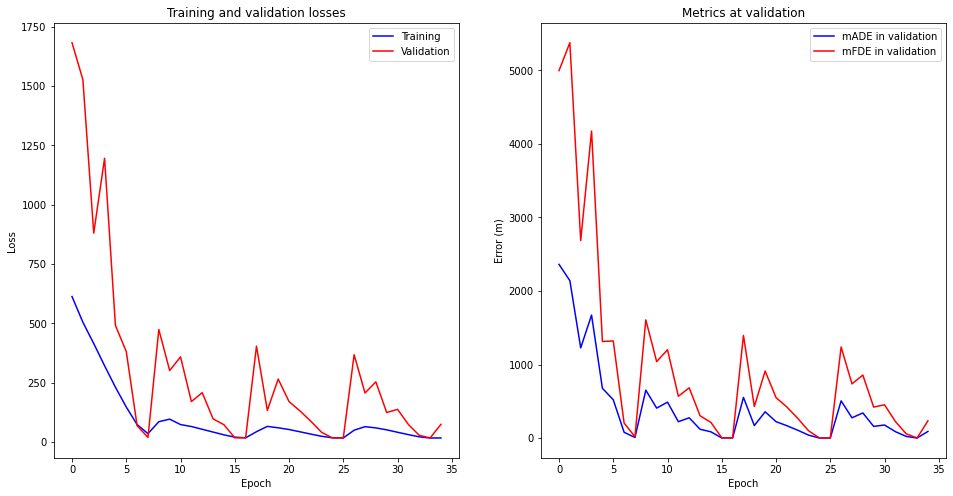

In [ ]:
# Training
perform_training = True
plot_training    = True
if perform_training==True:
    print("[INF] Training the model")
    train_loss_results,val_loss_results,val_metrics_results,__ = BDL_training_loop(tj_enc_dec,batched_train_data,batched_val_data,model_parameters,checkpoint,checkpoint_prefix)
    if plot_training==True:
        plot_training_results(train_loss_results,val_loss_results,val_metrics_results)


In [ ]:
# Testing
# Restoring the latest checkpoint in checkpoint_dir
print("[INF] Restoring last model")
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

[INF] Restoring last model


[INF] Qualitative testing


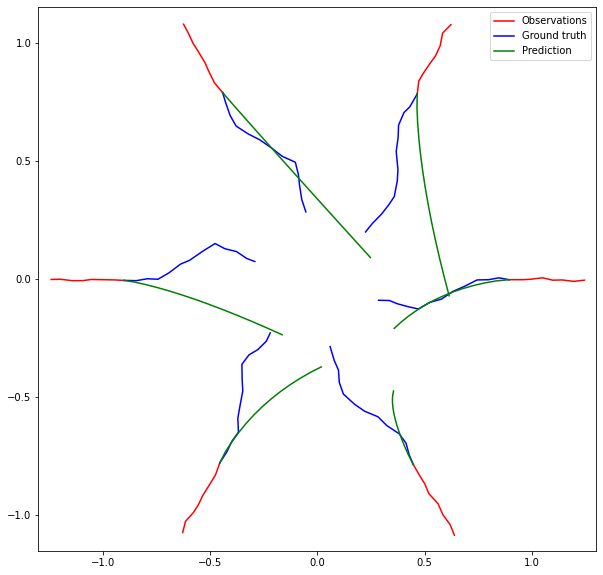

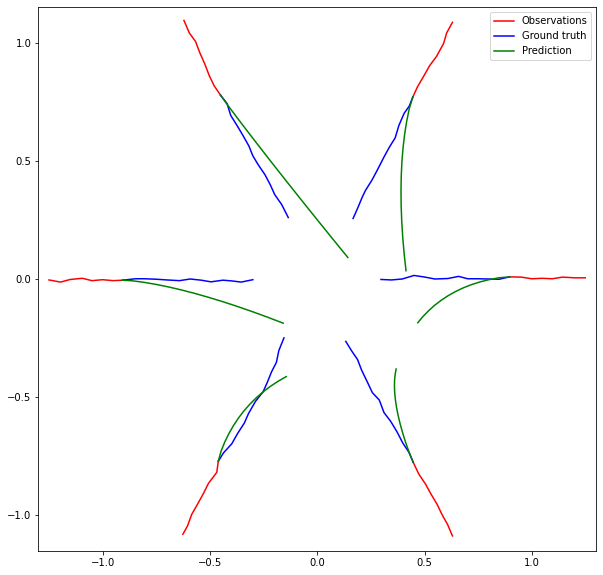

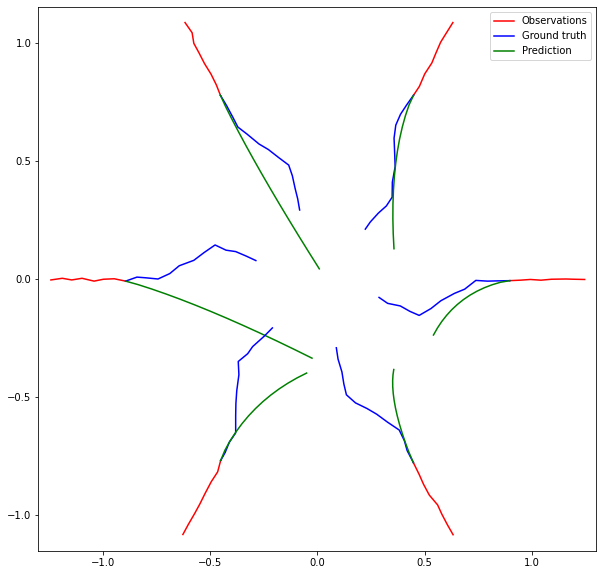

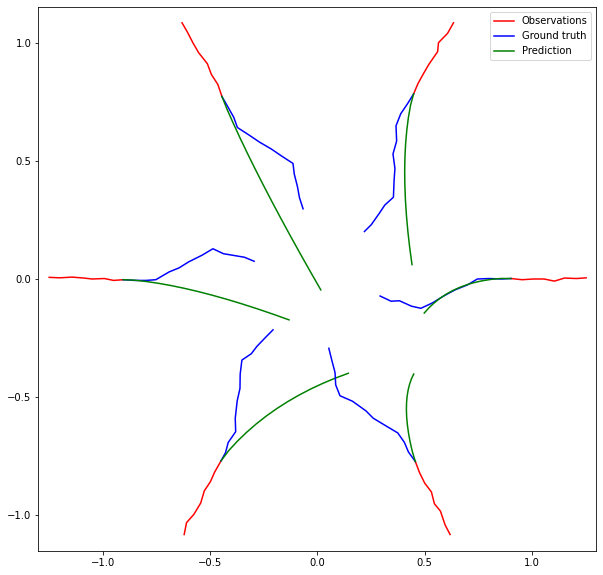

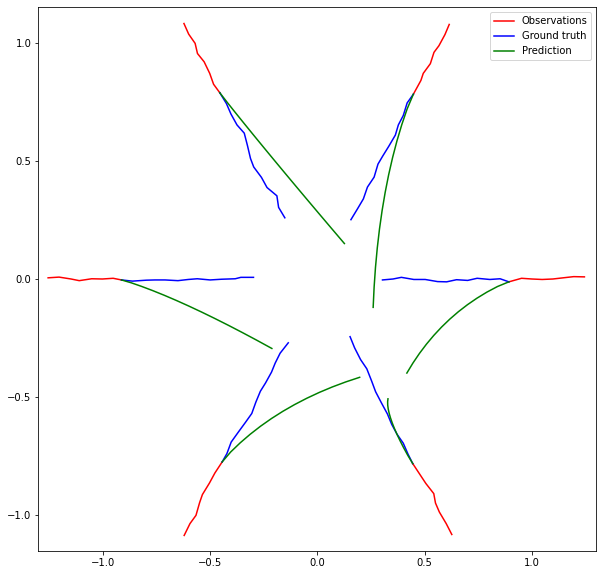

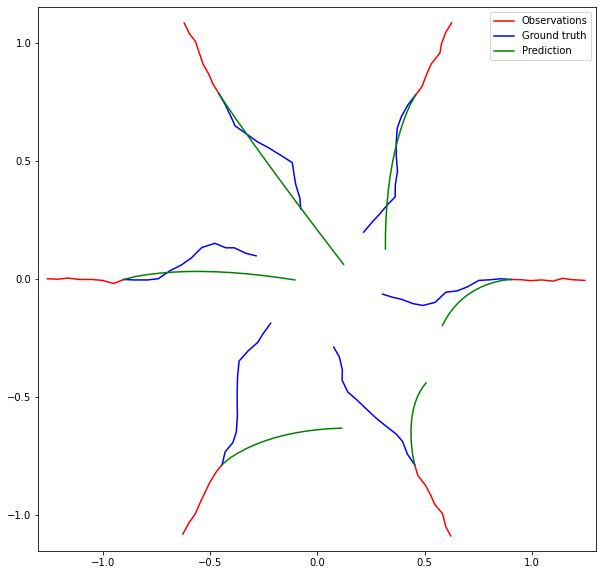

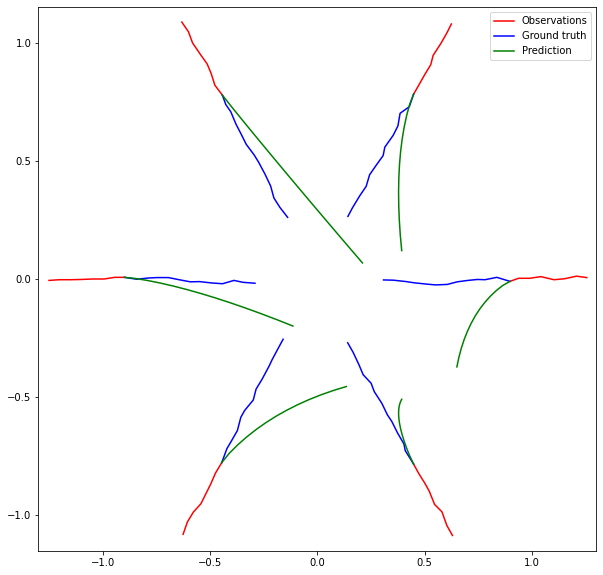

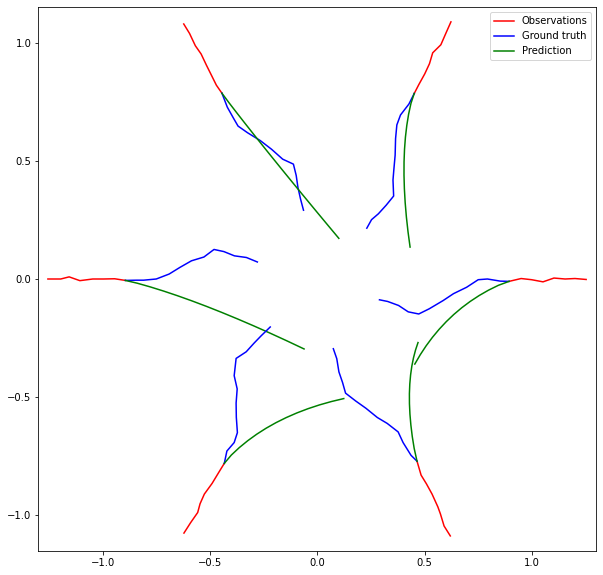

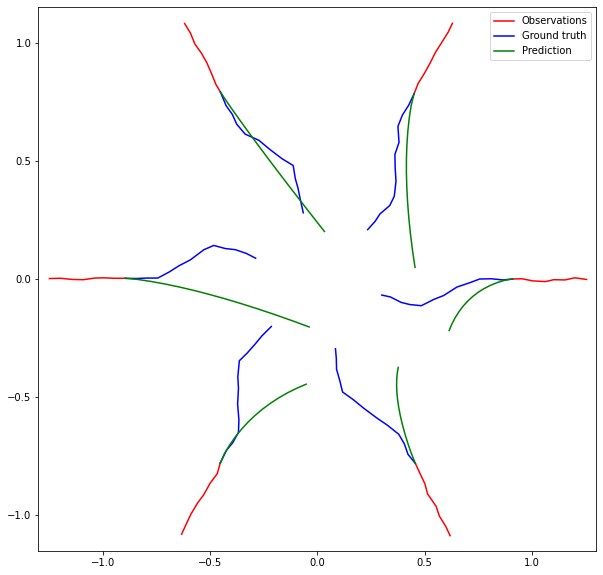

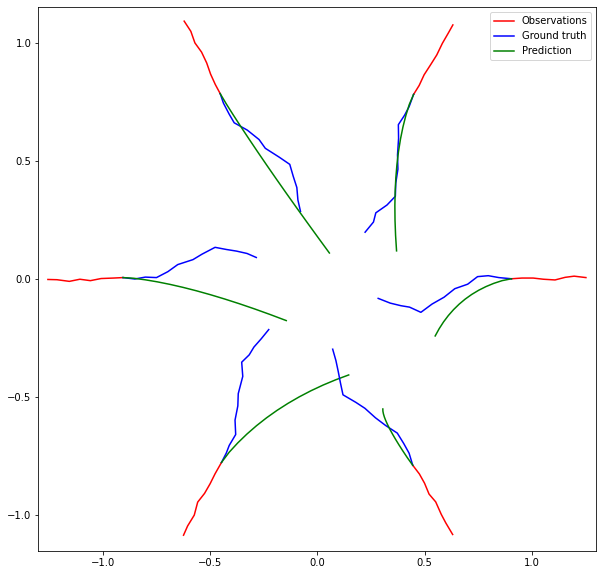

In [ ]:
from testing_utils import predict_from_batch

# Qualitative testing
qualitative = True
if qualitative==True:
    print("[INF] Qualitative testing")
    for i in range(10):
        batch = get_testing_batch_syntec(test_data,dataset_dir+dataset_names[idTest])
        traj_obs,traj_gt,traj_pred,neighbors,__ = predict_from_batch(tj_enc_dec,batch,model_parameters)

        # Plots the trajectories
        plt.figure(figsize=(10,10))
        for j in range(len(traj_obs)):

            obs = traj_obs[j] # Trajectories Obs
            gt = np.vstack([traj_obs[j][-1], traj_gt[j]]) # Ground Thrue
            pred = np.vstack([traj_obs[j][-1], traj_pred[j].numpy()[0]]) # Trajectories Pred

            plt.plot(obs[:,0], obs[:,1],'r',label= 'Observations')
            plt.plot(gt[:,0], gt[:,1],'b',label= 'Ground truth')
            plt.plot(pred[:,0], pred[:,1],'g',label= 'Prediction')

            # Axes
            plt.xlim(-1.3,1.3)
            plt.ylim(-1.15,1.15)
        plt.legend(['Observations', 'Ground truth', 'Prediction'])
        plt.show()

## Finally, Load Weights from Cyclical SG-MCMC

In [ ]:
import pickle
pickle_in = open('training_cSGMCMC_weights.pickle',"rb")
#pickle_in = open('cluster4/training_cSGMCMC_weights8.pickle',"rb")
#pickle_in = open('cluster4/training_cSGMCMC_weights4.pickle',"rb")
weights = pickle.load(pickle_in)

In [ ]:
len(weights)

20

In [ ]:
for www in weights:
    print(www[0], www[1][2][6])

0.0 [ 3.126323  -2.7983615]
0.0 [ 3.12631   -2.7983508]
0.0 [ 3.1263027 -2.7983444]
0.0 [ 3.1262999 -2.7983418]
0.0 [ 3.1262999 -2.7983418]
1.0 [ 0.6474532  -0.56580156]
1.0 [ 0.6474298 -0.5657808]
1.0 [ 0.6474131 -0.5657662]
1.0 [ 0.64740634 -0.56576025]
1.0 [ 0.64740515 -0.5657592 ]
2.0 [-0.01989178  0.01837113]
2.0 [-0.01989112  0.01837053]
2.0 [-0.01989073  0.01837022]
2.0 [-0.01989059  0.0183701 ]
2.0 [-0.01989059  0.01837009]
3.0 [ 0.05322124 -0.04005707]
3.0 [ 0.0532182  -0.04005493]
3.0 [ 0.05321649 -0.04005383]
3.0 [ 0.05321586 -0.04005341]
3.0 [ 0.05321578 -0.04005335]


In [ ]:
from matplotlib.lines import Line2D

colores = ["green",
           "yellow",
           "pink",
           "purple",
           "cyan",
           "orange",
           "olive",
           "brown",
           "grey",
           "black",
           "magenta",
           "white",
           "gold",
           "lightcoral",
           "darkred",
           "hotpink",
           "chocolate",
           "lightgray",
           "palegreen"
          ]

custom_lines = [Line2D([0],[0],color="purple",marker="s", markersize=7, linestyle=""),
                    Line2D([0],[0],color="red",lw=2),
                    Line2D([0],[0],color="blue",lw=2),
                    Line2D([0],[0],color="green",lw=2),
                    
                    Line2D([0],[0],color="yellow",lw=2),
                    Line2D([0],[0],color="pink",lw=2),
                    Line2D([0],[0],color="purple",lw=2),
                    Line2D([0],[0],color="cyan",lw=2),
                    Line2D([0],[0],color="orange",lw=2),
                    Line2D([0],[0],color="olive",lw=2),
                    Line2D([0],[0],color="brown",lw=2)
                   ]

[INF] Qualitative testing
batch:  (6, 8, 2)


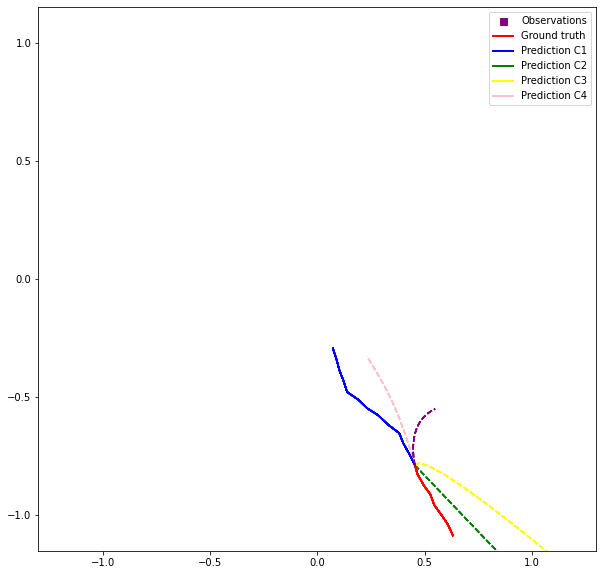

kde_nll:  11.296471671666206
timestep_kde_nll:  [ 0.19946555  2.49416232  1.1087371  10.48531822 12.36634508 13.60113512
 15.75513579 17.03458657 17.11519803 16.55610844 15.32133702 13.52013083]
batch:  (6, 8, 2)


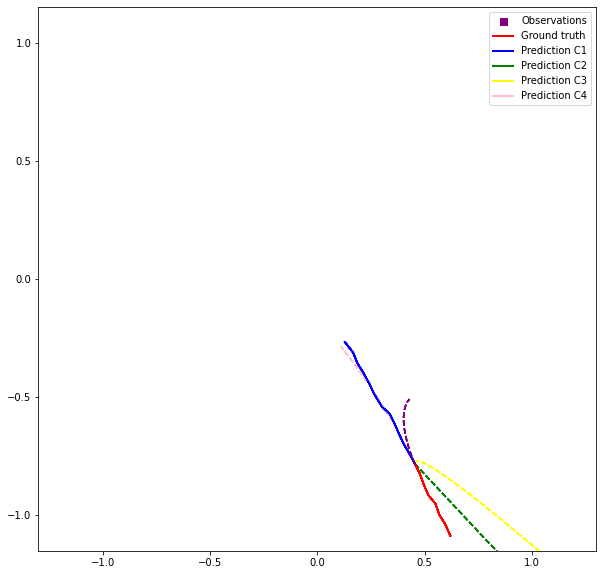

kde_nll:  2.4318014038203954
timestep_kde_nll:  [ 2.28735432  5.4734587   4.7021611   1.97441937 -0.81401719 -0.7821847
  0.31477173  1.08413863  2.97159059  3.96432405  3.71091545  4.29468479]
batch:  (6, 8, 2)


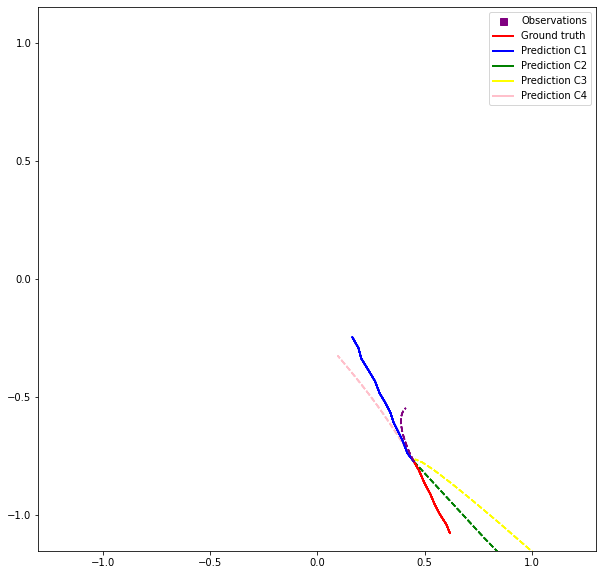

kde_nll:  4.015565718559533
timestep_kde_nll:  [9.74492789 1.2249918  1.92904708 2.16322799 2.37315819 1.72751617
 2.41532514 3.29807138 3.79874057 5.56961019 7.26086073 6.6813115 ]
batch:  (6, 8, 2)


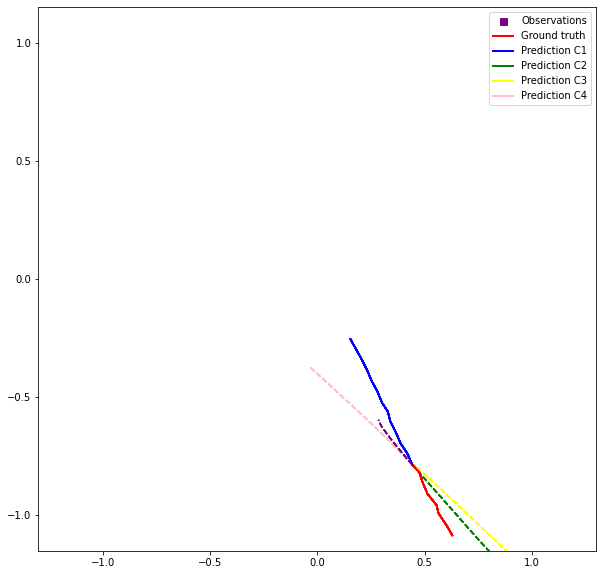

kde_nll:  6.042540859315151
timestep_kde_nll:  [ 4.62310305  6.50381628  4.2225276   4.48151808  3.76726802  3.69849912
  3.31627344  5.5310158   6.6181911   9.08593274 10.09804507 10.56429999]
batch:  (6, 8, 2)


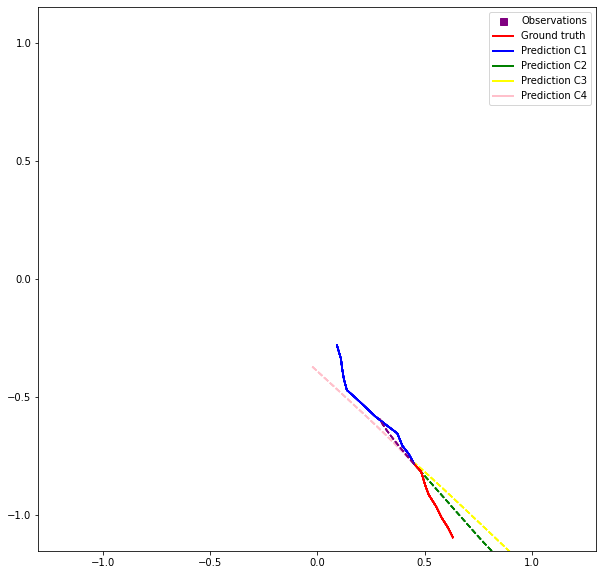

kde_nll:  14.032350417126136
timestep_kde_nll:  [15.4537534  12.72793995 13.87070298  9.33167717 11.23609601 11.76871087
 12.41524719 15.80279806 15.09898916 17.06631508 17.06327577 16.55269935]
batch:  (6, 8, 2)


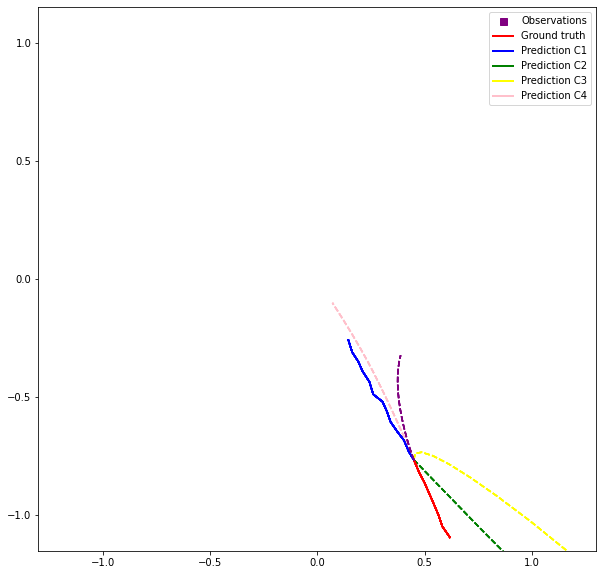

kde_nll:  9.393140360238139
timestep_kde_nll:  [15.74266372 10.82456489  9.57944363  7.20723087  5.50881676  5.30806231
  6.4557504   9.64164001 10.54089627 10.70542746 10.82305491 10.38013308]
batch:  (6, 8, 2)


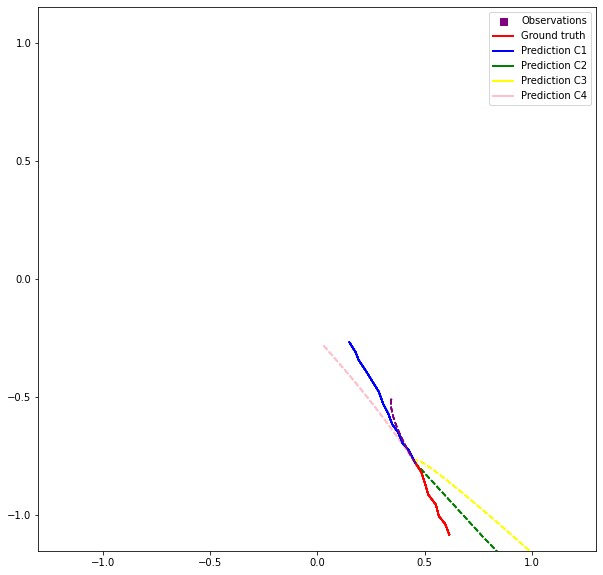

kde_nll:  3.5280072907420186
timestep_kde_nll:  [9.93028597 8.80788946 2.65342194 0.04317995 1.1211393  0.26378804
 0.99275782 1.40157409 2.048347   4.54360291 5.19632009 5.3337809 ]
batch:  (6, 8, 2)


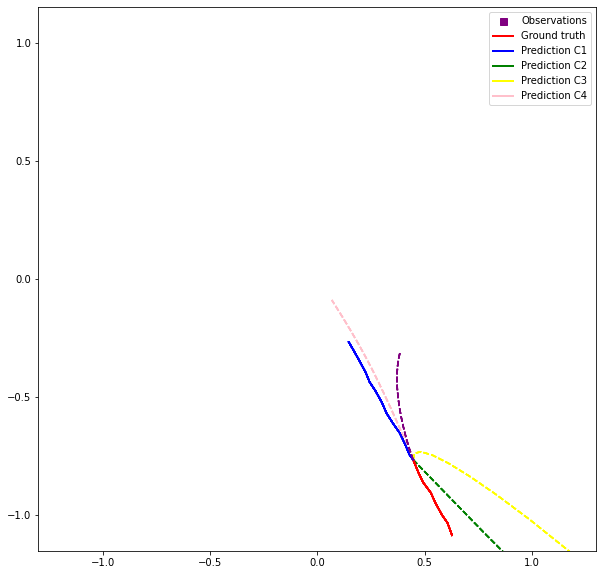

kde_nll:  8.045991253953197
timestep_kde_nll:  [ 7.60950069  6.65506591  6.19342115  7.06549304  6.85769011  5.98753004
  6.51758681  8.04410109  9.70481726 10.48980896 10.52242212 10.90445786]
batch:  (6, 8, 2)


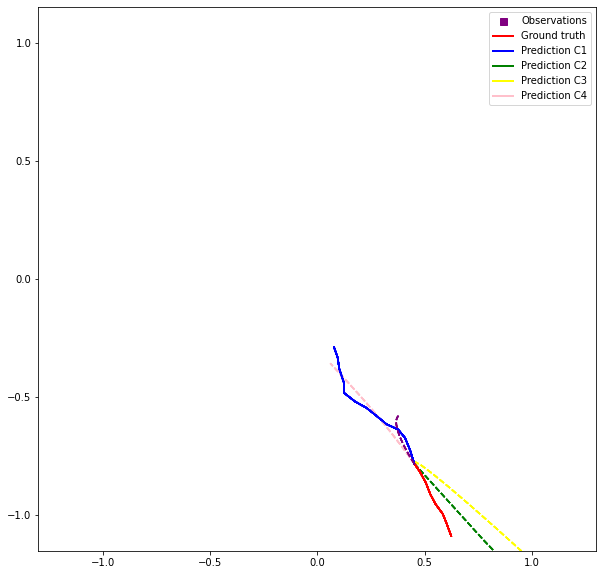

kde_nll:  8.370404421183048
timestep_kde_nll:  [ 8.10303183  8.3903754   5.00197785  2.50863901  3.61042579  6.45208739
 10.95138166 14.42058394 12.9383521  12.01173342 10.74115116  5.3151135 ]
batch:  (6, 8, 2)


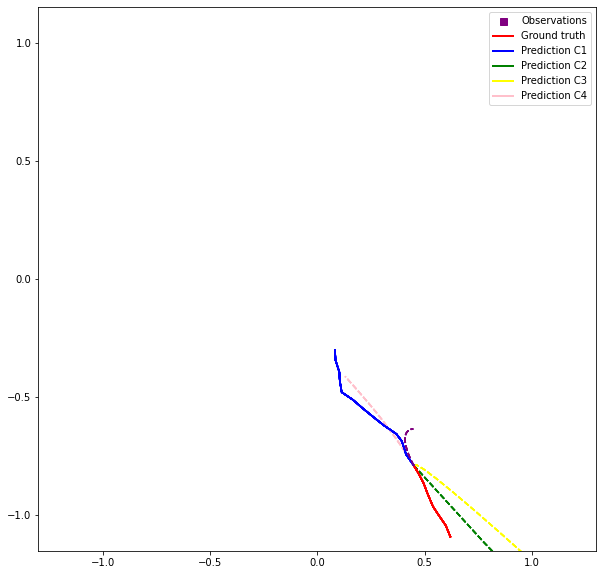

kde_nll:  7.995358764677755
timestep_kde_nll:  [ 7.94550609 12.247786    7.51645519  6.84052031  5.1950555   3.87512507
  6.75757137  9.18447946  7.05130565  9.63658495  9.79082382  9.90309177]
batch:  (6, 8, 2)


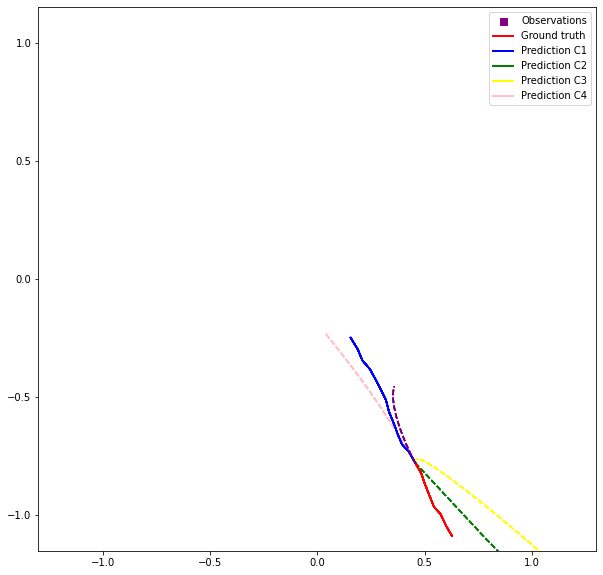

kde_nll:  5.700982998664395
timestep_kde_nll:  [12.88449504 10.49702001  9.2039183   1.94194242  3.05139799  2.57932565
  1.53769055  2.9190262   3.80877301  5.16615539  8.08321605  6.73883539]
batch:  (6, 8, 2)


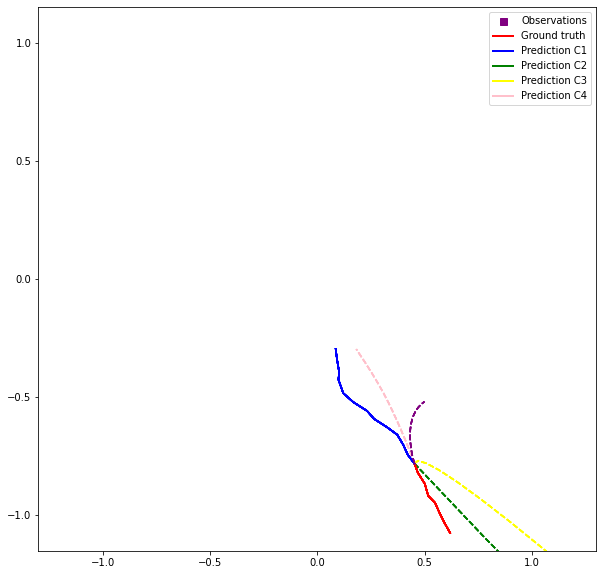

kde_nll:  10.703941343058903
timestep_kde_nll:  [ 9.87148026  7.22420749  6.55868329  5.72749987  8.80616679  9.58025253
 12.99192387 13.4985984  13.07823142 13.60517129 13.61523165 13.88984925]
batch:  (6, 8, 2)


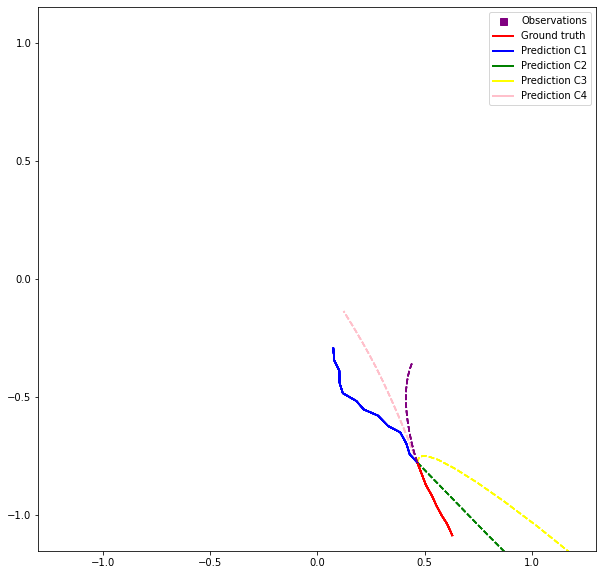

kde_nll:  8.150665160645278
timestep_kde_nll:  [ 5.21509732  5.06408019  5.22185536  6.44380455  8.37564124  9.21623607
  9.65219429  9.99853102 10.33658493  9.52037511 10.59754397  8.16603788]
batch:  (6, 8, 2)


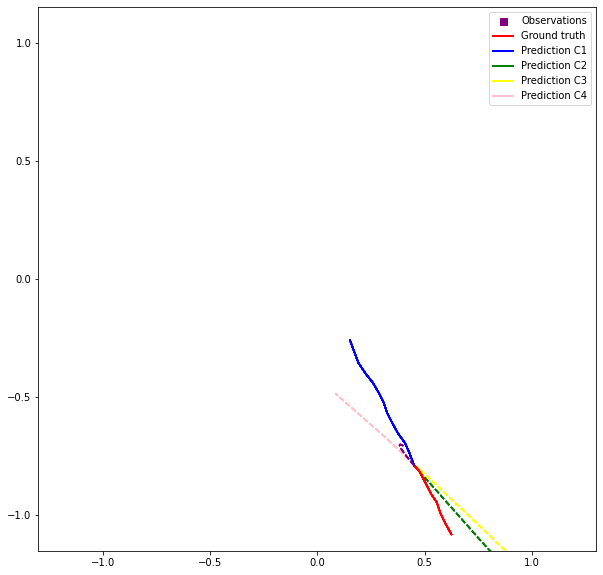

kde_nll:  16.22411285908886
timestep_kde_nll:  [17.67470372 16.84171076 15.4666159  14.78251407 13.94729261 13.95004276
 14.30051201 15.1680857  16.14104189 17.88079871 19.2577855  19.27825067]
batch:  (6, 8, 2)


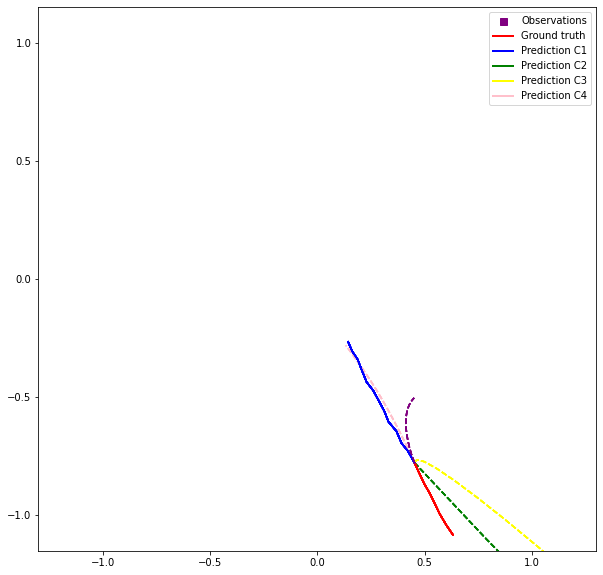

kde_nll:  8.539033372394158
timestep_kde_nll:  [14.09277436  8.23934683  6.43818729  7.18736542  5.66757862  5.93244308
  6.1749168   6.97399159  8.68843904 10.90146523 10.86757748 11.30431473]
batch:  (6, 8, 2)


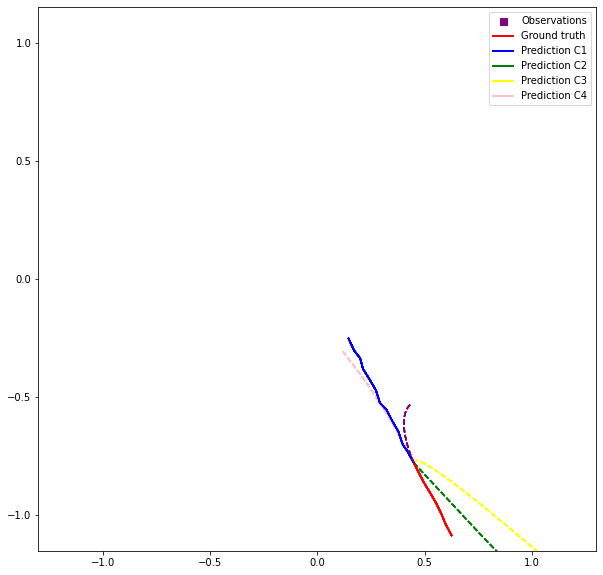

kde_nll:  2.3207652755704937
timestep_kde_nll:  [ 3.13712494  1.72735807  0.02699098 -0.93247713  0.30618894  0.79652821
  1.8569377   2.50632849  3.80322104  4.25109882  4.87826048  5.49162276]
batch:  (6, 8, 2)


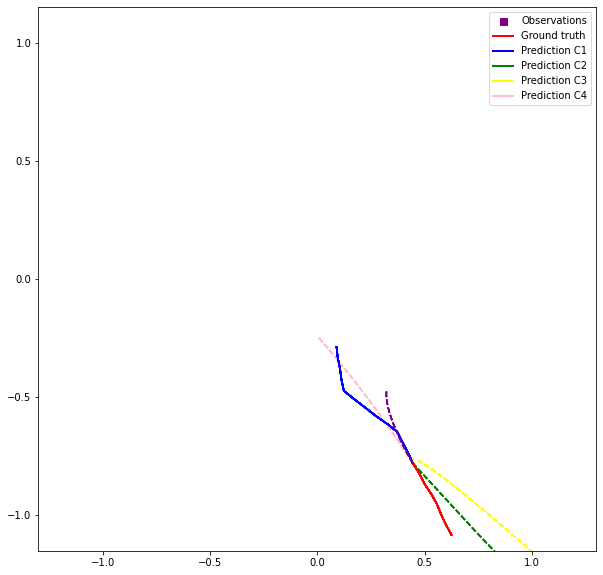

kde_nll:  5.857760430006019
timestep_kde_nll:  [-2.16151338 -3.31931198 -2.79955294  1.95921933  6.29502956 10.0369199
 11.89312666 12.83991013 11.30094329  8.84238993  7.96212818  7.44383648]
batch:  (6, 8, 2)


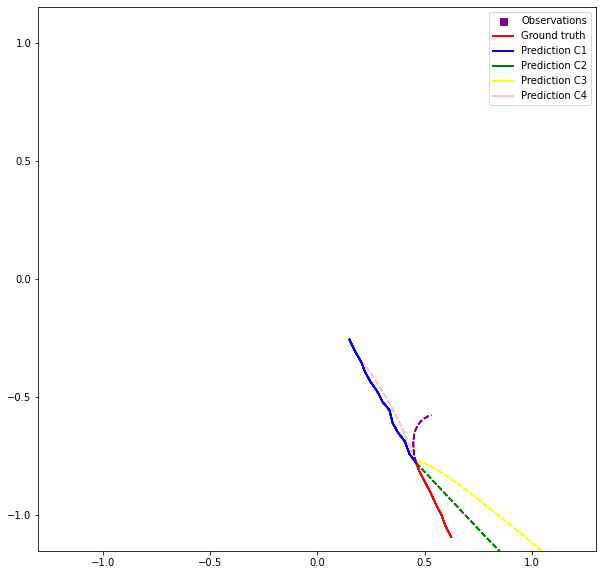

kde_nll:  4.319669948853727
timestep_kde_nll:  [4.78707874 2.496802   3.92222014 1.1329472  2.22325269 2.25277973
 1.43492694 3.71603336 6.79885615 7.18161783 7.17458515 8.71493946]
batch:  (6, 8, 2)


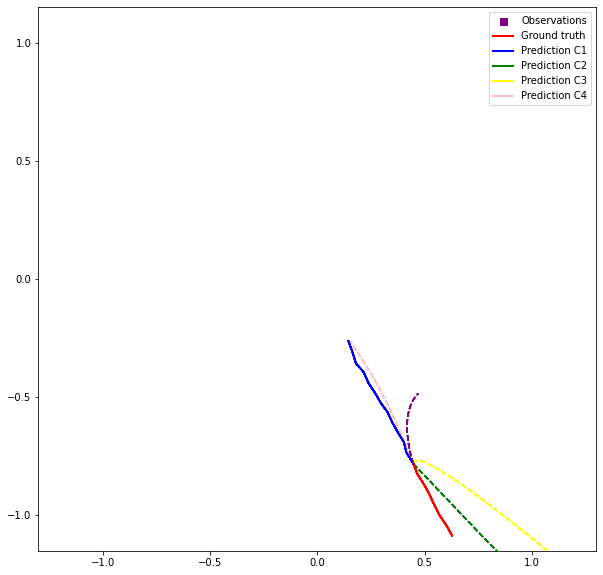

kde_nll:  11.601204801179264
timestep_kde_nll:  [10.69387614 13.07290982 12.58110989 10.83513556  9.29708668 10.23958903
 10.85844348 11.5303772  11.62663311 12.6653428  13.23386808 12.58008584]
batch:  (6, 8, 2)


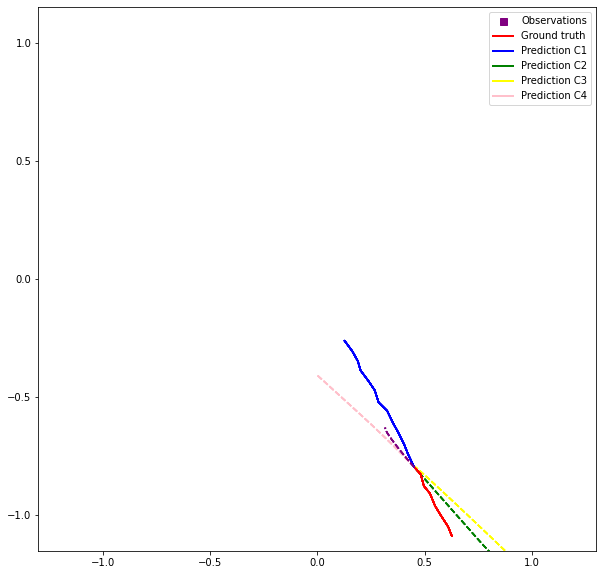

kde_nll:  8.958441420356095
timestep_kde_nll:  [11.71496735 12.08002928  8.72014983  9.53004715  7.61402395  6.98769865
  5.28449779  7.15857754  8.82848807  9.61762912  9.90875797 10.05643033]
batch:  (6, 8, 2)


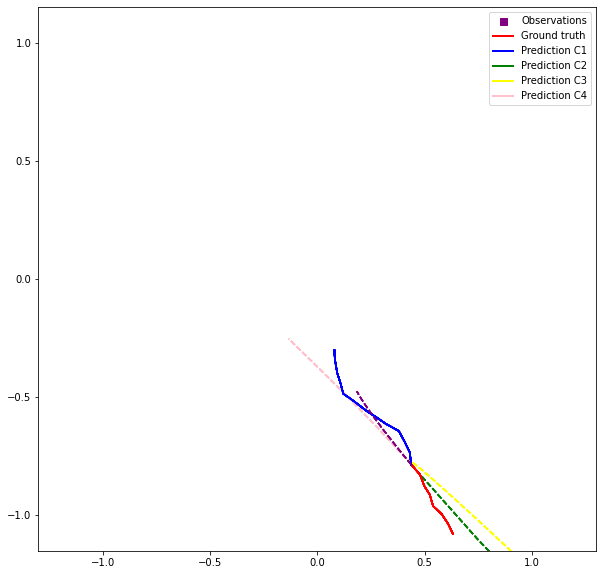

kde_nll:  8.207582848436308
timestep_kde_nll:  [ 7.88816297  3.37146173  4.09333684  5.14465233  6.27753538  9.64212746
  9.29107263  9.61196956  9.68926995 10.25815037 11.85221881 11.37103614]
batch:  (6, 8, 2)


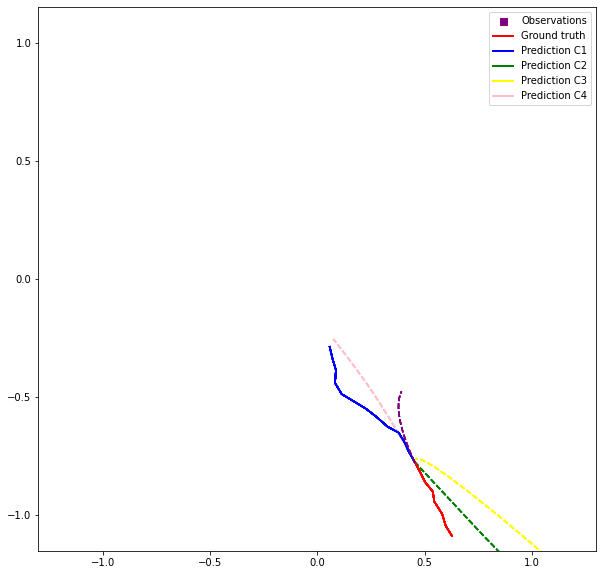

kde_nll:  9.32659252079143
timestep_kde_nll:  [ 9.17285998  8.78580838  5.42231826  5.18331215  6.06636175  7.39805799
  9.19570544 12.90520427 12.52876079 13.31699037 12.57201374  9.37171715]
batch:  (6, 8, 2)


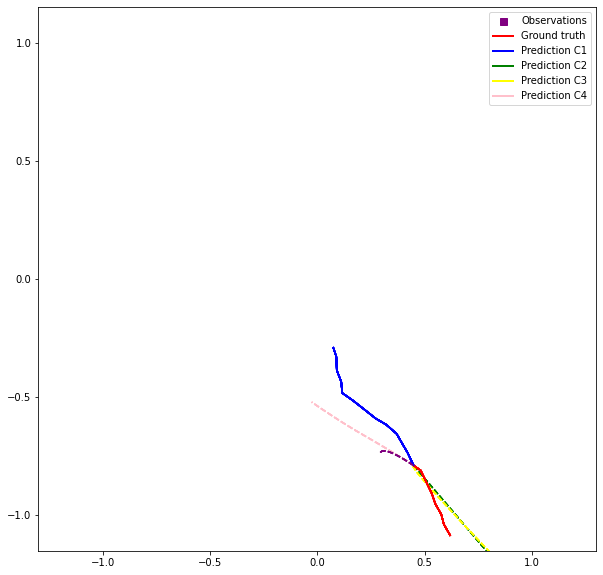

kde_nll:  9.35083312353321
timestep_kde_nll:  [ 6.89877878 13.81933702  6.32877812  4.38533343  6.83982666  5.29370075
  7.59605116 11.42410958 13.89889082 13.26050177 12.29056077 10.17412863]
batch:  (6, 8, 2)


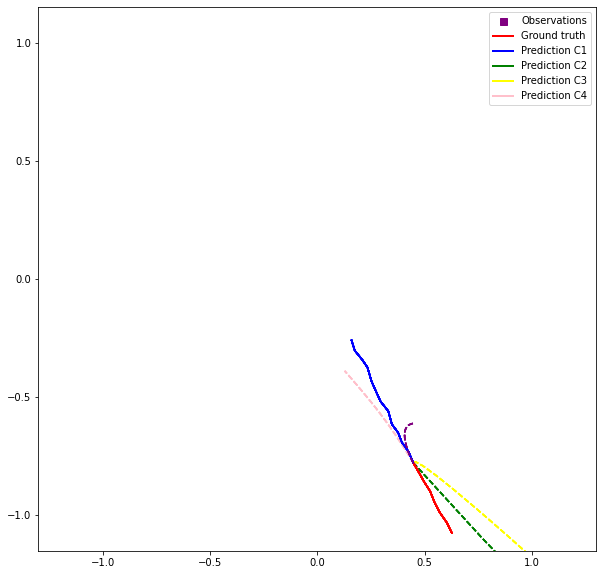

kde_nll:  7.050907037656968
timestep_kde_nll:  [12.60961568  4.58101931  3.41547239  3.56388491  3.47352854  3.23672677
  4.2765454   6.38932448  9.84833635 10.63015901 11.16818428 11.41808734]
batch:  (6, 8, 2)


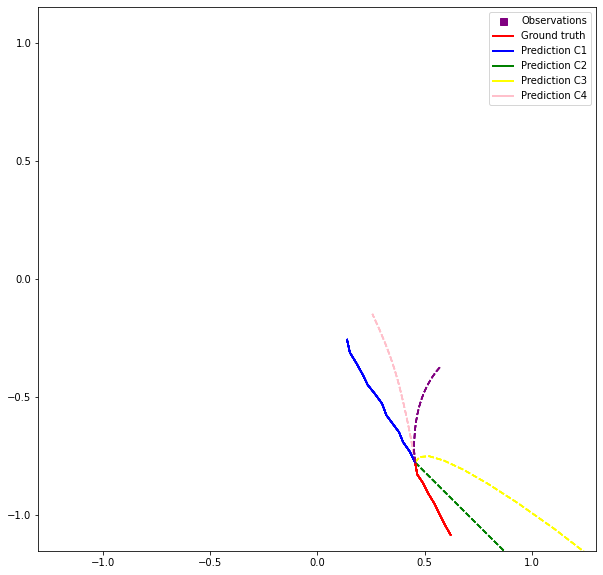

kde_nll:  3.1646541970802873
timestep_kde_nll:  [4.79288837 4.20525409 1.56376232 1.5734891  1.81879659 2.24902402
 2.47496599 2.6640008  3.25975721 3.82301247 4.98113818 4.56976124]
batch:  (6, 8, 2)


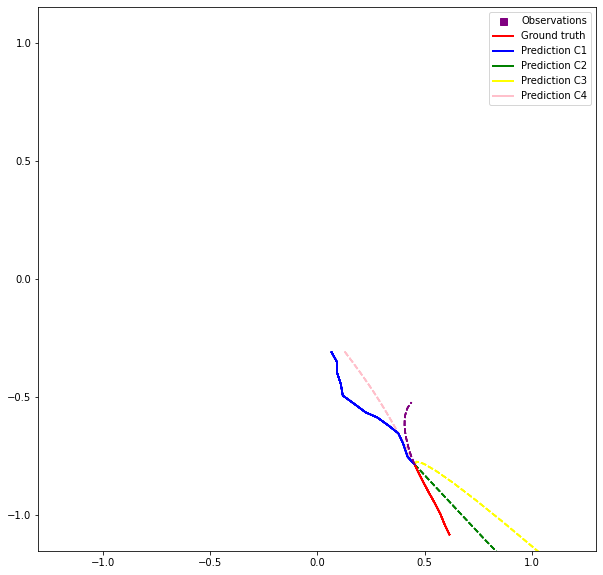

kde_nll:  12.299299289412255
timestep_kde_nll:  [11.36713057  8.03147555  6.09938861  6.28305044  9.13172738 12.6786654
 15.30865643 17.08898574 17.41975197 17.35959359 15.35628174 11.46688405]
batch:  (6, 8, 2)


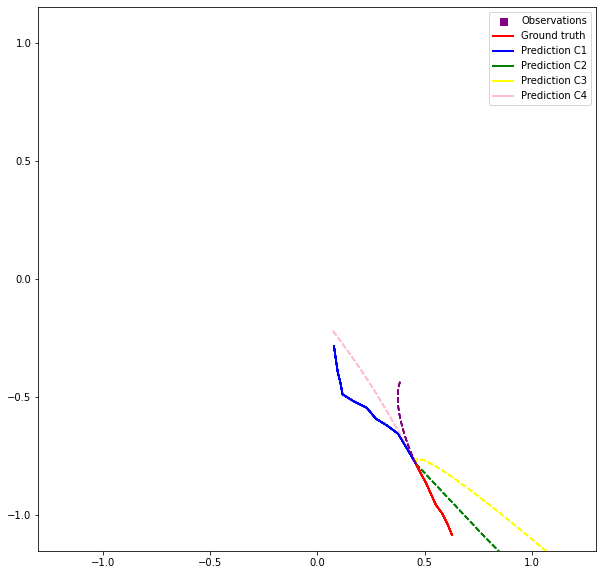

kde_nll:  8.335985863193894
timestep_kde_nll:  [ 6.19991079  3.6906793  -0.58488862  5.20557701  7.46021714  8.99223119
 12.05243511 13.37716564 12.58321603 13.39470624 11.02634971  6.63423082]
batch:  (6, 8, 2)


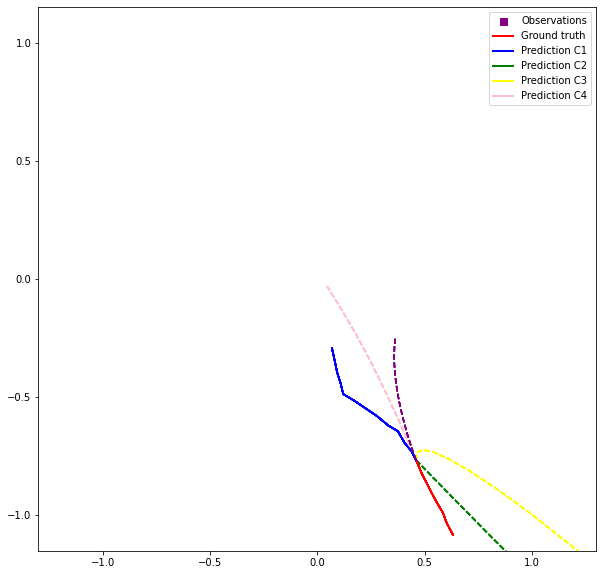

kde_nll:  10.119670524573069
timestep_kde_nll:  [15.26401406 13.34469107  9.64958479 10.19666364  9.56052006  8.99412657
  7.29375758  8.02365602  9.90644524  9.64266411  9.78711048  9.77281266]
batch:  (6, 8, 2)


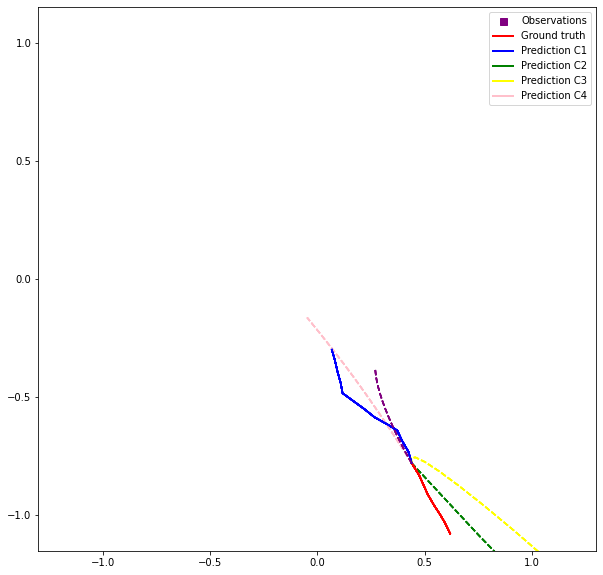

kde_nll:  10.99860660984311
timestep_kde_nll:  [10.75603842  6.24404174  3.29898511  1.95302417  9.99481309 12.16073008
 14.42868971 16.39592853 15.78548299 17.39656648 13.12565641 10.44332258]
batch:  (6, 8, 2)


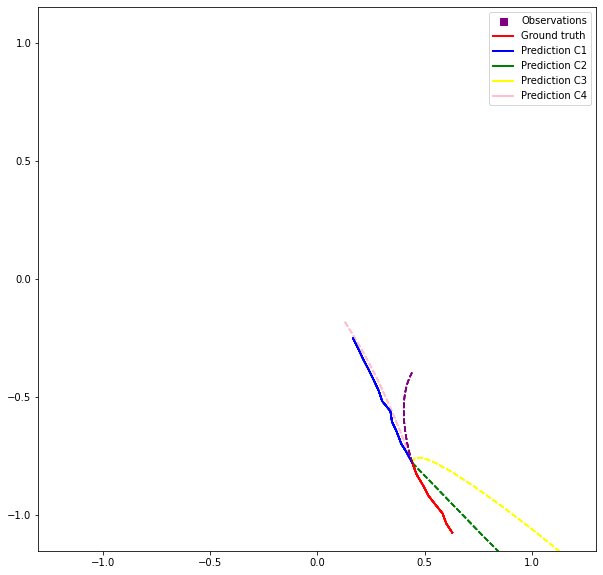

kde_nll:  2.5128638097770315
timestep_kde_nll:  [ 6.63338918  1.72709233  1.10762192  0.18016955 -1.04046609  0.0909432
  0.41386466  1.73234788  2.79176874  4.93357115  5.29964927  6.28441393]


In [ ]:
from plot_utils import plot_gt_preds, plot_background, plot_neighbors, plot_attention
from batches_data import get_batch
from traj_utils import relative_to_abs

#from testing_utils import compute_kde_nll2

# Qualitative testing
num_print_test = 30
model_parameters.output_var_dirs= 0
qualitative = True
if qualitative==True:
    print("[INF] Qualitative testing")
    for it in range(num_print_test):
        batch = get_testing_batch_syntec(test_data,dataset_dir+dataset_names[idTest])
        print("batch: ", batch['obs_traj'].shape)
        
        # Plot ground truth and predictions
        plt.subplots(1,1,figsize=(10,10))
        ax = plt.subplot(1,1,1)

        #-----------------------------------------------------------------------
        batch_inputs, batch_targets = get_batch(batch, model_parameters)

        # Iterate the diference weights for the model
        cont = 0
        for w_ind, weight in weights:
          # Perform prediction
          pred_traj, _ = tj_enc_dec.predict_cSGMCMC(batch_inputs,batch_targets.shape[1],weight)

          traj_obs      = []
          traj_gt       = []
          traj_pred     = []
          neighbors     = []
          # Cycle over the trajectories of the bach
          for i, (obs_traj_gt, pred_traj_gt, neighbors_gt) in enumerate(zip(batch["obs_traj"], batch["pred_traj"], batch["obs_neighbors"])):
              this_pred_out_abs_set = []

              if (pred_traj[i,0].shape[0] == model_parameters.pred_len):
                  this_pred_out     = pred_traj[i,0,:, :2]
                  # Convert it to absolute (starting from the last observed position)
                  this_pred_out_abs = relative_to_abs(this_pred_out, obs_traj_gt[-1])
                  this_pred_out_abs_set.append(this_pred_out_abs)
               #   print("this_pred_out_abs: ", this_pred_out_abs.shape)
              this_pred_out_abs_set = tf.stack(this_pred_out_abs_set,axis=0)
              # TODO: tensors instead of lists?
              # Keep all the trajectories
              traj_obs.append(obs_traj_gt)
              traj_gt.append(pred_traj_gt)
              traj_pred.append(this_pred_out_abs_set)
              neighbors.append(neighbors_gt)

          #-----------------------------------------------------------------------
          # Plot ground truth and predictions
          if cont == 0:
            pred_out = np.array(traj_pred)
          else:
            pred_out = np.concatenate([pred_out, np.array(traj_pred)],axis=1)
          cont += 1
          obs = traj_obs[j] # Trajectories Obs
          gt = np.vstack([traj_obs[j][-1], traj_gt[j]]) # Ground Thrue
          pred = np.vstack([traj_obs[j][-1], traj_pred[j].numpy()[0]]) # Trajectories Pred

          plt.plot(obs[:,0], obs[:,1],'r')
          plt.plot(gt[:,0], gt[:,1],'b')
          plt.plot(pred[:,0], pred[:,1],"--", label='Prediction C'+str(w_ind+1) , color=colores[int(w_ind)])

          # Axes
          plt.xlim(-1.3,1.3)
          plt.ylim(-1.15,1.15)

        legends = ['Prediction C'+str(ciclo+1) for ciclo in range(int(w_ind)+1)]
        plt.legend(custom_lines,['Observations', 'Ground truth']+legends)
        plt.savefig('images/temp_'+str(it)+'.pdf')
        plt.show()

#        kde_nll, timestep_kde_nll = compute_kde_nll2(pred_out, np.array(traj_gt))
#        print("kde_nll: ", kde_nll)
#        print("timestep_kde_nll: ", timestep_kde_nll)
